In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [8]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * dones
    targetQs = rewards + (gamma * nextQs)
    dQs = tf.reshape(dQs, shape=[-1])
    aloss2 += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, aloss, dloss, aloss2

In [9]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [11]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [12]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [14]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [15]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [16]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates >= np.max(rates)]
            actions = actions[rates >= np.max(rates)]
            next_states = next_states[rates >= np.max(rates)]
            rewards = rewards[rates >= np.max(rates)]
            dones = dones[rates >= np.max(rates)]
            rates = rates[rates >= np.max(rates)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 aloss:1.3768 dloss:0.9183 aloss2:0.9418 exploreP:0.9985
Episode:1 meanR:18.5000 R:22.0000 rate:0.0440 aloss:1.3741 dloss:0.9254 aloss2:0.9323 exploreP:0.9963
Episode:2 meanR:17.3333 R:15.0000 rate:0.0300 aloss:1.3770 dloss:0.9139 aloss2:0.9618 exploreP:0.9949
Episode:3 meanR:17.5000 R:18.0000 rate:0.0360 aloss:1.3741 dloss:0.9645 aloss2:1.0731 exploreP:0.9931
Episode:4 meanR:17.4000 R:17.0000 rate:0.0340 aloss:1.3859 dloss:0.9168 aloss2:1.0386 exploreP:0.9914
Episode:5 meanR:18.8333 R:26.0000 rate:0.0520 aloss:1.3775 dloss:0.9207 aloss2:1.0244 exploreP:0.9889
Episode:6 meanR:18.1429 R:14.0000 rate:0.0280 aloss:1.3801 dloss:0.9491 aloss2:1.0222 exploreP:0.9875
Episode:7 meanR:17.2500 R:11.0000 rate:0.0220 aloss:1.3720 dloss:0.8617 aloss2:1.0698 exploreP:0.9864
Episode:8 meanR:16.8889 R:14.0000 rate:0.0280 aloss:1.3762 dloss:0.8794 aloss2:1.0364 exploreP:0.9851
Episode:9 meanR:16.9000 R:17.0000 rate:0.0340 aloss:1.3769 dloss:0.8923 aloss2:1.0

Episode:80 meanR:21.5309 R:24.0000 rate:0.0480 aloss:1.4191 dloss:0.4837 aloss2:4.2833 exploreP:0.8416
Episode:81 meanR:21.5488 R:23.0000 rate:0.0460 aloss:1.4162 dloss:0.4885 aloss2:4.2994 exploreP:0.8397
Episode:82 meanR:21.5422 R:21.0000 rate:0.0420 aloss:1.4116 dloss:0.4828 aloss2:4.2629 exploreP:0.8379
Episode:83 meanR:21.4405 R:13.0000 rate:0.0260 aloss:1.4221 dloss:0.4785 aloss2:4.4501 exploreP:0.8368
Episode:84 meanR:21.3765 R:16.0000 rate:0.0320 aloss:1.4282 dloss:0.4788 aloss2:4.5316 exploreP:0.8355
Episode:85 meanR:21.2791 R:13.0000 rate:0.0260 aloss:1.4262 dloss:0.4689 aloss2:4.4635 exploreP:0.8344
Episode:86 meanR:21.3103 R:24.0000 rate:0.0480 aloss:1.4206 dloss:0.4746 aloss2:4.6490 exploreP:0.8325
Episode:87 meanR:21.2500 R:16.0000 rate:0.0320 aloss:1.4222 dloss:0.4904 aloss2:4.4720 exploreP:0.8311
Episode:88 meanR:21.2022 R:17.0000 rate:0.0340 aloss:1.4276 dloss:0.4646 aloss2:4.7971 exploreP:0.8298
Episode:89 meanR:21.1889 R:20.0000 rate:0.0400 aloss:1.4282 dloss:0.4563 

Episode:159 meanR:22.5900 R:31.0000 rate:0.0620 aloss:1.4583 dloss:0.3960 aloss2:8.6850 exploreP:0.6979
Episode:160 meanR:22.5600 R:12.0000 rate:0.0240 aloss:1.4395 dloss:0.3768 aloss2:8.8313 exploreP:0.6970
Episode:161 meanR:23.1100 R:67.0000 rate:0.1340 aloss:1.4624 dloss:0.3807 aloss2:8.6922 exploreP:0.6925
Episode:162 meanR:22.9100 R:14.0000 rate:0.0280 aloss:1.4480 dloss:0.3829 aloss2:8.9492 exploreP:0.6915
Episode:163 meanR:22.9600 R:17.0000 rate:0.0340 aloss:1.4672 dloss:0.3809 aloss2:8.7054 exploreP:0.6903
Episode:164 meanR:23.0700 R:28.0000 rate:0.0560 aloss:1.4611 dloss:0.3845 aloss2:8.7508 exploreP:0.6884
Episode:165 meanR:23.1800 R:27.0000 rate:0.0540 aloss:1.4519 dloss:0.3819 aloss2:8.8765 exploreP:0.6866
Episode:166 meanR:23.2400 R:19.0000 rate:0.0380 aloss:1.4424 dloss:0.3811 aloss2:8.7192 exploreP:0.6853
Episode:167 meanR:23.3600 R:28.0000 rate:0.0560 aloss:1.4681 dloss:0.3731 aloss2:8.9378 exploreP:0.6834
Episode:168 meanR:23.6400 R:42.0000 rate:0.0840 aloss:1.4620 dlo

Episode:238 meanR:21.9900 R:20.0000 rate:0.0400 aloss:1.4808 dloss:0.3842 aloss2:8.9881 exploreP:0.5877
Episode:239 meanR:22.0600 R:22.0000 rate:0.0440 aloss:1.5187 dloss:0.3908 aloss2:8.9576 exploreP:0.5864
Episode:240 meanR:22.0900 R:27.0000 rate:0.0540 aloss:1.4737 dloss:0.3681 aloss2:9.0273 exploreP:0.5848
Episode:241 meanR:21.8600 R:16.0000 rate:0.0320 aloss:1.4770 dloss:0.3847 aloss2:9.0347 exploreP:0.5839
Episode:242 meanR:21.8500 R:21.0000 rate:0.0420 aloss:1.4681 dloss:0.3821 aloss2:9.0876 exploreP:0.5827
Episode:243 meanR:21.9900 R:36.0000 rate:0.0720 aloss:1.4693 dloss:0.3796 aloss2:9.0292 exploreP:0.5807
Episode:244 meanR:21.6800 R:12.0000 rate:0.0240 aloss:1.4679 dloss:0.3644 aloss2:9.1084 exploreP:0.5800
Episode:245 meanR:21.7300 R:16.0000 rate:0.0320 aloss:1.4653 dloss:0.3822 aloss2:9.1119 exploreP:0.5791
Episode:246 meanR:21.7400 R:14.0000 rate:0.0280 aloss:1.4894 dloss:0.3790 aloss2:9.1133 exploreP:0.5783
Episode:247 meanR:21.5700 R:12.0000 rate:0.0240 aloss:1.4548 dlo

Episode:317 meanR:21.9800 R:38.0000 rate:0.0760 aloss:1.5014 dloss:0.3875 aloss2:9.1908 exploreP:0.4947
Episode:318 meanR:22.3600 R:51.0000 rate:0.1020 aloss:1.4814 dloss:0.3876 aloss2:9.0984 exploreP:0.4922
Episode:319 meanR:22.4300 R:25.0000 rate:0.0500 aloss:1.4968 dloss:0.3765 aloss2:9.1636 exploreP:0.4910
Episode:320 meanR:22.3600 R:27.0000 rate:0.0540 aloss:1.4998 dloss:0.3813 aloss2:9.1078 exploreP:0.4897
Episode:321 meanR:22.3700 R:17.0000 rate:0.0340 aloss:1.4766 dloss:0.3686 aloss2:9.0760 exploreP:0.4889
Episode:322 meanR:22.4200 R:19.0000 rate:0.0380 aloss:1.5091 dloss:0.3690 aloss2:9.1365 exploreP:0.4880
Episode:323 meanR:22.4700 R:18.0000 rate:0.0360 aloss:1.5269 dloss:0.3621 aloss2:9.1313 exploreP:0.4871
Episode:324 meanR:22.5300 R:33.0000 rate:0.0660 aloss:1.4877 dloss:0.3818 aloss2:9.2151 exploreP:0.4856
Episode:325 meanR:22.7900 R:41.0000 rate:0.0820 aloss:1.4771 dloss:0.3723 aloss2:9.2225 exploreP:0.4836
Episode:326 meanR:22.7900 R:20.0000 rate:0.0400 aloss:1.4672 dlo

Episode:396 meanR:21.6000 R:18.0000 rate:0.0360 aloss:1.5174 dloss:0.3661 aloss2:9.2535 exploreP:0.4190
Episode:397 meanR:21.6300 R:14.0000 rate:0.0280 aloss:1.4537 dloss:0.3675 aloss2:9.2537 exploreP:0.4184
Episode:398 meanR:21.6200 R:18.0000 rate:0.0360 aloss:1.5104 dloss:0.3661 aloss2:9.2765 exploreP:0.4176
Episode:399 meanR:21.7000 R:22.0000 rate:0.0440 aloss:1.4901 dloss:0.3982 aloss2:9.2680 exploreP:0.4168
Episode:400 meanR:21.6700 R:21.0000 rate:0.0420 aloss:1.5039 dloss:0.3582 aloss2:9.2826 exploreP:0.4159
Episode:401 meanR:21.7300 R:26.0000 rate:0.0520 aloss:1.4990 dloss:0.3697 aloss2:9.2891 exploreP:0.4148
Episode:402 meanR:21.7800 R:21.0000 rate:0.0420 aloss:1.4992 dloss:0.3831 aloss2:9.2841 exploreP:0.4140
Episode:403 meanR:21.7600 R:17.0000 rate:0.0340 aloss:1.5002 dloss:0.3685 aloss2:9.2559 exploreP:0.4133
Episode:404 meanR:21.5100 R:16.0000 rate:0.0320 aloss:1.4897 dloss:0.3939 aloss2:9.2719 exploreP:0.4127
Episode:405 meanR:21.5600 R:22.0000 rate:0.0440 aloss:1.4922 dlo

Episode:475 meanR:18.0400 R:12.0000 rate:0.0240 aloss:1.5171 dloss:0.3797 aloss2:9.2021 exploreP:0.3646
Episode:476 meanR:18.0500 R:22.0000 rate:0.0440 aloss:1.5417 dloss:0.3555 aloss2:9.2367 exploreP:0.3638
Episode:477 meanR:17.9600 R:14.0000 rate:0.0280 aloss:1.5192 dloss:0.3771 aloss2:9.2415 exploreP:0.3633
Episode:478 meanR:17.9400 R:11.0000 rate:0.0220 aloss:1.5059 dloss:0.3776 aloss2:9.3055 exploreP:0.3629
Episode:479 meanR:17.8600 R:16.0000 rate:0.0320 aloss:1.5171 dloss:0.3657 aloss2:9.2638 exploreP:0.3624
Episode:480 meanR:17.9100 R:16.0000 rate:0.0320 aloss:1.5368 dloss:0.3763 aloss2:9.2662 exploreP:0.3618
Episode:481 meanR:18.0100 R:30.0000 rate:0.0600 aloss:1.5114 dloss:0.3677 aloss2:9.2955 exploreP:0.3608
Episode:482 meanR:17.9900 R:13.0000 rate:0.0260 aloss:1.5053 dloss:0.3654 aloss2:9.3178 exploreP:0.3603
Episode:483 meanR:18.0300 R:19.0000 rate:0.0380 aloss:1.4731 dloss:0.3599 aloss2:9.0155 exploreP:0.3596
Episode:484 meanR:18.0800 R:18.0000 rate:0.0360 aloss:1.5426 dlo

Episode:554 meanR:18.8100 R:19.0000 rate:0.0380 aloss:1.5184 dloss:0.3759 aloss2:9.2577 exploreP:0.3155
Episode:555 meanR:18.8600 R:21.0000 rate:0.0420 aloss:1.5195 dloss:0.3621 aloss2:9.3264 exploreP:0.3149
Episode:556 meanR:18.8500 R:21.0000 rate:0.0420 aloss:1.5155 dloss:0.3602 aloss2:9.3256 exploreP:0.3142
Episode:557 meanR:18.9000 R:17.0000 rate:0.0340 aloss:1.5025 dloss:0.3704 aloss2:9.3330 exploreP:0.3137
Episode:558 meanR:18.9000 R:20.0000 rate:0.0400 aloss:1.4908 dloss:0.3861 aloss2:9.3006 exploreP:0.3131
Episode:559 meanR:18.8900 R:14.0000 rate:0.0280 aloss:1.4993 dloss:0.3590 aloss2:9.3052 exploreP:0.3127
Episode:560 meanR:19.0300 R:26.0000 rate:0.0520 aloss:1.4998 dloss:0.3778 aloss2:9.3094 exploreP:0.3119
Episode:561 meanR:19.0500 R:22.0000 rate:0.0440 aloss:1.4939 dloss:0.3643 aloss2:9.3181 exploreP:0.3112
Episode:562 meanR:19.0200 R:24.0000 rate:0.0480 aloss:1.5022 dloss:0.3801 aloss2:9.3295 exploreP:0.3105
Episode:563 meanR:19.0700 R:19.0000 rate:0.0380 aloss:1.5247 dlo

Episode:633 meanR:21.5000 R:21.0000 rate:0.0420 aloss:1.5179 dloss:0.3736 aloss2:9.3411 exploreP:0.2677
Episode:634 meanR:21.3900 R:16.0000 rate:0.0320 aloss:1.5080 dloss:0.3632 aloss2:9.3776 exploreP:0.2672
Episode:635 meanR:21.5400 R:28.0000 rate:0.0560 aloss:1.5207 dloss:0.3574 aloss2:9.3557 exploreP:0.2665
Episode:636 meanR:21.5100 R:17.0000 rate:0.0340 aloss:1.5168 dloss:0.3698 aloss2:9.4062 exploreP:0.2661
Episode:637 meanR:21.5400 R:19.0000 rate:0.0380 aloss:1.4936 dloss:0.3704 aloss2:9.3928 exploreP:0.2656
Episode:638 meanR:21.5300 R:16.0000 rate:0.0320 aloss:1.4831 dloss:0.3639 aloss2:9.4057 exploreP:0.2652
Episode:639 meanR:21.4800 R:19.0000 rate:0.0380 aloss:1.5215 dloss:0.3468 aloss2:9.4113 exploreP:0.2647
Episode:640 meanR:21.3800 R:16.0000 rate:0.0320 aloss:1.5279 dloss:0.3584 aloss2:9.4355 exploreP:0.2643
Episode:641 meanR:21.3800 R:21.0000 rate:0.0420 aloss:1.5238 dloss:0.3822 aloss2:9.4167 exploreP:0.2638
Episode:642 meanR:21.3700 R:22.0000 rate:0.0440 aloss:1.5241 dlo

Episode:712 meanR:22.0100 R:24.0000 rate:0.0480 aloss:1.5382 dloss:0.3772 aloss2:9.2262 exploreP:0.2269
Episode:713 meanR:22.0300 R:27.0000 rate:0.0540 aloss:1.5331 dloss:0.3780 aloss2:9.2188 exploreP:0.2263
Episode:714 meanR:22.0100 R:15.0000 rate:0.0300 aloss:1.5116 dloss:0.3790 aloss2:9.2382 exploreP:0.2260
Episode:715 meanR:22.0100 R:19.0000 rate:0.0380 aloss:1.5058 dloss:0.3522 aloss2:9.2756 exploreP:0.2256
Episode:716 meanR:22.0500 R:30.0000 rate:0.0600 aloss:1.5257 dloss:0.3646 aloss2:9.2888 exploreP:0.2249
Episode:717 meanR:22.0200 R:21.0000 rate:0.0420 aloss:1.5100 dloss:0.3518 aloss2:9.3063 exploreP:0.2245
Episode:718 meanR:22.0500 R:27.0000 rate:0.0540 aloss:1.5130 dloss:0.3624 aloss2:9.3313 exploreP:0.2239
Episode:719 meanR:21.9500 R:24.0000 rate:0.0480 aloss:1.5195 dloss:0.3790 aloss2:9.3679 exploreP:0.2234
Episode:720 meanR:22.0400 R:27.0000 rate:0.0540 aloss:1.5098 dloss:0.3538 aloss2:9.3622 exploreP:0.2228
Episode:721 meanR:21.8900 R:22.0000 rate:0.0440 aloss:1.5241 dlo

Episode:791 meanR:23.4200 R:37.0000 rate:0.0740 aloss:1.5217 dloss:0.3582 aloss2:9.4120 exploreP:0.1905
Episode:792 meanR:23.4900 R:26.0000 rate:0.0520 aloss:1.5275 dloss:0.3963 aloss2:9.3400 exploreP:0.1901
Episode:793 meanR:23.3400 R:12.0000 rate:0.0240 aloss:1.5193 dloss:0.3764 aloss2:9.3881 exploreP:0.1898
Episode:794 meanR:23.4200 R:32.0000 rate:0.0640 aloss:1.5364 dloss:0.3854 aloss2:9.2664 exploreP:0.1893
Episode:795 meanR:23.4600 R:25.0000 rate:0.0500 aloss:1.5238 dloss:0.3989 aloss2:9.2537 exploreP:0.1888
Episode:796 meanR:23.3300 R:17.0000 rate:0.0340 aloss:1.5351 dloss:0.3802 aloss2:9.2057 exploreP:0.1885
Episode:797 meanR:23.2900 R:23.0000 rate:0.0460 aloss:1.5184 dloss:0.3473 aloss2:9.2134 exploreP:0.1881
Episode:798 meanR:23.2500 R:24.0000 rate:0.0480 aloss:1.5534 dloss:0.3733 aloss2:9.2025 exploreP:0.1877
Episode:799 meanR:23.2700 R:32.0000 rate:0.0640 aloss:1.5178 dloss:0.3770 aloss2:9.2506 exploreP:0.1871
Episode:800 meanR:23.4000 R:30.0000 rate:0.0600 aloss:1.5234 dlo

Episode:870 meanR:25.7500 R:33.0000 rate:0.0660 aloss:1.4847 dloss:0.3767 aloss2:9.3139 exploreP:0.1569
Episode:871 meanR:25.8400 R:24.0000 rate:0.0480 aloss:1.5006 dloss:0.3546 aloss2:9.2965 exploreP:0.1566
Episode:872 meanR:25.9100 R:32.0000 rate:0.0640 aloss:1.5075 dloss:0.3767 aloss2:9.3081 exploreP:0.1561
Episode:873 meanR:25.8500 R:28.0000 rate:0.0560 aloss:1.4931 dloss:0.3659 aloss2:9.3352 exploreP:0.1557
Episode:874 meanR:25.9800 R:33.0000 rate:0.0660 aloss:1.4799 dloss:0.3732 aloss2:9.3448 exploreP:0.1552
Episode:875 meanR:25.9100 R:24.0000 rate:0.0480 aloss:1.4897 dloss:0.3654 aloss2:9.3243 exploreP:0.1549
Episode:876 meanR:25.9800 R:25.0000 rate:0.0500 aloss:1.5139 dloss:0.3753 aloss2:9.3076 exploreP:0.1545
Episode:877 meanR:26.0200 R:30.0000 rate:0.0600 aloss:1.4912 dloss:0.3674 aloss2:9.3281 exploreP:0.1541
Episode:878 meanR:26.1000 R:27.0000 rate:0.0540 aloss:1.4854 dloss:0.3402 aloss2:9.3746 exploreP:0.1537
Episode:879 meanR:26.0900 R:28.0000 rate:0.0560 aloss:1.5027 dlo

Episode:949 meanR:28.0200 R:29.0000 rate:0.0580 aloss:1.5027 dloss:0.3620 aloss2:9.3787 exploreP:0.1277
Episode:950 meanR:28.0500 R:28.0000 rate:0.0560 aloss:1.5133 dloss:0.3537 aloss2:9.4267 exploreP:0.1274
Episode:951 meanR:27.9600 R:24.0000 rate:0.0480 aloss:1.5070 dloss:0.3637 aloss2:9.4574 exploreP:0.1271
Episode:952 meanR:27.9100 R:28.0000 rate:0.0560 aloss:1.5055 dloss:0.3835 aloss2:9.4561 exploreP:0.1268
Episode:953 meanR:27.8900 R:23.0000 rate:0.0460 aloss:1.4982 dloss:0.3660 aloss2:9.4316 exploreP:0.1265
Episode:954 meanR:28.5200 R:100.0000 rate:0.2000 aloss:1.5065 dloss:0.3552 aloss2:9.4573 exploreP:0.1254
Episode:955 meanR:28.5900 R:24.0000 rate:0.0480 aloss:1.5225 dloss:0.3818 aloss2:9.4639 exploreP:0.1251
Episode:956 meanR:28.6200 R:36.0000 rate:0.0720 aloss:1.5320 dloss:0.3671 aloss2:9.4276 exploreP:0.1247
Episode:957 meanR:28.6900 R:32.0000 rate:0.0640 aloss:1.4949 dloss:0.3628 aloss2:9.4418 exploreP:0.1243
Episode:958 meanR:28.6400 R:32.0000 rate:0.0640 aloss:1.5159 dl

Episode:1028 meanR:28.6600 R:34.0000 rate:0.0680 aloss:1.4913 dloss:0.3587 aloss2:9.4198 exploreP:0.1036
Episode:1029 meanR:28.6600 R:26.0000 rate:0.0520 aloss:1.5206 dloss:0.3647 aloss2:9.3434 exploreP:0.1034
Episode:1030 meanR:28.7600 R:30.0000 rate:0.0600 aloss:1.5160 dloss:0.3335 aloss2:9.4556 exploreP:0.1031
Episode:1031 meanR:28.8300 R:27.0000 rate:0.0540 aloss:1.4977 dloss:0.3744 aloss2:9.4842 exploreP:0.1029
Episode:1032 meanR:28.7600 R:24.0000 rate:0.0480 aloss:1.4980 dloss:0.3354 aloss2:9.5541 exploreP:0.1026
Episode:1033 meanR:28.7100 R:32.0000 rate:0.0640 aloss:1.5169 dloss:0.3707 aloss2:9.5275 exploreP:0.1024
Episode:1034 meanR:28.6800 R:24.0000 rate:0.0480 aloss:1.4769 dloss:0.3556 aloss2:9.5108 exploreP:0.1021
Episode:1035 meanR:28.6700 R:26.0000 rate:0.0520 aloss:1.5146 dloss:0.3547 aloss2:9.5419 exploreP:0.1019
Episode:1036 meanR:28.6900 R:27.0000 rate:0.0540 aloss:1.5093 dloss:0.3391 aloss2:9.5739 exploreP:0.1016
Episode:1037 meanR:28.6900 R:30.0000 rate:0.0600 aloss:

Episode:1107 meanR:30.1700 R:35.0000 rate:0.0700 aloss:1.5024 dloss:0.3710 aloss2:9.3729 exploreP:0.0837
Episode:1108 meanR:30.2300 R:37.0000 rate:0.0740 aloss:1.5071 dloss:0.3587 aloss2:9.3749 exploreP:0.0834
Episode:1109 meanR:30.3800 R:37.0000 rate:0.0740 aloss:1.5565 dloss:0.3778 aloss2:9.2934 exploreP:0.0832
Episode:1110 meanR:30.3600 R:32.0000 rate:0.0640 aloss:1.4935 dloss:0.3846 aloss2:9.2894 exploreP:0.0829
Episode:1111 meanR:30.3200 R:27.0000 rate:0.0540 aloss:1.5016 dloss:0.3737 aloss2:9.3244 exploreP:0.0827
Episode:1112 meanR:30.3000 R:31.0000 rate:0.0620 aloss:1.4958 dloss:0.3862 aloss2:9.2469 exploreP:0.0825
Episode:1113 meanR:30.2100 R:24.0000 rate:0.0480 aloss:1.4960 dloss:0.3799 aloss2:9.2031 exploreP:0.0823
Episode:1114 meanR:30.3000 R:32.0000 rate:0.0640 aloss:1.5041 dloss:0.3670 aloss2:9.2654 exploreP:0.0821
Episode:1115 meanR:30.3200 R:27.0000 rate:0.0540 aloss:1.4942 dloss:0.3593 aloss2:9.2784 exploreP:0.0819
Episode:1116 meanR:30.4300 R:46.0000 rate:0.0920 aloss:

Episode:1186 meanR:33.6400 R:29.0000 rate:0.0580 aloss:1.5077 dloss:0.3682 aloss2:9.4726 exploreP:0.0663
Episode:1187 meanR:33.6500 R:32.0000 rate:0.0640 aloss:1.4943 dloss:0.3464 aloss2:9.5261 exploreP:0.0661
Episode:1188 meanR:33.6500 R:32.0000 rate:0.0640 aloss:1.4679 dloss:0.3566 aloss2:9.5756 exploreP:0.0659
Episode:1189 meanR:33.5500 R:22.0000 rate:0.0440 aloss:1.4971 dloss:0.3577 aloss2:9.6641 exploreP:0.0658
Episode:1190 meanR:33.6400 R:35.0000 rate:0.0700 aloss:1.4830 dloss:0.3585 aloss2:9.6297 exploreP:0.0656
Episode:1191 meanR:33.5800 R:33.0000 rate:0.0660 aloss:1.5166 dloss:0.3443 aloss2:9.5093 exploreP:0.0654
Episode:1192 meanR:33.6000 R:31.0000 rate:0.0620 aloss:1.4871 dloss:0.3726 aloss2:9.6434 exploreP:0.0652
Episode:1193 meanR:33.6600 R:33.0000 rate:0.0660 aloss:1.4812 dloss:0.3548 aloss2:9.6382 exploreP:0.0650
Episode:1194 meanR:33.6600 R:31.0000 rate:0.0620 aloss:1.4804 dloss:0.3570 aloss2:9.5946 exploreP:0.0649
Episode:1195 meanR:33.5500 R:29.0000 rate:0.0580 aloss:

Episode:1265 meanR:32.3200 R:29.0000 rate:0.0580 aloss:1.5282 dloss:0.3833 aloss2:9.2296 exploreP:0.0542
Episode:1266 meanR:31.4700 R:27.0000 rate:0.0540 aloss:1.5135 dloss:0.3867 aloss2:9.2033 exploreP:0.0541
Episode:1267 meanR:31.5700 R:36.0000 rate:0.0720 aloss:1.5116 dloss:0.3622 aloss2:9.2113 exploreP:0.0539
Episode:1268 meanR:31.5500 R:22.0000 rate:0.0440 aloss:1.5140 dloss:0.3519 aloss2:9.3356 exploreP:0.0538
Episode:1269 meanR:31.5700 R:29.0000 rate:0.0580 aloss:1.5067 dloss:0.3574 aloss2:9.3808 exploreP:0.0537
Episode:1270 meanR:31.5600 R:27.0000 rate:0.0540 aloss:1.5151 dloss:0.3449 aloss2:9.4650 exploreP:0.0536
Episode:1271 meanR:31.4500 R:29.0000 rate:0.0580 aloss:1.5003 dloss:0.3585 aloss2:9.3969 exploreP:0.0534
Episode:1272 meanR:31.2700 R:25.0000 rate:0.0500 aloss:1.5015 dloss:0.3735 aloss2:9.5994 exploreP:0.0533
Episode:1273 meanR:31.3000 R:35.0000 rate:0.0700 aloss:1.5198 dloss:0.3621 aloss2:9.4319 exploreP:0.0532
Episode:1274 meanR:31.3500 R:32.0000 rate:0.0640 aloss:

Episode:1343 meanR:33.8200 R:29.0000 rate:0.0580 aloss:1.4907 dloss:0.3628 aloss2:9.4321 exploreP:0.0435
Episode:1344 meanR:34.6700 R:111.0000 rate:0.2220 aloss:1.4970 dloss:0.3745 aloss2:9.3469 exploreP:0.0431
Episode:1345 meanR:34.6700 R:27.0000 rate:0.0540 aloss:1.4847 dloss:0.3623 aloss2:9.3377 exploreP:0.0431
Episode:1346 meanR:34.7200 R:32.0000 rate:0.0640 aloss:1.4794 dloss:0.3933 aloss2:9.2981 exploreP:0.0429
Episode:1347 meanR:34.5900 R:20.0000 rate:0.0400 aloss:1.5034 dloss:0.3854 aloss2:9.0531 exploreP:0.0429
Episode:1348 meanR:34.5300 R:24.0000 rate:0.0480 aloss:1.4973 dloss:0.3559 aloss2:9.1365 exploreP:0.0428
Episode:1349 meanR:34.6600 R:40.0000 rate:0.0800 aloss:1.5036 dloss:0.3542 aloss2:9.3554 exploreP:0.0427
Episode:1350 meanR:35.5300 R:108.0000 rate:0.2160 aloss:1.4895 dloss:0.3800 aloss2:9.2069 exploreP:0.0423
Episode:1351 meanR:35.6000 R:29.0000 rate:0.0580 aloss:1.5105 dloss:0.3975 aloss2:9.1008 exploreP:0.0422
Episode:1352 meanR:36.3800 R:109.0000 rate:0.2180 alo

Episode:1421 meanR:43.1100 R:36.0000 rate:0.0720 aloss:1.5072 dloss:0.3895 aloss2:8.9508 exploreP:0.0338
Episode:1422 meanR:43.0900 R:29.0000 rate:0.0580 aloss:1.4963 dloss:0.4003 aloss2:8.8346 exploreP:0.0337
Episode:1423 meanR:42.2400 R:23.0000 rate:0.0460 aloss:1.5013 dloss:0.3921 aloss2:8.9741 exploreP:0.0336
Episode:1424 meanR:42.1900 R:25.0000 rate:0.0500 aloss:1.5273 dloss:0.3669 aloss2:9.1553 exploreP:0.0336
Episode:1425 meanR:42.7900 R:95.0000 rate:0.1900 aloss:1.4849 dloss:0.4011 aloss2:8.8366 exploreP:0.0334
Episode:1426 meanR:43.4800 R:96.0000 rate:0.1920 aloss:1.4919 dloss:0.3928 aloss2:8.8376 exploreP:0.0331
Episode:1427 meanR:43.6800 R:42.0000 rate:0.0840 aloss:1.4705 dloss:0.3673 aloss2:8.9117 exploreP:0.0330
Episode:1428 meanR:44.3200 R:100.0000 rate:0.2000 aloss:1.4974 dloss:0.3664 aloss2:9.1332 exploreP:0.0328
Episode:1429 meanR:44.3500 R:29.0000 rate:0.0580 aloss:1.5276 dloss:0.3542 aloss2:9.2705 exploreP:0.0327
Episode:1430 meanR:44.9900 R:94.0000 rate:0.1880 aloss

Episode:1499 meanR:48.1000 R:27.0000 rate:0.0540 aloss:1.5053 dloss:0.3814 aloss2:9.0734 exploreP:0.0259
Episode:1500 meanR:48.1000 R:32.0000 rate:0.0640 aloss:1.5151 dloss:0.3873 aloss2:8.9626 exploreP:0.0258
Episode:1501 meanR:48.7500 R:102.0000 rate:0.2040 aloss:1.5234 dloss:0.3946 aloss2:8.9060 exploreP:0.0257
Episode:1502 meanR:48.0100 R:33.0000 rate:0.0660 aloss:1.5432 dloss:0.3786 aloss2:8.9460 exploreP:0.0256
Episode:1503 meanR:48.0700 R:35.0000 rate:0.0700 aloss:1.5158 dloss:0.3665 aloss2:9.0593 exploreP:0.0256
Episode:1504 meanR:47.3500 R:30.0000 rate:0.0600 aloss:1.4940 dloss:0.3827 aloss2:9.1131 exploreP:0.0255
Episode:1505 meanR:47.4200 R:37.0000 rate:0.0740 aloss:1.5140 dloss:0.3895 aloss2:8.9517 exploreP:0.0255
Episode:1506 meanR:47.3800 R:23.0000 rate:0.0460 aloss:1.5281 dloss:0.4108 aloss2:8.7477 exploreP:0.0254
Episode:1507 meanR:48.2000 R:105.0000 rate:0.2100 aloss:1.5194 dloss:0.3764 aloss2:8.9994 exploreP:0.0253
Episode:1508 meanR:48.1400 R:29.0000 rate:0.0580 alos

Episode:1578 meanR:34.6500 R:29.0000 rate:0.0580 aloss:1.5220 dloss:0.4001 aloss2:8.6134 exploreP:0.0225
Episode:1579 meanR:34.5700 R:25.0000 rate:0.0500 aloss:1.5302 dloss:0.3686 aloss2:8.8173 exploreP:0.0225
Episode:1580 meanR:33.8500 R:33.0000 rate:0.0660 aloss:1.5202 dloss:0.4001 aloss2:8.6564 exploreP:0.0224
Episode:1581 meanR:33.7700 R:27.0000 rate:0.0540 aloss:1.4974 dloss:0.4029 aloss2:8.5944 exploreP:0.0224
Episode:1582 meanR:32.9800 R:26.0000 rate:0.0520 aloss:1.5006 dloss:0.3845 aloss2:8.7688 exploreP:0.0224
Episode:1583 meanR:32.1900 R:22.0000 rate:0.0440 aloss:1.5053 dloss:0.3898 aloss2:8.7017 exploreP:0.0223
Episode:1584 meanR:31.3200 R:22.0000 rate:0.0440 aloss:1.4722 dloss:0.3665 aloss2:8.7532 exploreP:0.0223
Episode:1585 meanR:31.2300 R:21.0000 rate:0.0420 aloss:1.5174 dloss:0.3961 aloss2:8.8261 exploreP:0.0223
Episode:1586 meanR:31.1600 R:25.0000 rate:0.0500 aloss:1.5172 dloss:0.4196 aloss2:8.7617 exploreP:0.0222
Episode:1587 meanR:31.2400 R:33.0000 rate:0.0660 aloss:

Episode:1657 meanR:28.4700 R:24.0000 rate:0.0480 aloss:1.4993 dloss:0.4032 aloss2:8.8543 exploreP:0.0200
Episode:1658 meanR:28.6000 R:38.0000 rate:0.0760 aloss:1.4905 dloss:0.4010 aloss2:8.8019 exploreP:0.0200
Episode:1659 meanR:28.5200 R:22.0000 rate:0.0440 aloss:1.5129 dloss:0.3576 aloss2:9.0131 exploreP:0.0199
Episode:1660 meanR:28.4900 R:24.0000 rate:0.0480 aloss:1.5004 dloss:0.3602 aloss2:9.2248 exploreP:0.0199
Episode:1661 meanR:28.4000 R:22.0000 rate:0.0440 aloss:1.5274 dloss:0.3985 aloss2:8.9590 exploreP:0.0199
Episode:1662 meanR:28.3400 R:27.0000 rate:0.0540 aloss:1.5097 dloss:0.4115 aloss2:8.6784 exploreP:0.0199
Episode:1663 meanR:28.2800 R:26.0000 rate:0.0520 aloss:1.5039 dloss:0.3928 aloss2:8.9046 exploreP:0.0198
Episode:1664 meanR:28.2000 R:23.0000 rate:0.0460 aloss:1.4922 dloss:0.3697 aloss2:8.9001 exploreP:0.0198
Episode:1665 meanR:28.2000 R:26.0000 rate:0.0520 aloss:1.5056 dloss:0.3857 aloss2:8.6763 exploreP:0.0198
Episode:1666 meanR:28.1200 R:28.0000 rate:0.0560 aloss:

Episode:1736 meanR:27.9800 R:27.0000 rate:0.0540 aloss:1.5104 dloss:0.3591 aloss2:9.0582 exploreP:0.0180
Episode:1737 meanR:27.8900 R:27.0000 rate:0.0540 aloss:1.4982 dloss:0.4020 aloss2:8.6388 exploreP:0.0180
Episode:1738 meanR:27.9200 R:27.0000 rate:0.0540 aloss:1.4982 dloss:0.3800 aloss2:8.8743 exploreP:0.0180
Episode:1739 meanR:27.9500 R:32.0000 rate:0.0640 aloss:1.4821 dloss:0.4022 aloss2:8.9476 exploreP:0.0179
Episode:1740 meanR:28.0400 R:31.0000 rate:0.0620 aloss:1.4811 dloss:0.3919 aloss2:8.7272 exploreP:0.0179
Episode:1741 meanR:28.9500 R:116.0000 rate:0.2320 aloss:1.5023 dloss:0.3951 aloss2:8.8091 exploreP:0.0178
Episode:1742 meanR:29.0200 R:32.0000 rate:0.0640 aloss:1.4854 dloss:0.4227 aloss2:8.7339 exploreP:0.0178
Episode:1743 meanR:29.1200 R:33.0000 rate:0.0660 aloss:1.4796 dloss:0.4278 aloss2:8.5621 exploreP:0.0178
Episode:1744 meanR:29.2300 R:31.0000 rate:0.0620 aloss:1.4685 dloss:0.3853 aloss2:8.6344 exploreP:0.0177
Episode:1745 meanR:29.2300 R:27.0000 rate:0.0540 aloss

Episode:1815 meanR:29.4200 R:29.0000 rate:0.0580 aloss:1.5200 dloss:0.4137 aloss2:8.7179 exploreP:0.0163
Episode:1816 meanR:29.4100 R:30.0000 rate:0.0600 aloss:1.4967 dloss:0.3684 aloss2:8.9391 exploreP:0.0163
Episode:1817 meanR:29.4500 R:29.0000 rate:0.0580 aloss:1.4826 dloss:0.3503 aloss2:9.0651 exploreP:0.0163
Episode:1818 meanR:29.4300 R:31.0000 rate:0.0620 aloss:1.4979 dloss:0.3653 aloss2:9.2446 exploreP:0.0163
Episode:1819 meanR:29.4500 R:35.0000 rate:0.0700 aloss:1.4892 dloss:0.3513 aloss2:9.3109 exploreP:0.0162
Episode:1820 meanR:29.4500 R:32.0000 rate:0.0640 aloss:1.5084 dloss:0.3703 aloss2:9.2195 exploreP:0.0162
Episode:1821 meanR:29.6100 R:38.0000 rate:0.0760 aloss:1.4841 dloss:0.3915 aloss2:9.1471 exploreP:0.0162
Episode:1822 meanR:29.6300 R:24.0000 rate:0.0480 aloss:1.4973 dloss:0.3764 aloss2:9.2247 exploreP:0.0162
Episode:1823 meanR:29.6300 R:24.0000 rate:0.0480 aloss:1.4667 dloss:0.3414 aloss2:9.4012 exploreP:0.0162
Episode:1824 meanR:29.6900 R:31.0000 rate:0.0620 aloss:

Episode:1894 meanR:26.6900 R:32.0000 rate:0.0640 aloss:1.5023 dloss:0.3738 aloss2:9.1895 exploreP:0.0151
Episode:1895 meanR:26.7100 R:27.0000 rate:0.0540 aloss:1.5040 dloss:0.3979 aloss2:8.8096 exploreP:0.0151
Episode:1896 meanR:26.7300 R:28.0000 rate:0.0560 aloss:1.4852 dloss:0.3831 aloss2:8.9525 exploreP:0.0151
Episode:1897 meanR:26.8300 R:33.0000 rate:0.0660 aloss:1.4686 dloss:0.3980 aloss2:8.8762 exploreP:0.0151
Episode:1898 meanR:26.8400 R:23.0000 rate:0.0460 aloss:1.4828 dloss:0.3668 aloss2:9.0741 exploreP:0.0151
Episode:1899 meanR:26.8100 R:24.0000 rate:0.0480 aloss:1.5144 dloss:0.3899 aloss2:9.0887 exploreP:0.0151
Episode:1900 meanR:26.8000 R:24.0000 rate:0.0480 aloss:1.4478 dloss:0.3998 aloss2:9.0517 exploreP:0.0150
Episode:1901 meanR:26.7600 R:18.0000 rate:0.0360 aloss:1.4927 dloss:0.4058 aloss2:8.3612 exploreP:0.0150
Episode:1902 meanR:26.7200 R:24.0000 rate:0.0480 aloss:1.4892 dloss:0.3661 aloss2:9.1435 exploreP:0.0150
Episode:1903 meanR:26.6400 R:22.0000 rate:0.0440 aloss:

Episode:1973 meanR:24.1600 R:22.0000 rate:0.0440 aloss:1.5040 dloss:0.3502 aloss2:9.3728 exploreP:0.0142
Episode:1974 meanR:24.1500 R:25.0000 rate:0.0500 aloss:1.4978 dloss:0.3939 aloss2:9.1933 exploreP:0.0142
Episode:1975 meanR:24.1300 R:26.0000 rate:0.0520 aloss:1.4688 dloss:0.3845 aloss2:8.9572 exploreP:0.0142
Episode:1976 meanR:24.1200 R:19.0000 rate:0.0380 aloss:1.4347 dloss:0.3574 aloss2:9.1690 exploreP:0.0142
Episode:1977 meanR:24.0900 R:24.0000 rate:0.0480 aloss:1.4819 dloss:0.3495 aloss2:9.2493 exploreP:0.0142
Episode:1978 meanR:24.1500 R:28.0000 rate:0.0560 aloss:1.5067 dloss:0.3395 aloss2:9.4787 exploreP:0.0142
Episode:1979 meanR:24.1200 R:21.0000 rate:0.0420 aloss:1.5036 dloss:0.3441 aloss2:9.4676 exploreP:0.0142
Episode:1980 meanR:24.1600 R:26.0000 rate:0.0520 aloss:1.4557 dloss:0.3819 aloss2:9.1441 exploreP:0.0142
Episode:1981 meanR:24.2100 R:28.0000 rate:0.0560 aloss:1.4952 dloss:0.3723 aloss2:9.4286 exploreP:0.0142
Episode:1982 meanR:24.2100 R:24.0000 rate:0.0480 aloss:

Episode:2052 meanR:23.8300 R:28.0000 rate:0.0560 aloss:1.5079 dloss:0.3985 aloss2:8.9810 exploreP:0.0135
Episode:2053 meanR:23.8400 R:26.0000 rate:0.0520 aloss:1.4716 dloss:0.3944 aloss2:8.8818 exploreP:0.0135
Episode:2054 meanR:23.8700 R:24.0000 rate:0.0480 aloss:1.4722 dloss:0.4033 aloss2:8.7274 exploreP:0.0135
Episode:2055 meanR:23.9100 R:26.0000 rate:0.0520 aloss:1.5296 dloss:0.3886 aloss2:8.7328 exploreP:0.0135
Episode:2056 meanR:23.8200 R:21.0000 rate:0.0420 aloss:1.4882 dloss:0.3554 aloss2:9.1694 exploreP:0.0135
Episode:2057 meanR:23.8200 R:23.0000 rate:0.0460 aloss:1.4852 dloss:0.3720 aloss2:8.9871 exploreP:0.0135
Episode:2058 meanR:23.8000 R:20.0000 rate:0.0400 aloss:1.5224 dloss:0.4082 aloss2:9.0384 exploreP:0.0135
Episode:2059 meanR:23.7200 R:20.0000 rate:0.0400 aloss:1.5275 dloss:0.3898 aloss2:9.1282 exploreP:0.0135
Episode:2060 meanR:23.7700 R:27.0000 rate:0.0540 aloss:1.4482 dloss:0.3505 aloss2:9.2153 exploreP:0.0134
Episode:2061 meanR:23.6800 R:19.0000 rate:0.0380 aloss:

Episode:2131 meanR:22.5400 R:28.0000 rate:0.0560 aloss:1.5045 dloss:0.3717 aloss2:9.3985 exploreP:0.0129
Episode:2132 meanR:22.5600 R:26.0000 rate:0.0520 aloss:1.4930 dloss:0.3548 aloss2:9.7481 exploreP:0.0129
Episode:2133 meanR:22.5700 R:19.0000 rate:0.0380 aloss:1.5090 dloss:0.3787 aloss2:9.7783 exploreP:0.0129
Episode:2134 meanR:22.6200 R:25.0000 rate:0.0500 aloss:1.4980 dloss:0.3626 aloss2:9.5477 exploreP:0.0129
Episode:2135 meanR:22.6100 R:22.0000 rate:0.0440 aloss:1.4826 dloss:0.3573 aloss2:9.6772 exploreP:0.0129
Episode:2136 meanR:22.5800 R:25.0000 rate:0.0500 aloss:1.5039 dloss:0.4020 aloss2:9.0748 exploreP:0.0129
Episode:2137 meanR:22.4900 R:21.0000 rate:0.0420 aloss:1.4894 dloss:0.4210 aloss2:9.3470 exploreP:0.0129
Episode:2138 meanR:22.4400 R:24.0000 rate:0.0480 aloss:1.4727 dloss:0.3721 aloss2:9.5047 exploreP:0.0129
Episode:2139 meanR:22.4400 R:20.0000 rate:0.0400 aloss:1.4925 dloss:0.3793 aloss2:9.3153 exploreP:0.0129
Episode:2140 meanR:22.4400 R:21.0000 rate:0.0420 aloss:

Episode:2210 meanR:21.8600 R:22.0000 rate:0.0440 aloss:1.4554 dloss:0.3416 aloss2:9.8402 exploreP:0.0125
Episode:2211 meanR:21.8700 R:23.0000 rate:0.0460 aloss:1.4751 dloss:0.4054 aloss2:9.3006 exploreP:0.0125
Episode:2212 meanR:21.9300 R:23.0000 rate:0.0460 aloss:1.4255 dloss:0.3309 aloss2:9.7628 exploreP:0.0125
Episode:2213 meanR:21.8900 R:19.0000 rate:0.0380 aloss:1.4660 dloss:0.3765 aloss2:9.3817 exploreP:0.0125
Episode:2214 meanR:21.9100 R:22.0000 rate:0.0440 aloss:1.4615 dloss:0.3337 aloss2:9.7497 exploreP:0.0125
Episode:2215 meanR:21.9700 R:27.0000 rate:0.0540 aloss:1.4621 dloss:0.3898 aloss2:9.5963 exploreP:0.0124
Episode:2216 meanR:21.9800 R:20.0000 rate:0.0400 aloss:1.4628 dloss:0.4261 aloss2:9.0020 exploreP:0.0124
Episode:2217 meanR:22.0100 R:21.0000 rate:0.0420 aloss:1.4786 dloss:0.3747 aloss2:9.3663 exploreP:0.0124
Episode:2218 meanR:21.9100 R:17.0000 rate:0.0340 aloss:1.4786 dloss:0.4023 aloss2:9.0832 exploreP:0.0124
Episode:2219 meanR:21.9100 R:19.0000 rate:0.0380 aloss:

Episode:2288 meanR:23.4600 R:22.0000 rate:0.0440 aloss:1.4896 dloss:0.3829 aloss2:9.6026 exploreP:0.0121
Episode:2289 meanR:23.4200 R:21.0000 rate:0.0420 aloss:1.4348 dloss:0.3577 aloss2:9.5326 exploreP:0.0121
Episode:2290 meanR:23.3500 R:19.0000 rate:0.0380 aloss:1.4395 dloss:0.3310 aloss2:9.8410 exploreP:0.0120
Episode:2291 meanR:23.2700 R:17.0000 rate:0.0340 aloss:1.4398 dloss:0.3811 aloss2:9.1006 exploreP:0.0120
Episode:2292 meanR:23.2800 R:21.0000 rate:0.0420 aloss:1.5027 dloss:0.3316 aloss2:9.9605 exploreP:0.0120
Episode:2293 meanR:23.3600 R:23.0000 rate:0.0460 aloss:1.4889 dloss:0.3997 aloss2:9.5161 exploreP:0.0120
Episode:2294 meanR:23.3700 R:23.0000 rate:0.0460 aloss:1.4782 dloss:0.3420 aloss2:9.8270 exploreP:0.0120
Episode:2295 meanR:23.3400 R:21.0000 rate:0.0420 aloss:1.4582 dloss:0.3602 aloss2:9.7888 exploreP:0.0120
Episode:2296 meanR:23.4000 R:25.0000 rate:0.0500 aloss:1.4340 dloss:0.3607 aloss2:9.6722 exploreP:0.0120
Episode:2297 meanR:23.4500 R:27.0000 rate:0.0540 aloss:

Episode:2367 meanR:24.2000 R:19.0000 rate:0.0380 aloss:1.4821 dloss:0.3777 aloss2:9.1941 exploreP:0.0117
Episode:2368 meanR:24.2300 R:26.0000 rate:0.0520 aloss:1.4811 dloss:0.3426 aloss2:9.4461 exploreP:0.0117
Episode:2369 meanR:24.1500 R:20.0000 rate:0.0400 aloss:1.4752 dloss:0.3785 aloss2:9.5082 exploreP:0.0117
Episode:2370 meanR:24.2000 R:25.0000 rate:0.0500 aloss:1.4808 dloss:0.4403 aloss2:8.9759 exploreP:0.0117
Episode:2371 meanR:24.2300 R:25.0000 rate:0.0500 aloss:1.5048 dloss:0.3910 aloss2:9.1090 exploreP:0.0117
Episode:2372 meanR:24.2000 R:19.0000 rate:0.0380 aloss:1.5115 dloss:0.3681 aloss2:9.3993 exploreP:0.0117
Episode:2373 meanR:24.1600 R:17.0000 rate:0.0340 aloss:1.4971 dloss:0.3975 aloss2:9.0873 exploreP:0.0117
Episode:2374 meanR:24.0700 R:19.0000 rate:0.0380 aloss:1.4491 dloss:0.3556 aloss2:9.2772 exploreP:0.0117
Episode:2375 meanR:24.0500 R:19.0000 rate:0.0380 aloss:1.4397 dloss:0.3796 aloss2:8.9703 exploreP:0.0117
Episode:2376 meanR:24.0400 R:19.0000 rate:0.0380 aloss:

Episode:2445 meanR:24.3100 R:113.0000 rate:0.2260 aloss:1.4395 dloss:0.3558 aloss2:9.6073 exploreP:0.0114
Episode:2446 meanR:24.3200 R:20.0000 rate:0.0400 aloss:1.4576 dloss:0.3515 aloss2:9.6284 exploreP:0.0114
Episode:2447 meanR:25.1200 R:95.0000 rate:0.1900 aloss:1.4501 dloss:0.3701 aloss2:9.5643 exploreP:0.0114
Episode:2448 meanR:25.9100 R:103.0000 rate:0.2060 aloss:1.4546 dloss:0.3937 aloss2:9.1617 exploreP:0.0114
Episode:2449 meanR:26.6200 R:92.0000 rate:0.1840 aloss:1.4503 dloss:0.3526 aloss2:9.5753 exploreP:0.0114
Episode:2450 meanR:26.6500 R:22.0000 rate:0.0440 aloss:1.4776 dloss:0.3568 aloss2:9.7174 exploreP:0.0114
Episode:2451 meanR:26.6200 R:20.0000 rate:0.0400 aloss:1.4715 dloss:0.3866 aloss2:9.4990 exploreP:0.0114
Episode:2452 meanR:26.5600 R:17.0000 rate:0.0340 aloss:1.4906 dloss:0.3843 aloss2:9.8204 exploreP:0.0114
Episode:2453 meanR:27.3500 R:98.0000 rate:0.1960 aloss:1.4375 dloss:0.3785 aloss2:9.3125 exploreP:0.0113
Episode:2454 meanR:27.3500 R:21.0000 rate:0.0420 alos

Episode:2523 meanR:63.1400 R:103.0000 rate:0.2060 aloss:1.4442 dloss:0.3885 aloss2:8.9533 exploreP:0.0108
Episode:2524 meanR:63.8500 R:96.0000 rate:0.1920 aloss:1.4498 dloss:0.3882 aloss2:8.9982 exploreP:0.0108
Episode:2525 meanR:63.8600 R:22.0000 rate:0.0440 aloss:1.4525 dloss:0.4548 aloss2:8.4034 exploreP:0.0108
Episode:2526 meanR:64.7200 R:107.0000 rate:0.2140 aloss:1.4430 dloss:0.3994 aloss2:8.8108 exploreP:0.0108
Episode:2527 meanR:64.6900 R:19.0000 rate:0.0380 aloss:1.4523 dloss:0.4153 aloss2:8.8120 exploreP:0.0108
Episode:2528 meanR:65.5100 R:106.0000 rate:0.2120 aloss:1.4442 dloss:0.3992 aloss2:8.7774 exploreP:0.0108
Episode:2529 meanR:66.2500 R:99.0000 rate:0.1980 aloss:1.4430 dloss:0.3937 aloss2:8.7891 exploreP:0.0108
Episode:2530 meanR:66.2200 R:17.0000 rate:0.0340 aloss:1.4756 dloss:0.3673 aloss2:8.8914 exploreP:0.0108
Episode:2531 meanR:66.9600 R:100.0000 rate:0.2000 aloss:1.4378 dloss:0.3909 aloss2:8.8340 exploreP:0.0108
Episode:2532 meanR:67.8000 R:108.0000 rate:0.2160 a

Episode:2601 meanR:51.3900 R:18.0000 rate:0.0360 aloss:1.4677 dloss:0.4240 aloss2:8.4249 exploreP:0.0106
Episode:2602 meanR:50.5000 R:24.0000 rate:0.0480 aloss:1.4884 dloss:0.4262 aloss2:8.8637 exploreP:0.0106
Episode:2603 meanR:50.6400 R:113.0000 rate:0.2260 aloss:1.4778 dloss:0.3754 aloss2:9.1129 exploreP:0.0106
Episode:2604 meanR:49.8200 R:24.0000 rate:0.0480 aloss:1.5067 dloss:0.4175 aloss2:8.7514 exploreP:0.0106
Episode:2605 meanR:49.0600 R:24.0000 rate:0.0480 aloss:1.4568 dloss:0.4047 aloss2:8.6397 exploreP:0.0106
Episode:2606 meanR:48.2900 R:25.0000 rate:0.0500 aloss:1.4646 dloss:0.4031 aloss2:8.5067 exploreP:0.0106
Episode:2607 meanR:47.4800 R:24.0000 rate:0.0480 aloss:1.4982 dloss:0.3523 aloss2:9.2422 exploreP:0.0106
Episode:2608 meanR:46.7300 R:20.0000 rate:0.0400 aloss:1.5174 dloss:0.3887 aloss2:8.9643 exploreP:0.0106
Episode:2609 meanR:46.6100 R:104.0000 rate:0.2080 aloss:1.4426 dloss:0.3906 aloss2:8.9082 exploreP:0.0106
Episode:2610 meanR:45.7800 R:19.0000 rate:0.0380 alos

Episode:2680 meanR:26.1100 R:18.0000 rate:0.0360 aloss:1.4899 dloss:0.3536 aloss2:9.4636 exploreP:0.0105
Episode:2681 meanR:26.0600 R:19.0000 rate:0.0380 aloss:1.5219 dloss:0.3361 aloss2:9.6304 exploreP:0.0105
Episode:2682 meanR:26.0800 R:21.0000 rate:0.0420 aloss:1.4716 dloss:0.4023 aloss2:8.5935 exploreP:0.0105
Episode:2683 meanR:26.0800 R:23.0000 rate:0.0460 aloss:1.4322 dloss:0.4168 aloss2:8.6525 exploreP:0.0105
Episode:2684 meanR:26.0900 R:23.0000 rate:0.0460 aloss:1.4877 dloss:0.4158 aloss2:8.7783 exploreP:0.0105
Episode:2685 meanR:25.3300 R:24.0000 rate:0.0480 aloss:1.4591 dloss:0.3696 aloss2:9.3860 exploreP:0.0105
Episode:2686 meanR:24.7100 R:26.0000 rate:0.0520 aloss:1.4707 dloss:0.4132 aloss2:8.7658 exploreP:0.0105
Episode:2687 meanR:24.7000 R:21.0000 rate:0.0420 aloss:1.4997 dloss:0.3857 aloss2:9.0754 exploreP:0.0105
Episode:2688 meanR:24.7200 R:19.0000 rate:0.0380 aloss:1.4368 dloss:0.3185 aloss2:9.3763 exploreP:0.0105
Episode:2689 meanR:24.7200 R:24.0000 rate:0.0480 aloss:

Episode:2759 meanR:23.9800 R:23.0000 rate:0.0460 aloss:1.4464 dloss:0.4007 aloss2:8.8723 exploreP:0.0104
Episode:2760 meanR:23.9500 R:20.0000 rate:0.0400 aloss:1.4831 dloss:0.3697 aloss2:9.1579 exploreP:0.0104
Episode:2761 meanR:23.9100 R:20.0000 rate:0.0400 aloss:1.4540 dloss:0.3613 aloss2:9.1070 exploreP:0.0104
Episode:2762 meanR:24.0000 R:26.0000 rate:0.0520 aloss:1.4707 dloss:0.4147 aloss2:8.8494 exploreP:0.0104
Episode:2763 meanR:23.9700 R:23.0000 rate:0.0460 aloss:1.4921 dloss:0.3985 aloss2:8.9954 exploreP:0.0104
Episode:2764 meanR:24.0500 R:25.0000 rate:0.0500 aloss:1.4503 dloss:0.3789 aloss2:9.0706 exploreP:0.0104
Episode:2765 meanR:24.1200 R:22.0000 rate:0.0440 aloss:1.4935 dloss:0.3551 aloss2:9.2533 exploreP:0.0104
Episode:2766 meanR:24.1600 R:25.0000 rate:0.0500 aloss:1.4576 dloss:0.3806 aloss2:9.2392 exploreP:0.0104
Episode:2767 meanR:24.1600 R:19.0000 rate:0.0380 aloss:1.4522 dloss:0.3689 aloss2:9.2325 exploreP:0.0104
Episode:2768 meanR:24.1800 R:26.0000 rate:0.0520 aloss:

Episode:2838 meanR:22.9400 R:21.0000 rate:0.0420 aloss:1.4508 dloss:0.3816 aloss2:8.9820 exploreP:0.0103
Episode:2839 meanR:22.8700 R:17.0000 rate:0.0340 aloss:1.4485 dloss:0.3661 aloss2:9.1724 exploreP:0.0103
Episode:2840 meanR:22.8400 R:22.0000 rate:0.0440 aloss:1.4445 dloss:0.3550 aloss2:9.2079 exploreP:0.0103
Episode:2841 meanR:22.8400 R:20.0000 rate:0.0400 aloss:1.4967 dloss:0.3539 aloss2:9.4266 exploreP:0.0103
Episode:2842 meanR:22.8900 R:24.0000 rate:0.0480 aloss:1.5102 dloss:0.3876 aloss2:9.1441 exploreP:0.0103
Episode:2843 meanR:22.8600 R:19.0000 rate:0.0380 aloss:1.4711 dloss:0.4337 aloss2:8.7063 exploreP:0.0103
Episode:2844 meanR:22.8000 R:17.0000 rate:0.0340 aloss:1.5198 dloss:0.3625 aloss2:9.5761 exploreP:0.0103
Episode:2845 meanR:22.8000 R:25.0000 rate:0.0500 aloss:1.4399 dloss:0.3770 aloss2:8.9297 exploreP:0.0103
Episode:2846 meanR:22.7900 R:20.0000 rate:0.0400 aloss:1.4794 dloss:0.4039 aloss2:8.9228 exploreP:0.0103
Episode:2847 meanR:22.7800 R:17.0000 rate:0.0340 aloss:

Episode:2917 meanR:23.7800 R:24.0000 rate:0.0480 aloss:1.4164 dloss:0.4232 aloss2:8.5265 exploreP:0.0103
Episode:2918 meanR:23.7100 R:17.0000 rate:0.0340 aloss:1.3722 dloss:0.4120 aloss2:8.5530 exploreP:0.0103
Episode:2919 meanR:23.6700 R:18.0000 rate:0.0360 aloss:1.4318 dloss:0.4229 aloss2:8.7762 exploreP:0.0103
Episode:2920 meanR:23.6800 R:25.0000 rate:0.0500 aloss:1.4159 dloss:0.4041 aloss2:8.6423 exploreP:0.0103
Episode:2921 meanR:23.6100 R:19.0000 rate:0.0380 aloss:1.4840 dloss:0.3440 aloss2:9.2773 exploreP:0.0103
Episode:2922 meanR:23.5700 R:15.0000 rate:0.0300 aloss:1.4212 dloss:0.3924 aloss2:9.0156 exploreP:0.0103
Episode:2923 meanR:23.4900 R:17.0000 rate:0.0340 aloss:1.4534 dloss:0.3856 aloss2:8.9144 exploreP:0.0103
Episode:2924 meanR:23.5700 R:25.0000 rate:0.0500 aloss:1.3850 dloss:0.3691 aloss2:9.1475 exploreP:0.0103
Episode:2925 meanR:23.6200 R:26.0000 rate:0.0520 aloss:1.4501 dloss:0.4498 aloss2:8.4916 exploreP:0.0103
Episode:2926 meanR:23.6200 R:22.0000 rate:0.0440 aloss:

Episode:2996 meanR:22.9100 R:23.0000 rate:0.0460 aloss:1.4173 dloss:0.4282 aloss2:8.4524 exploreP:0.0102
Episode:2997 meanR:22.8400 R:17.0000 rate:0.0340 aloss:1.4625 dloss:0.3397 aloss2:9.2063 exploreP:0.0102
Episode:2998 meanR:22.8900 R:24.0000 rate:0.0480 aloss:1.4739 dloss:0.3736 aloss2:8.9567 exploreP:0.0102
Episode:2999 meanR:22.7900 R:15.0000 rate:0.0300 aloss:1.4133 dloss:0.4134 aloss2:8.4259 exploreP:0.0102
Episode:3000 meanR:21.8600 R:17.0000 rate:0.0340 aloss:1.5096 dloss:0.3785 aloss2:8.8963 exploreP:0.0102
Episode:3001 meanR:21.7900 R:18.0000 rate:0.0360 aloss:1.4335 dloss:0.4318 aloss2:8.4601 exploreP:0.0102
Episode:3002 meanR:21.9000 R:26.0000 rate:0.0520 aloss:1.5270 dloss:0.3616 aloss2:8.8804 exploreP:0.0102
Episode:3003 meanR:21.9400 R:26.0000 rate:0.0520 aloss:1.4233 dloss:0.4129 aloss2:8.6526 exploreP:0.0102
Episode:3004 meanR:21.9300 R:23.0000 rate:0.0460 aloss:1.4482 dloss:0.3667 aloss2:9.2282 exploreP:0.0102
Episode:3005 meanR:21.9400 R:26.0000 rate:0.0520 aloss:

Episode:3075 meanR:21.0500 R:18.0000 rate:0.0360 aloss:1.4669 dloss:0.3872 aloss2:8.9145 exploreP:0.0102
Episode:3076 meanR:21.8700 R:99.0000 rate:0.1980 aloss:1.4511 dloss:0.3881 aloss2:9.1028 exploreP:0.0102
Episode:3077 meanR:21.8500 R:25.0000 rate:0.0500 aloss:1.4501 dloss:0.4059 aloss2:8.8644 exploreP:0.0102
Episode:3078 meanR:21.8900 R:26.0000 rate:0.0520 aloss:1.4072 dloss:0.3735 aloss2:8.9246 exploreP:0.0102
Episode:3079 meanR:21.8800 R:24.0000 rate:0.0480 aloss:1.4865 dloss:0.4247 aloss2:8.7973 exploreP:0.0102
Episode:3080 meanR:22.0000 R:30.0000 rate:0.0600 aloss:1.4429 dloss:0.4013 aloss2:8.8468 exploreP:0.0102
Episode:3081 meanR:22.0000 R:20.0000 rate:0.0400 aloss:1.3838 dloss:0.3630 aloss2:9.2348 exploreP:0.0102
Episode:3082 meanR:21.9500 R:17.0000 rate:0.0340 aloss:1.5167 dloss:0.4397 aloss2:9.0022 exploreP:0.0102
Episode:3083 meanR:21.9500 R:21.0000 rate:0.0420 aloss:1.4328 dloss:0.3969 aloss2:8.8838 exploreP:0.0102
Episode:3084 meanR:21.9600 R:24.0000 rate:0.0480 aloss:

Episode:3154 meanR:23.3200 R:23.0000 rate:0.0460 aloss:1.4196 dloss:0.3833 aloss2:9.0326 exploreP:0.0102
Episode:3155 meanR:23.2900 R:20.0000 rate:0.0400 aloss:1.4785 dloss:0.3755 aloss2:9.2811 exploreP:0.0102
Episode:3156 meanR:23.2500 R:20.0000 rate:0.0400 aloss:1.4720 dloss:0.4072 aloss2:8.8899 exploreP:0.0102
Episode:3157 meanR:23.2600 R:23.0000 rate:0.0460 aloss:1.3530 dloss:0.4202 aloss2:8.5823 exploreP:0.0102
Episode:3158 meanR:23.2000 R:20.0000 rate:0.0400 aloss:1.3994 dloss:0.3574 aloss2:9.1307 exploreP:0.0102
Episode:3159 meanR:23.2500 R:29.0000 rate:0.0580 aloss:1.4238 dloss:0.4185 aloss2:8.4220 exploreP:0.0102
Episode:3160 meanR:23.1900 R:22.0000 rate:0.0440 aloss:1.4545 dloss:0.3819 aloss2:8.9653 exploreP:0.0102
Episode:3161 meanR:23.2400 R:24.0000 rate:0.0480 aloss:1.4502 dloss:0.4309 aloss2:8.3088 exploreP:0.0102
Episode:3162 meanR:23.1900 R:18.0000 rate:0.0360 aloss:1.4129 dloss:0.4050 aloss2:8.9524 exploreP:0.0102
Episode:3163 meanR:23.2100 R:24.0000 rate:0.0480 aloss:

Episode:3233 meanR:22.8900 R:18.0000 rate:0.0360 aloss:1.4119 dloss:0.4043 aloss2:8.6329 exploreP:0.0101
Episode:3234 meanR:22.8900 R:19.0000 rate:0.0380 aloss:1.4316 dloss:0.3718 aloss2:9.0436 exploreP:0.0101
Episode:3235 meanR:22.8500 R:22.0000 rate:0.0440 aloss:1.4289 dloss:0.3675 aloss2:9.2412 exploreP:0.0101
Episode:3236 meanR:22.8000 R:17.0000 rate:0.0340 aloss:1.5367 dloss:0.3812 aloss2:8.8877 exploreP:0.0101
Episode:3237 meanR:22.7600 R:18.0000 rate:0.0360 aloss:1.4921 dloss:0.3578 aloss2:9.4744 exploreP:0.0101
Episode:3238 meanR:22.7300 R:18.0000 rate:0.0360 aloss:1.4587 dloss:0.3706 aloss2:9.2123 exploreP:0.0101
Episode:3239 meanR:22.7300 R:20.0000 rate:0.0400 aloss:1.4715 dloss:0.3800 aloss2:9.2055 exploreP:0.0101
Episode:3240 meanR:22.7500 R:22.0000 rate:0.0440 aloss:1.4062 dloss:0.4344 aloss2:8.6060 exploreP:0.0101
Episode:3241 meanR:22.7700 R:22.0000 rate:0.0440 aloss:1.4892 dloss:0.3883 aloss2:9.1137 exploreP:0.0101
Episode:3242 meanR:22.7800 R:21.0000 rate:0.0420 aloss:

Episode:3312 meanR:21.2600 R:21.0000 rate:0.0420 aloss:1.4014 dloss:0.3758 aloss2:9.0247 exploreP:0.0101
Episode:3313 meanR:21.2200 R:22.0000 rate:0.0440 aloss:1.4631 dloss:0.4022 aloss2:8.9911 exploreP:0.0101
Episode:3314 meanR:21.2000 R:20.0000 rate:0.0400 aloss:1.4931 dloss:0.4006 aloss2:8.9440 exploreP:0.0101
Episode:3315 meanR:21.2300 R:27.0000 rate:0.0540 aloss:1.4572 dloss:0.3890 aloss2:8.7211 exploreP:0.0101
Episode:3316 meanR:21.1900 R:22.0000 rate:0.0440 aloss:1.4540 dloss:0.3962 aloss2:8.7607 exploreP:0.0101
Episode:3317 meanR:21.0900 R:16.0000 rate:0.0320 aloss:1.4898 dloss:0.3923 aloss2:9.0972 exploreP:0.0101
Episode:3318 meanR:21.0500 R:21.0000 rate:0.0420 aloss:1.3785 dloss:0.3937 aloss2:8.8259 exploreP:0.0101
Episode:3319 meanR:21.0300 R:17.0000 rate:0.0340 aloss:1.3958 dloss:0.3937 aloss2:8.7143 exploreP:0.0101
Episode:3320 meanR:21.0800 R:22.0000 rate:0.0440 aloss:1.3676 dloss:0.3955 aloss2:8.8004 exploreP:0.0101
Episode:3321 meanR:21.1400 R:25.0000 rate:0.0500 aloss:

Episode:3391 meanR:22.9100 R:18.0000 rate:0.0360 aloss:1.4365 dloss:0.4053 aloss2:9.0422 exploreP:0.0101
Episode:3392 meanR:23.0100 R:28.0000 rate:0.0560 aloss:1.4869 dloss:0.4146 aloss2:9.0903 exploreP:0.0101
Episode:3393 meanR:23.0400 R:28.0000 rate:0.0560 aloss:1.4743 dloss:0.3788 aloss2:9.3968 exploreP:0.0101
Episode:3394 meanR:23.0300 R:26.0000 rate:0.0520 aloss:1.3886 dloss:0.3816 aloss2:8.9457 exploreP:0.0101
Episode:3395 meanR:22.9900 R:22.0000 rate:0.0440 aloss:1.4367 dloss:0.3809 aloss2:9.2793 exploreP:0.0101
Episode:3396 meanR:23.0200 R:21.0000 rate:0.0420 aloss:1.3928 dloss:0.3994 aloss2:8.9198 exploreP:0.0101
Episode:3397 meanR:22.9600 R:20.0000 rate:0.0400 aloss:1.3890 dloss:0.3588 aloss2:9.2874 exploreP:0.0101
Episode:3398 meanR:23.0500 R:29.0000 rate:0.0580 aloss:1.4127 dloss:0.4214 aloss2:8.6039 exploreP:0.0101
Episode:3399 meanR:23.1500 R:27.0000 rate:0.0540 aloss:1.4366 dloss:0.4065 aloss2:9.0540 exploreP:0.0101
Episode:3400 meanR:23.1200 R:19.0000 rate:0.0380 aloss:

Episode:3470 meanR:23.1000 R:20.0000 rate:0.0400 aloss:1.4241 dloss:0.3849 aloss2:9.2328 exploreP:0.0101
Episode:3471 meanR:23.0700 R:23.0000 rate:0.0460 aloss:1.4238 dloss:0.4062 aloss2:9.1097 exploreP:0.0101
Episode:3472 meanR:23.0500 R:22.0000 rate:0.0440 aloss:1.3761 dloss:0.3903 aloss2:8.8373 exploreP:0.0101
Episode:3473 meanR:23.0400 R:27.0000 rate:0.0540 aloss:1.4411 dloss:0.3717 aloss2:9.2616 exploreP:0.0101
Episode:3474 meanR:22.9800 R:18.0000 rate:0.0360 aloss:1.3717 dloss:0.4432 aloss2:9.0826 exploreP:0.0101
Episode:3475 meanR:23.0100 R:24.0000 rate:0.0480 aloss:1.3742 dloss:0.4282 aloss2:8.4490 exploreP:0.0101
Episode:3476 meanR:23.0100 R:18.0000 rate:0.0360 aloss:1.4730 dloss:0.4417 aloss2:8.7402 exploreP:0.0101
Episode:3477 meanR:22.9800 R:24.0000 rate:0.0480 aloss:1.4434 dloss:0.3561 aloss2:9.2056 exploreP:0.0101
Episode:3478 meanR:22.9700 R:19.0000 rate:0.0380 aloss:1.4202 dloss:0.3730 aloss2:9.2383 exploreP:0.0101
Episode:3479 meanR:22.9700 R:20.0000 rate:0.0400 aloss:

Episode:3548 meanR:22.6100 R:22.0000 rate:0.0440 aloss:1.3693 dloss:0.4150 aloss2:9.0794 exploreP:0.0101
Episode:3549 meanR:22.5500 R:22.0000 rate:0.0440 aloss:1.3859 dloss:0.3764 aloss2:9.3818 exploreP:0.0101
Episode:3550 meanR:22.5600 R:20.0000 rate:0.0400 aloss:1.3883 dloss:0.3491 aloss2:9.8870 exploreP:0.0101
Episode:3551 meanR:22.5100 R:20.0000 rate:0.0400 aloss:1.3782 dloss:0.4128 aloss2:8.9048 exploreP:0.0101
Episode:3552 meanR:22.4500 R:20.0000 rate:0.0400 aloss:1.4091 dloss:0.3761 aloss2:9.3510 exploreP:0.0101
Episode:3553 meanR:22.3900 R:20.0000 rate:0.0400 aloss:1.4127 dloss:0.3227 aloss2:9.9398 exploreP:0.0101
Episode:3554 meanR:22.3300 R:18.0000 rate:0.0360 aloss:1.3647 dloss:0.3953 aloss2:9.0147 exploreP:0.0101
Episode:3555 meanR:22.3800 R:25.0000 rate:0.0500 aloss:1.3936 dloss:0.3727 aloss2:9.3501 exploreP:0.0101
Episode:3556 meanR:22.4300 R:25.0000 rate:0.0500 aloss:1.4139 dloss:0.3536 aloss2:9.6537 exploreP:0.0101
Episode:3557 meanR:22.4600 R:23.0000 rate:0.0460 aloss:

Episode:3626 meanR:22.7400 R:26.0000 rate:0.0520 aloss:1.4089 dloss:0.3524 aloss2:9.5121 exploreP:0.0101
Episode:3627 meanR:22.7800 R:26.0000 rate:0.0520 aloss:1.3925 dloss:0.3919 aloss2:8.9633 exploreP:0.0101
Episode:3628 meanR:22.7600 R:26.0000 rate:0.0520 aloss:1.3724 dloss:0.3548 aloss2:9.6060 exploreP:0.0101
Episode:3629 meanR:22.7500 R:23.0000 rate:0.0460 aloss:1.3414 dloss:0.4051 aloss2:8.9709 exploreP:0.0101
Episode:3630 meanR:22.7700 R:22.0000 rate:0.0440 aloss:1.3537 dloss:0.3696 aloss2:9.5018 exploreP:0.0101
Episode:3631 meanR:22.7800 R:24.0000 rate:0.0480 aloss:1.3650 dloss:0.3718 aloss2:9.4003 exploreP:0.0101
Episode:3632 meanR:22.8100 R:24.0000 rate:0.0480 aloss:1.3554 dloss:0.3379 aloss2:9.9151 exploreP:0.0101
Episode:3633 meanR:22.8700 R:27.0000 rate:0.0540 aloss:1.3506 dloss:0.3328 aloss2:10.1607 exploreP:0.0101
Episode:3634 meanR:22.8800 R:22.0000 rate:0.0440 aloss:1.4079 dloss:0.3705 aloss2:9.4722 exploreP:0.0101
Episode:3635 meanR:22.9100 R:23.0000 rate:0.0460 aloss

Episode:3704 meanR:23.2600 R:19.0000 rate:0.0380 aloss:1.3973 dloss:0.3288 aloss2:9.6589 exploreP:0.0100
Episode:3705 meanR:23.2700 R:24.0000 rate:0.0480 aloss:1.4430 dloss:0.3778 aloss2:9.0900 exploreP:0.0100
Episode:3706 meanR:23.3500 R:26.0000 rate:0.0520 aloss:1.3336 dloss:0.3722 aloss2:9.1491 exploreP:0.0100
Episode:3707 meanR:23.3000 R:22.0000 rate:0.0440 aloss:1.3660 dloss:0.3922 aloss2:9.2024 exploreP:0.0100
Episode:3708 meanR:23.2900 R:19.0000 rate:0.0380 aloss:1.4134 dloss:0.3944 aloss2:9.2214 exploreP:0.0100
Episode:3709 meanR:23.2700 R:18.0000 rate:0.0360 aloss:1.3623 dloss:0.3260 aloss2:9.8219 exploreP:0.0100
Episode:3710 meanR:23.2900 R:24.0000 rate:0.0480 aloss:1.3734 dloss:0.3560 aloss2:9.6834 exploreP:0.0100
Episode:3711 meanR:23.2800 R:23.0000 rate:0.0460 aloss:1.3402 dloss:0.3694 aloss2:9.2009 exploreP:0.0100
Episode:3712 meanR:23.2800 R:24.0000 rate:0.0480 aloss:1.3779 dloss:0.3634 aloss2:9.3139 exploreP:0.0100
Episode:3713 meanR:23.2600 R:18.0000 rate:0.0360 aloss:

Episode:3782 meanR:22.4200 R:26.0000 rate:0.0520 aloss:1.4122 dloss:0.3729 aloss2:9.4674 exploreP:0.0100
Episode:3783 meanR:22.3700 R:21.0000 rate:0.0420 aloss:1.3249 dloss:0.3770 aloss2:9.5988 exploreP:0.0100
Episode:3784 meanR:22.3500 R:20.0000 rate:0.0400 aloss:1.3433 dloss:0.3449 aloss2:9.9188 exploreP:0.0100
Episode:3785 meanR:22.3800 R:23.0000 rate:0.0460 aloss:1.3779 dloss:0.4092 aloss2:9.4234 exploreP:0.0100
Episode:3786 meanR:22.3900 R:23.0000 rate:0.0460 aloss:1.4130 dloss:0.3830 aloss2:9.3765 exploreP:0.0100
Episode:3787 meanR:22.3900 R:26.0000 rate:0.0520 aloss:1.4083 dloss:0.3357 aloss2:10.0624 exploreP:0.0100
Episode:3788 meanR:22.4200 R:24.0000 rate:0.0480 aloss:1.3360 dloss:0.3052 aloss2:10.2353 exploreP:0.0100
Episode:3789 meanR:22.3600 R:22.0000 rate:0.0440 aloss:1.3967 dloss:0.3735 aloss2:9.3888 exploreP:0.0100
Episode:3790 meanR:22.3500 R:22.0000 rate:0.0440 aloss:1.3743 dloss:0.3134 aloss2:10.4023 exploreP:0.0100
Episode:3791 meanR:22.3400 R:26.0000 rate:0.0520 alo

Episode:3860 meanR:22.3900 R:27.0000 rate:0.0540 aloss:1.3713 dloss:0.3566 aloss2:9.7244 exploreP:0.0100
Episode:3861 meanR:22.4000 R:24.0000 rate:0.0480 aloss:1.3530 dloss:0.3361 aloss2:9.9929 exploreP:0.0100
Episode:3862 meanR:22.4200 R:24.0000 rate:0.0480 aloss:1.3447 dloss:0.3450 aloss2:9.8835 exploreP:0.0100
Episode:3863 meanR:22.4100 R:24.0000 rate:0.0480 aloss:1.3150 dloss:0.3934 aloss2:9.3490 exploreP:0.0100
Episode:3864 meanR:22.3700 R:20.0000 rate:0.0400 aloss:1.3544 dloss:0.3678 aloss2:9.4487 exploreP:0.0100
Episode:3865 meanR:22.3600 R:25.0000 rate:0.0500 aloss:1.3674 dloss:0.3659 aloss2:9.5873 exploreP:0.0100
Episode:3866 meanR:22.3400 R:20.0000 rate:0.0400 aloss:1.3547 dloss:0.4167 aloss2:9.1450 exploreP:0.0100
Episode:3867 meanR:22.3900 R:23.0000 rate:0.0460 aloss:1.3995 dloss:0.3287 aloss2:10.1662 exploreP:0.0100
Episode:3868 meanR:22.4300 R:22.0000 rate:0.0440 aloss:1.3190 dloss:0.3647 aloss2:9.7625 exploreP:0.0100
Episode:3869 meanR:22.4200 R:20.0000 rate:0.0400 aloss

Episode:3938 meanR:22.4000 R:18.0000 rate:0.0360 aloss:1.3842 dloss:0.3410 aloss2:10.1217 exploreP:0.0100
Episode:3939 meanR:22.4200 R:23.0000 rate:0.0460 aloss:1.3326 dloss:0.3531 aloss2:10.0429 exploreP:0.0100
Episode:3940 meanR:22.3700 R:20.0000 rate:0.0400 aloss:1.3040 dloss:0.3315 aloss2:10.3422 exploreP:0.0100
Episode:3941 meanR:22.4300 R:26.0000 rate:0.0520 aloss:1.3260 dloss:0.3812 aloss2:9.5931 exploreP:0.0100
Episode:3942 meanR:22.4900 R:24.0000 rate:0.0480 aloss:1.3740 dloss:0.3497 aloss2:10.1261 exploreP:0.0100
Episode:3943 meanR:22.5500 R:26.0000 rate:0.0520 aloss:1.3111 dloss:0.3255 aloss2:10.3912 exploreP:0.0100
Episode:3944 meanR:22.4900 R:20.0000 rate:0.0400 aloss:1.4037 dloss:0.4011 aloss2:9.5048 exploreP:0.0100
Episode:3945 meanR:22.5500 R:28.0000 rate:0.0560 aloss:1.2926 dloss:0.3580 aloss2:9.9575 exploreP:0.0100
Episode:3946 meanR:22.5700 R:20.0000 rate:0.0400 aloss:1.3230 dloss:0.3289 aloss2:10.2685 exploreP:0.0100
Episode:3947 meanR:22.6100 R:25.0000 rate:0.0500 

Episode:4016 meanR:22.4900 R:20.0000 rate:0.0400 aloss:1.3595 dloss:0.3348 aloss2:10.2979 exploreP:0.0100
Episode:4017 meanR:22.4800 R:22.0000 rate:0.0440 aloss:1.3465 dloss:0.3345 aloss2:10.1745 exploreP:0.0100
Episode:4018 meanR:22.4300 R:19.0000 rate:0.0380 aloss:1.3366 dloss:0.3340 aloss2:9.8192 exploreP:0.0100
Episode:4019 meanR:22.4300 R:22.0000 rate:0.0440 aloss:1.3961 dloss:0.3394 aloss2:10.3355 exploreP:0.0100
Episode:4020 meanR:22.4100 R:21.0000 rate:0.0420 aloss:1.3578 dloss:0.3662 aloss2:9.8701 exploreP:0.0100
Episode:4021 meanR:22.4500 R:26.0000 rate:0.0520 aloss:1.3604 dloss:0.4023 aloss2:9.3951 exploreP:0.0100
Episode:4022 meanR:22.4100 R:20.0000 rate:0.0400 aloss:1.3681 dloss:0.3776 aloss2:9.6532 exploreP:0.0100
Episode:4023 meanR:22.4400 R:25.0000 rate:0.0500 aloss:1.3193 dloss:0.3490 aloss2:10.1339 exploreP:0.0100
Episode:4024 meanR:22.4000 R:20.0000 rate:0.0400 aloss:1.3174 dloss:0.3759 aloss2:9.4816 exploreP:0.0100
Episode:4025 meanR:22.3400 R:20.0000 rate:0.0400 al

Episode:4094 meanR:21.8500 R:24.0000 rate:0.0480 aloss:1.3637 dloss:0.3913 aloss2:9.3419 exploreP:0.0100
Episode:4095 meanR:21.8500 R:28.0000 rate:0.0560 aloss:1.3454 dloss:0.3299 aloss2:10.3091 exploreP:0.0100
Episode:4096 meanR:21.8900 R:25.0000 rate:0.0500 aloss:1.3048 dloss:0.3379 aloss2:10.2452 exploreP:0.0100
Episode:4097 meanR:21.8800 R:19.0000 rate:0.0380 aloss:1.3701 dloss:0.3225 aloss2:10.1806 exploreP:0.0100
Episode:4098 meanR:21.8700 R:25.0000 rate:0.0500 aloss:1.3117 dloss:0.3026 aloss2:10.4767 exploreP:0.0100
Episode:4099 meanR:21.8500 R:23.0000 rate:0.0460 aloss:1.4134 dloss:0.3041 aloss2:10.6691 exploreP:0.0100
Episode:4100 meanR:21.8000 R:22.0000 rate:0.0440 aloss:1.3700 dloss:0.3745 aloss2:9.9241 exploreP:0.0100
Episode:4101 meanR:21.7700 R:20.0000 rate:0.0400 aloss:1.3229 dloss:0.3414 aloss2:10.2401 exploreP:0.0100
Episode:4102 meanR:21.7000 R:20.0000 rate:0.0400 aloss:1.3297 dloss:0.3752 aloss2:10.0721 exploreP:0.0100
Episode:4103 meanR:21.7200 R:27.0000 rate:0.0540

Episode:4172 meanR:21.7000 R:18.0000 rate:0.0360 aloss:1.3223 dloss:0.3761 aloss2:9.8628 exploreP:0.0100
Episode:4173 meanR:21.7000 R:22.0000 rate:0.0440 aloss:1.3265 dloss:0.3462 aloss2:10.3592 exploreP:0.0100
Episode:4174 meanR:21.6700 R:21.0000 rate:0.0420 aloss:1.2748 dloss:0.3640 aloss2:10.0712 exploreP:0.0100
Episode:4175 meanR:21.6400 R:18.0000 rate:0.0360 aloss:1.3468 dloss:0.3403 aloss2:10.2656 exploreP:0.0100
Episode:4176 meanR:21.5800 R:20.0000 rate:0.0400 aloss:1.2951 dloss:0.3558 aloss2:9.8459 exploreP:0.0100
Episode:4177 meanR:21.6000 R:23.0000 rate:0.0460 aloss:1.2949 dloss:0.3647 aloss2:9.8742 exploreP:0.0100
Episode:4178 meanR:21.6400 R:24.0000 rate:0.0480 aloss:1.3518 dloss:0.3590 aloss2:9.9631 exploreP:0.0100
Episode:4179 meanR:21.6400 R:24.0000 rate:0.0480 aloss:1.2940 dloss:0.4059 aloss2:9.3140 exploreP:0.0100
Episode:4180 meanR:21.6300 R:20.0000 rate:0.0400 aloss:1.2968 dloss:0.3239 aloss2:10.3811 exploreP:0.0100
Episode:4181 meanR:21.6500 R:20.0000 rate:0.0400 al

Episode:4250 meanR:21.9000 R:22.0000 rate:0.0440 aloss:1.3184 dloss:0.4649 aloss2:8.4397 exploreP:0.0100
Episode:4251 meanR:21.9000 R:23.0000 rate:0.0460 aloss:1.3275 dloss:0.3172 aloss2:10.0816 exploreP:0.0100
Episode:4252 meanR:21.8800 R:18.0000 rate:0.0360 aloss:1.2998 dloss:0.3269 aloss2:10.2931 exploreP:0.0100
Episode:4253 meanR:21.8500 R:20.0000 rate:0.0400 aloss:1.3657 dloss:0.4138 aloss2:9.1358 exploreP:0.0100
Episode:4254 meanR:21.8500 R:22.0000 rate:0.0440 aloss:1.2917 dloss:0.3824 aloss2:9.5387 exploreP:0.0100
Episode:4255 meanR:21.9100 R:25.0000 rate:0.0500 aloss:1.3290 dloss:0.3207 aloss2:10.2049 exploreP:0.0100
Episode:4256 meanR:21.9000 R:19.0000 rate:0.0380 aloss:1.3649 dloss:0.3616 aloss2:9.7750 exploreP:0.0100
Episode:4257 meanR:21.8900 R:19.0000 rate:0.0380 aloss:1.4090 dloss:0.3461 aloss2:10.0141 exploreP:0.0100
Episode:4258 meanR:21.8800 R:22.0000 rate:0.0440 aloss:1.3494 dloss:0.3362 aloss2:10.1255 exploreP:0.0100
Episode:4259 meanR:21.9200 R:23.0000 rate:0.0460 a

Episode:4328 meanR:21.7700 R:25.0000 rate:0.0500 aloss:1.3134 dloss:0.4214 aloss2:9.1276 exploreP:0.0100
Episode:4329 meanR:21.8100 R:24.0000 rate:0.0480 aloss:1.2772 dloss:0.4078 aloss2:9.4121 exploreP:0.0100
Episode:4330 meanR:21.8800 R:25.0000 rate:0.0500 aloss:1.2964 dloss:0.3784 aloss2:9.5669 exploreP:0.0100
Episode:4331 meanR:21.8500 R:17.0000 rate:0.0340 aloss:1.3544 dloss:0.4593 aloss2:8.9504 exploreP:0.0100
Episode:4332 meanR:21.8300 R:24.0000 rate:0.0480 aloss:1.2801 dloss:0.3120 aloss2:10.2941 exploreP:0.0100
Episode:4333 meanR:21.8000 R:21.0000 rate:0.0420 aloss:1.2977 dloss:0.3517 aloss2:9.9007 exploreP:0.0100
Episode:4334 meanR:21.7300 R:18.0000 rate:0.0360 aloss:1.3009 dloss:0.3217 aloss2:10.1561 exploreP:0.0100
Episode:4335 meanR:21.7400 R:24.0000 rate:0.0480 aloss:1.3054 dloss:0.3828 aloss2:9.4517 exploreP:0.0100
Episode:4336 meanR:21.7500 R:20.0000 rate:0.0400 aloss:1.3021 dloss:0.3538 aloss2:9.9121 exploreP:0.0100
Episode:4337 meanR:21.7600 R:26.0000 rate:0.0520 alos

Episode:4406 meanR:21.8200 R:21.0000 rate:0.0420 aloss:1.3354 dloss:0.3724 aloss2:9.7753 exploreP:0.0100
Episode:4407 meanR:21.8400 R:19.0000 rate:0.0380 aloss:1.2996 dloss:0.4198 aloss2:8.6959 exploreP:0.0100
Episode:4408 meanR:21.8300 R:22.0000 rate:0.0440 aloss:1.3252 dloss:0.3484 aloss2:10.3140 exploreP:0.0100
Episode:4409 meanR:21.8800 R:23.0000 rate:0.0460 aloss:1.3136 dloss:0.3202 aloss2:10.4795 exploreP:0.0100
Episode:4410 meanR:21.9300 R:26.0000 rate:0.0520 aloss:1.2877 dloss:0.3120 aloss2:10.7806 exploreP:0.0100
Episode:4411 meanR:21.9400 R:22.0000 rate:0.0440 aloss:1.3369 dloss:0.3878 aloss2:9.4856 exploreP:0.0100
Episode:4412 meanR:21.9100 R:22.0000 rate:0.0440 aloss:1.2852 dloss:0.3404 aloss2:10.3862 exploreP:0.0100
Episode:4413 meanR:21.9200 R:19.0000 rate:0.0380 aloss:1.2754 dloss:0.3490 aloss2:10.0911 exploreP:0.0100
Episode:4414 meanR:21.8900 R:23.0000 rate:0.0460 aloss:1.2970 dloss:0.3872 aloss2:9.6638 exploreP:0.0100
Episode:4415 meanR:21.8600 R:17.0000 rate:0.0340 a

Episode:4484 meanR:23.4900 R:20.0000 rate:0.0400 aloss:1.3538 dloss:0.3747 aloss2:9.7854 exploreP:0.0100
Episode:4485 meanR:23.5100 R:20.0000 rate:0.0400 aloss:1.2753 dloss:0.3487 aloss2:9.8948 exploreP:0.0100
Episode:4486 meanR:23.4800 R:23.0000 rate:0.0460 aloss:1.3427 dloss:0.3496 aloss2:10.0358 exploreP:0.0100
Episode:4487 meanR:23.5000 R:24.0000 rate:0.0480 aloss:1.2901 dloss:0.3323 aloss2:10.3619 exploreP:0.0100
Episode:4488 meanR:23.4400 R:19.0000 rate:0.0380 aloss:1.2728 dloss:0.2998 aloss2:10.6725 exploreP:0.0100
Episode:4489 meanR:23.4800 R:26.0000 rate:0.0520 aloss:1.2647 dloss:0.3447 aloss2:10.3482 exploreP:0.0100
Episode:4490 meanR:23.4400 R:17.0000 rate:0.0340 aloss:1.3289 dloss:0.3791 aloss2:10.2410 exploreP:0.0100
Episode:4491 meanR:23.4700 R:24.0000 rate:0.0480 aloss:1.2857 dloss:0.3881 aloss2:9.3059 exploreP:0.0100
Episode:4492 meanR:23.4000 R:17.0000 rate:0.0340 aloss:1.2910 dloss:0.3963 aloss2:9.4096 exploreP:0.0100
Episode:4493 meanR:23.3600 R:18.0000 rate:0.0360 a

Episode:4562 meanR:22.8000 R:22.0000 rate:0.0440 aloss:1.2882 dloss:0.3503 aloss2:10.0033 exploreP:0.0100
Episode:4563 meanR:22.7800 R:21.0000 rate:0.0420 aloss:1.3012 dloss:0.3289 aloss2:10.3157 exploreP:0.0100
Episode:4564 meanR:22.7700 R:19.0000 rate:0.0380 aloss:1.2835 dloss:0.3338 aloss2:10.0532 exploreP:0.0100
Episode:4565 meanR:22.7400 R:20.0000 rate:0.0400 aloss:1.3088 dloss:0.3931 aloss2:9.5796 exploreP:0.0100
Episode:4566 meanR:22.7500 R:24.0000 rate:0.0480 aloss:1.3103 dloss:0.3518 aloss2:9.8205 exploreP:0.0100
Episode:4567 meanR:22.7500 R:20.0000 rate:0.0400 aloss:1.2403 dloss:0.3427 aloss2:9.8214 exploreP:0.0100
Episode:4568 meanR:22.0200 R:19.0000 rate:0.0380 aloss:1.3015 dloss:0.3208 aloss2:10.1891 exploreP:0.0100
Episode:4569 meanR:22.0700 R:26.0000 rate:0.0520 aloss:1.3014 dloss:0.3347 aloss2:10.2997 exploreP:0.0100
Episode:4570 meanR:22.0000 R:18.0000 rate:0.0360 aloss:1.2843 dloss:0.3605 aloss2:9.8700 exploreP:0.0100
Episode:4571 meanR:21.9700 R:18.0000 rate:0.0360 a

Episode:4640 meanR:22.9500 R:26.0000 rate:0.0520 aloss:1.2575 dloss:0.3547 aloss2:10.0775 exploreP:0.0100
Episode:4641 meanR:22.9600 R:27.0000 rate:0.0540 aloss:1.2080 dloss:0.3992 aloss2:9.3067 exploreP:0.0100
Episode:4642 meanR:22.9600 R:24.0000 rate:0.0480 aloss:1.2396 dloss:0.3772 aloss2:9.3718 exploreP:0.0100
Episode:4643 meanR:22.9700 R:26.0000 rate:0.0520 aloss:1.2639 dloss:0.3400 aloss2:10.0497 exploreP:0.0100
Episode:4644 meanR:22.9700 R:21.0000 rate:0.0420 aloss:1.2889 dloss:0.3681 aloss2:9.5954 exploreP:0.0100
Episode:4645 meanR:22.9200 R:24.0000 rate:0.0480 aloss:1.2556 dloss:0.3150 aloss2:10.4725 exploreP:0.0100
Episode:4646 meanR:22.9000 R:21.0000 rate:0.0420 aloss:1.2563 dloss:0.3102 aloss2:10.4166 exploreP:0.0100
Episode:4647 meanR:22.9600 R:25.0000 rate:0.0500 aloss:1.3077 dloss:0.3887 aloss2:9.3859 exploreP:0.0100
Episode:4648 meanR:22.9600 R:22.0000 rate:0.0440 aloss:1.2489 dloss:0.3493 aloss2:9.8738 exploreP:0.0100
Episode:4649 meanR:22.8900 R:17.0000 rate:0.0340 al

Episode:4718 meanR:22.2400 R:24.0000 rate:0.0480 aloss:1.2727 dloss:0.3581 aloss2:10.0818 exploreP:0.0100
Episode:4719 meanR:22.2400 R:23.0000 rate:0.0460 aloss:1.2767 dloss:0.3828 aloss2:9.8012 exploreP:0.0100
Episode:4720 meanR:22.2000 R:18.0000 rate:0.0360 aloss:1.2795 dloss:0.3842 aloss2:9.5282 exploreP:0.0100
Episode:4721 meanR:22.2100 R:22.0000 rate:0.0440 aloss:1.2847 dloss:0.3568 aloss2:9.9566 exploreP:0.0100
Episode:4722 meanR:22.2600 R:27.0000 rate:0.0540 aloss:1.2863 dloss:0.3897 aloss2:9.8808 exploreP:0.0100
Episode:4723 meanR:22.2800 R:23.0000 rate:0.0460 aloss:1.2514 dloss:0.3762 aloss2:9.5466 exploreP:0.0100
Episode:4724 meanR:22.2300 R:20.0000 rate:0.0400 aloss:1.2409 dloss:0.3509 aloss2:9.9180 exploreP:0.0100
Episode:4725 meanR:22.1900 R:21.0000 rate:0.0420 aloss:1.2458 dloss:0.3202 aloss2:10.4347 exploreP:0.0100
Episode:4726 meanR:22.1100 R:19.0000 rate:0.0380 aloss:1.2841 dloss:0.3528 aloss2:10.1567 exploreP:0.0100
Episode:4727 meanR:22.1600 R:26.0000 rate:0.0520 alo

Episode:4796 meanR:23.8000 R:22.0000 rate:0.0440 aloss:1.2820 dloss:0.4092 aloss2:8.9000 exploreP:0.0100
Episode:4797 meanR:23.8200 R:22.0000 rate:0.0440 aloss:1.2873 dloss:0.3180 aloss2:10.3956 exploreP:0.0100
Episode:4798 meanR:23.7900 R:19.0000 rate:0.0380 aloss:1.3079 dloss:0.3674 aloss2:9.6700 exploreP:0.0100
Episode:4799 meanR:23.7900 R:23.0000 rate:0.0460 aloss:1.2847 dloss:0.3468 aloss2:10.2338 exploreP:0.0100
Episode:4800 meanR:23.7800 R:23.0000 rate:0.0460 aloss:1.2209 dloss:0.2960 aloss2:10.6354 exploreP:0.0100
Episode:4801 meanR:23.7900 R:26.0000 rate:0.0520 aloss:1.2979 dloss:0.3990 aloss2:9.3403 exploreP:0.0100
Episode:4802 meanR:23.7800 R:24.0000 rate:0.0480 aloss:1.2966 dloss:0.3127 aloss2:10.5311 exploreP:0.0100
Episode:4803 meanR:23.8100 R:22.0000 rate:0.0440 aloss:1.3798 dloss:0.3414 aloss2:10.0565 exploreP:0.0100
Episode:4804 meanR:23.7600 R:20.0000 rate:0.0400 aloss:1.2472 dloss:0.3874 aloss2:10.3262 exploreP:0.0100
Episode:4805 meanR:23.7200 R:20.0000 rate:0.0400 

Episode:4874 meanR:23.5200 R:19.0000 rate:0.0380 aloss:1.2657 dloss:0.3743 aloss2:9.6190 exploreP:0.0100
Episode:4875 meanR:23.5400 R:22.0000 rate:0.0440 aloss:1.3163 dloss:0.3891 aloss2:9.5113 exploreP:0.0100
Episode:4876 meanR:23.5100 R:18.0000 rate:0.0360 aloss:1.2979 dloss:0.3896 aloss2:9.5347 exploreP:0.0100
Episode:4877 meanR:24.2400 R:91.0000 rate:0.1820 aloss:1.2793 dloss:0.3749 aloss2:9.6222 exploreP:0.0100
Episode:4878 meanR:24.2200 R:24.0000 rate:0.0480 aloss:1.2720 dloss:0.3115 aloss2:10.4407 exploreP:0.0100
Episode:4879 meanR:24.2200 R:24.0000 rate:0.0480 aloss:1.3133 dloss:0.3820 aloss2:9.6150 exploreP:0.0100
Episode:4880 meanR:24.2400 R:20.0000 rate:0.0400 aloss:1.3084 dloss:0.3773 aloss2:9.6881 exploreP:0.0100
Episode:4881 meanR:24.2500 R:23.0000 rate:0.0460 aloss:1.2607 dloss:0.2995 aloss2:10.5754 exploreP:0.0100
Episode:4882 meanR:24.2300 R:22.0000 rate:0.0440 aloss:1.3257 dloss:0.3627 aloss2:9.8730 exploreP:0.0100
Episode:4883 meanR:24.2300 R:20.0000 rate:0.0400 alos

Episode:4952 meanR:26.4700 R:24.0000 rate:0.0480 aloss:1.2820 dloss:0.3037 aloss2:10.8039 exploreP:0.0100
Episode:4953 meanR:26.4900 R:21.0000 rate:0.0420 aloss:1.2610 dloss:0.3572 aloss2:9.9016 exploreP:0.0100
Episode:4954 meanR:25.7700 R:24.0000 rate:0.0480 aloss:1.2932 dloss:0.3628 aloss2:9.8589 exploreP:0.0100
Episode:4955 meanR:25.8000 R:26.0000 rate:0.0520 aloss:1.3010 dloss:0.3464 aloss2:9.9653 exploreP:0.0100
Episode:4956 meanR:25.7900 R:18.0000 rate:0.0360 aloss:1.3255 dloss:0.4364 aloss2:8.8271 exploreP:0.0100
Episode:4957 meanR:25.8700 R:26.0000 rate:0.0520 aloss:1.2903 dloss:0.3976 aloss2:9.3155 exploreP:0.0100
Episode:4958 meanR:25.8700 R:20.0000 rate:0.0400 aloss:1.2645 dloss:0.3503 aloss2:9.9875 exploreP:0.0100
Episode:4959 meanR:25.8100 R:21.0000 rate:0.0420 aloss:1.2864 dloss:0.3270 aloss2:10.4790 exploreP:0.0100
Episode:4960 meanR:25.7600 R:18.0000 rate:0.0360 aloss:1.2713 dloss:0.3680 aloss2:10.0610 exploreP:0.0100
Episode:4961 meanR:25.7400 R:23.0000 rate:0.0460 alo

Episode:5030 meanR:25.7000 R:20.0000 rate:0.0400 aloss:1.3234 dloss:0.4067 aloss2:9.3750 exploreP:0.0100
Episode:5031 meanR:26.3700 R:91.0000 rate:0.1820 aloss:1.2762 dloss:0.3424 aloss2:9.9554 exploreP:0.0100
Episode:5032 meanR:26.3600 R:24.0000 rate:0.0480 aloss:1.2742 dloss:0.3200 aloss2:10.3725 exploreP:0.0100
Episode:5033 meanR:26.3800 R:26.0000 rate:0.0520 aloss:1.3129 dloss:0.4180 aloss2:9.0582 exploreP:0.0100
Episode:5034 meanR:26.3400 R:20.0000 rate:0.0400 aloss:1.2669 dloss:0.3418 aloss2:10.1312 exploreP:0.0100
Episode:5035 meanR:26.3000 R:20.0000 rate:0.0400 aloss:1.2377 dloss:0.3479 aloss2:10.2418 exploreP:0.0100
Episode:5036 meanR:25.6100 R:22.0000 rate:0.0440 aloss:1.2951 dloss:0.3485 aloss2:10.2376 exploreP:0.0100
Episode:5037 meanR:25.6100 R:23.0000 rate:0.0460 aloss:1.2943 dloss:0.4065 aloss2:9.3857 exploreP:0.0100
Episode:5038 meanR:25.5700 R:20.0000 rate:0.0400 aloss:1.2585 dloss:0.3498 aloss2:9.7464 exploreP:0.0100
Episode:5039 meanR:25.5700 R:24.0000 rate:0.0480 al

Episode:5108 meanR:24.4200 R:21.0000 rate:0.0420 aloss:1.2464 dloss:0.2832 aloss2:10.8941 exploreP:0.0100
Episode:5109 meanR:24.4000 R:22.0000 rate:0.0440 aloss:1.2835 dloss:0.3647 aloss2:9.7453 exploreP:0.0100
Episode:5110 meanR:24.4800 R:26.0000 rate:0.0520 aloss:1.2865 dloss:0.3512 aloss2:10.0600 exploreP:0.0100
Episode:5111 meanR:24.4700 R:24.0000 rate:0.0480 aloss:1.2838 dloss:0.3249 aloss2:10.3609 exploreP:0.0100
Episode:5112 meanR:23.6900 R:19.0000 rate:0.0380 aloss:1.2518 dloss:0.3125 aloss2:10.5143 exploreP:0.0100
Episode:5113 meanR:23.6500 R:22.0000 rate:0.0440 aloss:1.2929 dloss:0.3404 aloss2:10.2145 exploreP:0.0100
Episode:5114 meanR:23.6500 R:24.0000 rate:0.0480 aloss:1.2685 dloss:0.2810 aloss2:11.1339 exploreP:0.0100
Episode:5115 meanR:23.7000 R:24.0000 rate:0.0480 aloss:1.3024 dloss:0.2944 aloss2:11.1173 exploreP:0.0100
Episode:5116 meanR:23.7400 R:24.0000 rate:0.0480 aloss:1.2970 dloss:0.3464 aloss2:10.3397 exploreP:0.0100
Episode:5117 meanR:23.7400 R:20.0000 rate:0.040

Episode:5186 meanR:24.6200 R:17.0000 rate:0.0340 aloss:1.2894 dloss:0.2987 aloss2:10.7386 exploreP:0.0100
Episode:5187 meanR:24.6100 R:18.0000 rate:0.0360 aloss:1.2962 dloss:0.4546 aloss2:8.2113 exploreP:0.0100
Episode:5188 meanR:24.5700 R:21.0000 rate:0.0420 aloss:1.2336 dloss:0.3397 aloss2:9.9421 exploreP:0.0100
Episode:5189 meanR:24.6100 R:25.0000 rate:0.0500 aloss:1.2859 dloss:0.3848 aloss2:9.4011 exploreP:0.0100
Episode:5190 meanR:24.6600 R:26.0000 rate:0.0520 aloss:1.2955 dloss:0.3875 aloss2:9.3225 exploreP:0.0100
Episode:5191 meanR:24.6500 R:25.0000 rate:0.0500 aloss:1.2797 dloss:0.3000 aloss2:10.6268 exploreP:0.0100
Episode:5192 meanR:24.6300 R:23.0000 rate:0.0460 aloss:1.2855 dloss:0.3283 aloss2:10.3274 exploreP:0.0100
Episode:5193 meanR:24.6100 R:22.0000 rate:0.0440 aloss:1.3264 dloss:0.3429 aloss2:10.3633 exploreP:0.0100
Episode:5194 meanR:24.6300 R:24.0000 rate:0.0480 aloss:1.2951 dloss:0.3254 aloss2:10.5294 exploreP:0.0100
Episode:5195 meanR:25.3600 R:96.0000 rate:0.1920 a

Episode:5264 meanR:24.3900 R:25.0000 rate:0.0500 aloss:1.2612 dloss:0.3586 aloss2:10.4931 exploreP:0.0100
Episode:5265 meanR:24.3300 R:18.0000 rate:0.0360 aloss:1.2535 dloss:0.3858 aloss2:9.3834 exploreP:0.0100
Episode:5266 meanR:24.3000 R:20.0000 rate:0.0400 aloss:1.2872 dloss:0.3375 aloss2:10.2201 exploreP:0.0100
Episode:5267 meanR:24.3000 R:22.0000 rate:0.0440 aloss:1.2631 dloss:0.3592 aloss2:9.7660 exploreP:0.0100
Episode:5268 meanR:24.2900 R:22.0000 rate:0.0440 aloss:1.2461 dloss:0.3635 aloss2:9.7196 exploreP:0.0100
Episode:5269 meanR:24.2600 R:18.0000 rate:0.0360 aloss:1.2643 dloss:0.4186 aloss2:8.8353 exploreP:0.0100
Episode:5270 meanR:24.2600 R:18.0000 rate:0.0360 aloss:1.2242 dloss:0.3380 aloss2:10.0868 exploreP:0.0100
Episode:5271 meanR:24.2300 R:18.0000 rate:0.0360 aloss:1.3303 dloss:0.3687 aloss2:9.8344 exploreP:0.0100
Episode:5272 meanR:24.2800 R:24.0000 rate:0.0480 aloss:1.2549 dloss:0.3225 aloss2:10.3441 exploreP:0.0100
Episode:5273 meanR:24.3200 R:25.0000 rate:0.0500 al

Episode:5342 meanR:25.0900 R:17.0000 rate:0.0340 aloss:1.3154 dloss:0.3719 aloss2:9.4541 exploreP:0.0100
Episode:5343 meanR:25.0300 R:19.0000 rate:0.0380 aloss:1.3770 dloss:0.3643 aloss2:9.8599 exploreP:0.0100
Episode:5344 meanR:24.9700 R:20.0000 rate:0.0400 aloss:1.2668 dloss:0.3509 aloss2:10.1958 exploreP:0.0100
Episode:5345 meanR:25.0100 R:24.0000 rate:0.0480 aloss:1.3129 dloss:0.3541 aloss2:9.8753 exploreP:0.0100
Episode:5346 meanR:25.0600 R:24.0000 rate:0.0480 aloss:1.2844 dloss:0.3185 aloss2:10.3843 exploreP:0.0100
Episode:5347 meanR:25.0800 R:20.0000 rate:0.0400 aloss:1.2687 dloss:0.3024 aloss2:10.7250 exploreP:0.0100
Episode:5348 meanR:25.1000 R:23.0000 rate:0.0460 aloss:1.2152 dloss:0.3608 aloss2:9.7592 exploreP:0.0100
Episode:5349 meanR:25.1400 R:26.0000 rate:0.0520 aloss:1.3103 dloss:0.3655 aloss2:9.9520 exploreP:0.0100
Episode:5350 meanR:25.1300 R:22.0000 rate:0.0440 aloss:1.2643 dloss:0.3540 aloss2:10.1212 exploreP:0.0100
Episode:5351 meanR:25.1400 R:23.0000 rate:0.0460 al

Episode:5420 meanR:25.8000 R:19.0000 rate:0.0380 aloss:1.3027 dloss:0.3715 aloss2:9.4170 exploreP:0.0100
Episode:5421 meanR:26.5000 R:93.0000 rate:0.1860 aloss:1.2708 dloss:0.3515 aloss2:9.8443 exploreP:0.0100
Episode:5422 meanR:26.5200 R:25.0000 rate:0.0500 aloss:1.2472 dloss:0.2858 aloss2:10.7941 exploreP:0.0100
Episode:5423 meanR:26.5800 R:26.0000 rate:0.0520 aloss:1.2407 dloss:0.3483 aloss2:10.0326 exploreP:0.0100
Episode:5424 meanR:26.6100 R:22.0000 rate:0.0440 aloss:1.2874 dloss:0.3171 aloss2:10.7188 exploreP:0.0100
Episode:5425 meanR:26.6200 R:21.0000 rate:0.0420 aloss:1.2571 dloss:0.3793 aloss2:9.5518 exploreP:0.0100
Episode:5426 meanR:26.6000 R:21.0000 rate:0.0420 aloss:1.2679 dloss:0.3675 aloss2:9.7274 exploreP:0.0100
Episode:5427 meanR:26.6500 R:25.0000 rate:0.0500 aloss:1.2675 dloss:0.4307 aloss2:8.6382 exploreP:0.0100
Episode:5428 meanR:26.6400 R:23.0000 rate:0.0460 aloss:1.2486 dloss:0.3661 aloss2:9.5739 exploreP:0.0100
Episode:5429 meanR:26.6600 R:22.0000 rate:0.0440 alo

Episode:5498 meanR:28.0600 R:24.0000 rate:0.0480 aloss:1.2446 dloss:0.3276 aloss2:10.4876 exploreP:0.0100
Episode:5499 meanR:28.0300 R:22.0000 rate:0.0440 aloss:1.2534 dloss:0.3201 aloss2:10.5830 exploreP:0.0100
Episode:5500 meanR:28.0200 R:24.0000 rate:0.0480 aloss:1.2586 dloss:0.3962 aloss2:9.6143 exploreP:0.0100
Episode:5501 meanR:27.3400 R:23.0000 rate:0.0460 aloss:1.2015 dloss:0.4000 aloss2:9.4873 exploreP:0.0100
Episode:5502 meanR:27.3100 R:22.0000 rate:0.0440 aloss:1.2515 dloss:0.3299 aloss2:10.2209 exploreP:0.0100
Episode:5503 meanR:28.0400 R:93.0000 rate:0.1860 aloss:1.2549 dloss:0.3599 aloss2:9.9792 exploreP:0.0100
Episode:5504 meanR:28.0900 R:24.0000 rate:0.0480 aloss:1.2159 dloss:0.3451 aloss2:10.2180 exploreP:0.0100
Episode:5505 meanR:28.8200 R:93.0000 rate:0.1860 aloss:1.2607 dloss:0.3370 aloss2:10.3926 exploreP:0.0100
Episode:5506 meanR:28.8400 R:20.0000 rate:0.0400 aloss:1.2126 dloss:0.3833 aloss2:10.1309 exploreP:0.0100
Episode:5507 meanR:28.1200 R:18.0000 rate:0.0360 

Episode:5576 meanR:29.9800 R:23.0000 rate:0.0460 aloss:1.2872 dloss:0.3832 aloss2:10.1702 exploreP:0.0100
Episode:5577 meanR:29.2500 R:18.0000 rate:0.0360 aloss:1.2333 dloss:0.3517 aloss2:9.8742 exploreP:0.0100
Episode:5578 meanR:29.2400 R:23.0000 rate:0.0460 aloss:1.2267 dloss:0.3716 aloss2:9.4878 exploreP:0.0100
Episode:5579 meanR:29.2600 R:24.0000 rate:0.0480 aloss:1.2418 dloss:0.3811 aloss2:9.3251 exploreP:0.0100
Episode:5580 meanR:29.2600 R:24.0000 rate:0.0480 aloss:1.2653 dloss:0.3987 aloss2:9.4504 exploreP:0.0100
Episode:5581 meanR:29.2000 R:21.0000 rate:0.0420 aloss:1.2356 dloss:0.3831 aloss2:9.6401 exploreP:0.0100
Episode:5582 meanR:29.1700 R:24.0000 rate:0.0480 aloss:1.2823 dloss:0.3399 aloss2:10.2038 exploreP:0.0100
Episode:5583 meanR:29.1200 R:21.0000 rate:0.0420 aloss:1.2719 dloss:0.3739 aloss2:9.5990 exploreP:0.0100
Episode:5584 meanR:29.1300 R:26.0000 rate:0.0520 aloss:1.2037 dloss:0.3547 aloss2:9.6070 exploreP:0.0100
Episode:5585 meanR:29.1200 R:19.0000 rate:0.0380 alos

Episode:5654 meanR:28.7700 R:24.0000 rate:0.0480 aloss:1.2405 dloss:0.3552 aloss2:9.8853 exploreP:0.0100
Episode:5655 meanR:28.7700 R:21.0000 rate:0.0420 aloss:1.3364 dloss:0.2992 aloss2:10.6269 exploreP:0.0100
Episode:5656 meanR:28.7900 R:21.0000 rate:0.0420 aloss:1.2993 dloss:0.3870 aloss2:9.3384 exploreP:0.0100
Episode:5657 meanR:28.8300 R:23.0000 rate:0.0460 aloss:1.2469 dloss:0.3937 aloss2:9.3528 exploreP:0.0100
Episode:5658 meanR:28.8300 R:20.0000 rate:0.0400 aloss:1.2647 dloss:0.3732 aloss2:9.5712 exploreP:0.0100
Episode:5659 meanR:28.1300 R:22.0000 rate:0.0440 aloss:1.2395 dloss:0.3124 aloss2:10.1719 exploreP:0.0100
Episode:5660 meanR:28.1600 R:24.0000 rate:0.0480 aloss:1.3062 dloss:0.3840 aloss2:9.6261 exploreP:0.0100
Episode:5661 meanR:28.2000 R:23.0000 rate:0.0460 aloss:1.2999 dloss:0.3250 aloss2:10.5685 exploreP:0.0100
Episode:5662 meanR:28.2300 R:94.0000 rate:0.1880 aloss:1.2730 dloss:0.3706 aloss2:9.8327 exploreP:0.0100
Episode:5663 meanR:28.2700 R:23.0000 rate:0.0460 alo

Episode:5732 meanR:27.6400 R:18.0000 rate:0.0360 aloss:1.2391 dloss:0.3685 aloss2:9.6580 exploreP:0.0100
Episode:5733 meanR:27.6400 R:23.0000 rate:0.0460 aloss:1.2878 dloss:0.4006 aloss2:9.2895 exploreP:0.0100
Episode:5734 meanR:27.6100 R:22.0000 rate:0.0440 aloss:1.2711 dloss:0.3676 aloss2:9.5728 exploreP:0.0100
Episode:5735 meanR:27.6300 R:22.0000 rate:0.0440 aloss:1.2810 dloss:0.3728 aloss2:9.9854 exploreP:0.0100
Episode:5736 meanR:27.5600 R:18.0000 rate:0.0360 aloss:1.2500 dloss:0.2978 aloss2:10.5930 exploreP:0.0100
Episode:5737 meanR:27.5400 R:23.0000 rate:0.0460 aloss:1.2902 dloss:0.3657 aloss2:9.9450 exploreP:0.0100
Episode:5738 meanR:27.5600 R:22.0000 rate:0.0440 aloss:1.2475 dloss:0.3782 aloss2:9.5672 exploreP:0.0100
Episode:5739 meanR:26.8800 R:24.0000 rate:0.0480 aloss:1.2425 dloss:0.4083 aloss2:9.2776 exploreP:0.0100
Episode:5740 meanR:26.9000 R:22.0000 rate:0.0440 aloss:1.2427 dloss:0.3911 aloss2:9.3408 exploreP:0.0100
Episode:5741 meanR:26.8800 R:22.0000 rate:0.0440 aloss

Episode:5810 meanR:27.1100 R:24.0000 rate:0.0480 aloss:1.2877 dloss:0.3814 aloss2:9.3894 exploreP:0.0100
Episode:5811 meanR:27.1200 R:21.0000 rate:0.0420 aloss:1.2411 dloss:0.3575 aloss2:9.5989 exploreP:0.0100
Episode:5812 meanR:27.1200 R:22.0000 rate:0.0440 aloss:1.2962 dloss:0.3824 aloss2:9.2796 exploreP:0.0100
Episode:5813 meanR:27.0900 R:21.0000 rate:0.0420 aloss:1.2611 dloss:0.4029 aloss2:9.0557 exploreP:0.0100
Episode:5814 meanR:27.1700 R:26.0000 rate:0.0520 aloss:1.2576 dloss:0.3618 aloss2:9.6198 exploreP:0.0100
Episode:5815 meanR:27.1700 R:22.0000 rate:0.0440 aloss:1.2525 dloss:0.3910 aloss2:9.2576 exploreP:0.0100
Episode:5816 meanR:27.1300 R:20.0000 rate:0.0400 aloss:1.3169 dloss:0.3206 aloss2:10.2282 exploreP:0.0100
Episode:5817 meanR:27.1100 R:23.0000 rate:0.0460 aloss:1.2584 dloss:0.3754 aloss2:9.5139 exploreP:0.0100
Episode:5818 meanR:26.4800 R:24.0000 rate:0.0480 aloss:1.2580 dloss:0.3791 aloss2:9.2776 exploreP:0.0100
Episode:5819 meanR:26.4800 R:22.0000 rate:0.0440 aloss

Episode:5888 meanR:27.9300 R:24.0000 rate:0.0480 aloss:1.2621 dloss:0.3313 aloss2:10.0069 exploreP:0.0100
Episode:5889 meanR:27.9300 R:24.0000 rate:0.0480 aloss:1.2799 dloss:0.3935 aloss2:9.1816 exploreP:0.0100
Episode:5890 meanR:27.9600 R:25.0000 rate:0.0500 aloss:1.2456 dloss:0.3952 aloss2:9.4058 exploreP:0.0100
Episode:5891 meanR:27.9700 R:23.0000 rate:0.0460 aloss:1.2497 dloss:0.4104 aloss2:8.9050 exploreP:0.0100
Episode:5892 meanR:27.9600 R:21.0000 rate:0.0420 aloss:1.2367 dloss:0.3681 aloss2:9.7890 exploreP:0.0100
Episode:5893 meanR:27.9400 R:21.0000 rate:0.0420 aloss:1.2305 dloss:0.4015 aloss2:9.0316 exploreP:0.0100
Episode:5894 meanR:27.9700 R:23.0000 rate:0.0460 aloss:1.2803 dloss:0.3861 aloss2:9.0784 exploreP:0.0100
Episode:5895 meanR:28.0200 R:26.0000 rate:0.0520 aloss:1.2648 dloss:0.3791 aloss2:9.2635 exploreP:0.0100
Episode:5896 meanR:28.0000 R:20.0000 rate:0.0400 aloss:1.2265 dloss:0.3018 aloss2:10.3012 exploreP:0.0100
Episode:5897 meanR:28.0500 R:24.0000 rate:0.0480 alos

Episode:5966 meanR:32.9200 R:22.0000 rate:0.0440 aloss:1.2494 dloss:0.4002 aloss2:8.9262 exploreP:0.0100
Episode:5967 meanR:33.5700 R:91.0000 rate:0.1820 aloss:1.2882 dloss:0.3705 aloss2:9.4636 exploreP:0.0100
Episode:5968 meanR:33.5700 R:23.0000 rate:0.0460 aloss:1.3067 dloss:0.3700 aloss2:9.5062 exploreP:0.0100
Episode:5969 meanR:34.3000 R:97.0000 rate:0.1940 aloss:1.2777 dloss:0.3782 aloss2:9.3030 exploreP:0.0100
Episode:5970 meanR:34.3400 R:22.0000 rate:0.0440 aloss:1.2704 dloss:0.4432 aloss2:8.3621 exploreP:0.0100
Episode:5971 meanR:34.9900 R:90.0000 rate:0.1800 aloss:1.2863 dloss:0.4087 aloss2:8.8001 exploreP:0.0100
Episode:5972 meanR:35.7000 R:93.0000 rate:0.1860 aloss:1.3096 dloss:0.4034 aloss2:8.9366 exploreP:0.0100
Episode:5973 meanR:35.6900 R:21.0000 rate:0.0420 aloss:1.2686 dloss:0.3788 aloss2:9.3864 exploreP:0.0100
Episode:5974 meanR:34.9800 R:20.0000 rate:0.0400 aloss:1.2787 dloss:0.3947 aloss2:8.8067 exploreP:0.0100
Episode:5975 meanR:34.9900 R:25.0000 rate:0.0500 aloss:

Episode:6044 meanR:39.3500 R:23.0000 rate:0.0460 aloss:1.3026 dloss:0.3908 aloss2:9.1608 exploreP:0.0100
Episode:6045 meanR:40.0000 R:91.0000 rate:0.1820 aloss:1.2884 dloss:0.3607 aloss2:9.5009 exploreP:0.0100
Episode:6046 meanR:40.7000 R:90.0000 rate:0.1800 aloss:1.2827 dloss:0.3945 aloss2:9.1071 exploreP:0.0100
Episode:6047 meanR:41.3800 R:91.0000 rate:0.1820 aloss:1.2706 dloss:0.4076 aloss2:8.7339 exploreP:0.0100
Episode:6048 meanR:41.3500 R:22.0000 rate:0.0440 aloss:1.2553 dloss:0.3773 aloss2:8.9887 exploreP:0.0100
Episode:6049 meanR:41.3500 R:22.0000 rate:0.0440 aloss:1.2708 dloss:0.3902 aloss2:8.9944 exploreP:0.0100
Episode:6050 meanR:41.4000 R:25.0000 rate:0.0500 aloss:1.2997 dloss:0.3747 aloss2:9.2697 exploreP:0.0100
Episode:6051 meanR:42.0500 R:87.0000 rate:0.1740 aloss:1.2707 dloss:0.3699 aloss2:9.3160 exploreP:0.0100
Episode:6052 meanR:42.7400 R:93.0000 rate:0.1860 aloss:1.2816 dloss:0.4314 aloss2:8.4163 exploreP:0.0100
Episode:6053 meanR:43.4400 R:92.0000 rate:0.1840 aloss:

Episode:6123 meanR:40.3500 R:21.0000 rate:0.0420 aloss:1.2919 dloss:0.3777 aloss2:9.4763 exploreP:0.0100
Episode:6124 meanR:40.3900 R:25.0000 rate:0.0500 aloss:1.2709 dloss:0.3689 aloss2:9.1391 exploreP:0.0100
Episode:6125 meanR:40.4100 R:24.0000 rate:0.0480 aloss:1.2729 dloss:0.3719 aloss2:9.1023 exploreP:0.0100
Episode:6126 meanR:40.4100 R:19.0000 rate:0.0380 aloss:1.1892 dloss:0.3537 aloss2:9.2069 exploreP:0.0100
Episode:6127 meanR:39.7300 R:23.0000 rate:0.0460 aloss:1.2029 dloss:0.4024 aloss2:8.5417 exploreP:0.0100
Episode:6128 meanR:39.7700 R:24.0000 rate:0.0480 aloss:1.2542 dloss:0.3942 aloss2:8.9001 exploreP:0.0100
Episode:6129 meanR:40.3800 R:83.0000 rate:0.1660 aloss:1.2897 dloss:0.3898 aloss2:8.9709 exploreP:0.0100
Episode:6130 meanR:40.4100 R:26.0000 rate:0.0520 aloss:1.2534 dloss:0.3814 aloss2:9.0860 exploreP:0.0100
Episode:6131 meanR:40.4000 R:23.0000 rate:0.0460 aloss:1.3122 dloss:0.4580 aloss2:8.1825 exploreP:0.0100
Episode:6132 meanR:40.3800 R:20.0000 rate:0.0400 aloss:

Episode:6202 meanR:35.0600 R:22.0000 rate:0.0440 aloss:1.2055 dloss:0.4093 aloss2:8.7057 exploreP:0.0100
Episode:6203 meanR:35.0400 R:19.0000 rate:0.0380 aloss:1.2395 dloss:0.3741 aloss2:9.2421 exploreP:0.0100
Episode:6204 meanR:35.0400 R:21.0000 rate:0.0420 aloss:1.2730 dloss:0.4584 aloss2:8.3309 exploreP:0.0100
Episode:6205 meanR:35.1100 R:93.0000 rate:0.1860 aloss:1.2564 dloss:0.3720 aloss2:8.9765 exploreP:0.0100
Episode:6206 meanR:35.8600 R:95.0000 rate:0.1900 aloss:1.2663 dloss:0.3683 aloss2:9.1497 exploreP:0.0100
Episode:6207 meanR:36.4800 R:85.0000 rate:0.1700 aloss:1.2350 dloss:0.3943 aloss2:9.0776 exploreP:0.0100
Episode:6208 meanR:36.4300 R:18.0000 rate:0.0360 aloss:1.2380 dloss:0.3919 aloss2:8.9047 exploreP:0.0100
Episode:6209 meanR:36.4000 R:18.0000 rate:0.0360 aloss:1.2601 dloss:0.3480 aloss2:9.5710 exploreP:0.0100
Episode:6210 meanR:36.4000 R:20.0000 rate:0.0400 aloss:1.2561 dloss:0.4170 aloss2:8.5773 exploreP:0.0100
Episode:6211 meanR:35.6900 R:22.0000 rate:0.0440 aloss:

Episode:6281 meanR:45.4400 R:25.0000 rate:0.0500 aloss:1.2246 dloss:0.3652 aloss2:9.2144 exploreP:0.0100
Episode:6282 meanR:44.6600 R:18.0000 rate:0.0360 aloss:1.1918 dloss:0.3741 aloss2:9.0231 exploreP:0.0100
Episode:6283 meanR:45.3100 R:91.0000 rate:0.1820 aloss:1.2325 dloss:0.3551 aloss2:9.4699 exploreP:0.0100
Episode:6284 meanR:46.0100 R:91.0000 rate:0.1820 aloss:1.2200 dloss:0.4075 aloss2:8.8843 exploreP:0.0100
Episode:6285 meanR:45.9900 R:21.0000 rate:0.0420 aloss:1.2320 dloss:0.3956 aloss2:8.9209 exploreP:0.0100
Episode:6286 meanR:46.0000 R:24.0000 rate:0.0480 aloss:1.3192 dloss:0.3938 aloss2:9.2583 exploreP:0.0100
Episode:6287 meanR:46.0300 R:24.0000 rate:0.0480 aloss:1.2332 dloss:0.3881 aloss2:8.8855 exploreP:0.0100
Episode:6288 meanR:46.7600 R:91.0000 rate:0.1820 aloss:1.2341 dloss:0.4135 aloss2:8.4766 exploreP:0.0100
Episode:6289 meanR:47.4400 R:93.0000 rate:0.1860 aloss:1.2405 dloss:0.3821 aloss2:9.0361 exploreP:0.0100
Episode:6290 meanR:47.4400 R:20.0000 rate:0.0400 aloss:

Episode:6360 meanR:56.5400 R:93.0000 rate:0.1860 aloss:1.2266 dloss:0.3856 aloss2:8.8710 exploreP:0.0100
Episode:6361 meanR:56.4500 R:88.0000 rate:0.1760 aloss:1.2383 dloss:0.4003 aloss2:8.7331 exploreP:0.0100
Episode:6362 meanR:55.8200 R:24.0000 rate:0.0480 aloss:1.1916 dloss:0.4196 aloss2:8.6108 exploreP:0.0100
Episode:6363 meanR:55.8400 R:22.0000 rate:0.0440 aloss:1.1814 dloss:0.4525 aloss2:8.0483 exploreP:0.0100
Episode:6364 meanR:55.1200 R:21.0000 rate:0.0420 aloss:1.2185 dloss:0.3537 aloss2:9.2168 exploreP:0.0100
Episode:6365 meanR:55.7400 R:84.0000 rate:0.1680 aloss:1.2163 dloss:0.3974 aloss2:8.6963 exploreP:0.0100
Episode:6366 meanR:55.7300 R:90.0000 rate:0.1800 aloss:1.2275 dloss:0.3799 aloss2:8.9420 exploreP:0.0100
Episode:6367 meanR:55.6800 R:19.0000 rate:0.0380 aloss:1.1864 dloss:0.4393 aloss2:8.2525 exploreP:0.0100
Episode:6368 meanR:56.3300 R:84.0000 rate:0.1680 aloss:1.2045 dloss:0.3775 aloss2:9.0840 exploreP:0.0100
Episode:6369 meanR:56.3100 R:90.0000 rate:0.1800 aloss:

Episode:6439 meanR:55.6600 R:90.0000 rate:0.1800 aloss:1.2381 dloss:0.3957 aloss2:8.8986 exploreP:0.0100
Episode:6440 meanR:56.3300 R:91.0000 rate:0.1820 aloss:1.2182 dloss:0.3971 aloss2:8.7262 exploreP:0.0100
Episode:6441 meanR:56.2900 R:86.0000 rate:0.1720 aloss:1.2261 dloss:0.3539 aloss2:9.4668 exploreP:0.0100
Episode:6442 meanR:56.2600 R:22.0000 rate:0.0440 aloss:1.2222 dloss:0.3875 aloss2:9.0660 exploreP:0.0100
Episode:6443 meanR:56.2700 R:25.0000 rate:0.0500 aloss:1.1839 dloss:0.4370 aloss2:8.6873 exploreP:0.0100
Episode:6444 meanR:56.2800 R:89.0000 rate:0.1780 aloss:1.2242 dloss:0.3811 aloss2:9.0657 exploreP:0.0100
Episode:6445 meanR:56.2500 R:90.0000 rate:0.1800 aloss:1.2213 dloss:0.4048 aloss2:8.8647 exploreP:0.0100
Episode:6446 meanR:56.9100 R:88.0000 rate:0.1760 aloss:1.2327 dloss:0.4203 aloss2:8.5269 exploreP:0.0100
Episode:6447 meanR:56.8500 R:89.0000 rate:0.1780 aloss:1.2124 dloss:0.3971 aloss2:8.6423 exploreP:0.0100
Episode:6448 meanR:56.8500 R:85.0000 rate:0.1700 aloss:

Episode:6518 meanR:58.8700 R:91.0000 rate:0.1820 aloss:1.2227 dloss:0.3957 aloss2:8.8528 exploreP:0.0100
Episode:6519 meanR:59.5500 R:89.0000 rate:0.1780 aloss:1.2109 dloss:0.4187 aloss2:8.5098 exploreP:0.0100
Episode:6520 meanR:59.5400 R:20.0000 rate:0.0400 aloss:1.2374 dloss:0.3568 aloss2:9.2216 exploreP:0.0100
Episode:6521 meanR:59.5400 R:20.0000 rate:0.0400 aloss:1.1851 dloss:0.4117 aloss2:8.5988 exploreP:0.0100
Episode:6522 meanR:58.8400 R:19.0000 rate:0.0380 aloss:1.2398 dloss:0.4123 aloss2:8.8206 exploreP:0.0100
Episode:6523 meanR:58.8400 R:89.0000 rate:0.1780 aloss:1.2030 dloss:0.4128 aloss2:8.6172 exploreP:0.0100
Episode:6524 meanR:58.8800 R:24.0000 rate:0.0480 aloss:1.2310 dloss:0.3832 aloss2:8.8228 exploreP:0.0100
Episode:6525 meanR:59.6000 R:92.0000 rate:0.1840 aloss:1.2008 dloss:0.4125 aloss2:8.5953 exploreP:0.0100
Episode:6526 meanR:59.6000 R:90.0000 rate:0.1800 aloss:1.2279 dloss:0.4063 aloss2:8.5573 exploreP:0.0100
Episode:6527 meanR:58.9100 R:24.0000 rate:0.0480 aloss:

Episode:6597 meanR:63.7000 R:96.0000 rate:0.1920 aloss:1.2165 dloss:0.4014 aloss2:8.7430 exploreP:0.0100
Episode:6598 meanR:63.8200 R:97.0000 rate:0.1940 aloss:1.2206 dloss:0.4080 aloss2:8.5045 exploreP:0.0100
Episode:6599 meanR:64.4000 R:83.0000 rate:0.1660 aloss:1.2317 dloss:0.4060 aloss2:8.5465 exploreP:0.0100
Episode:6600 meanR:65.0900 R:89.0000 rate:0.1780 aloss:1.2366 dloss:0.4079 aloss2:8.4451 exploreP:0.0100
Episode:6601 meanR:65.0900 R:22.0000 rate:0.0440 aloss:1.2039 dloss:0.4444 aloss2:8.0166 exploreP:0.0100
Episode:6602 meanR:64.4500 R:30.0000 rate:0.0600 aloss:1.2458 dloss:0.3969 aloss2:8.6013 exploreP:0.0100
Episode:6603 meanR:64.4000 R:89.0000 rate:0.1780 aloss:1.2238 dloss:0.4127 aloss2:8.4592 exploreP:0.0100
Episode:6604 meanR:64.4900 R:98.0000 rate:0.1960 aloss:1.2447 dloss:0.3884 aloss2:8.8962 exploreP:0.0100
Episode:6605 meanR:65.1600 R:91.0000 rate:0.1820 aloss:1.2161 dloss:0.4128 aloss2:8.5130 exploreP:0.0100
Episode:6606 meanR:65.1700 R:24.0000 rate:0.0480 aloss:

Episode:6676 meanR:72.0900 R:15.0000 rate:0.0300 aloss:1.3945 dloss:0.4414 aloss2:7.8785 exploreP:0.0100
Episode:6677 meanR:72.0000 R:13.0000 rate:0.0260 aloss:1.4849 dloss:0.4345 aloss2:8.3609 exploreP:0.0100
Episode:6678 meanR:72.6800 R:87.0000 rate:0.1740 aloss:1.3956 dloss:0.4244 aloss2:7.9988 exploreP:0.0100
Episode:6679 meanR:72.6100 R:87.0000 rate:0.1740 aloss:1.3991 dloss:0.4117 aloss2:8.1392 exploreP:0.0100
Episode:6680 meanR:72.5200 R:80.0000 rate:0.1600 aloss:1.3828 dloss:0.4325 aloss2:7.8914 exploreP:0.0100
Episode:6681 meanR:71.8300 R:14.0000 rate:0.0280 aloss:1.4217 dloss:0.4150 aloss2:8.0778 exploreP:0.0100
Episode:6682 meanR:71.7500 R:88.0000 rate:0.1760 aloss:1.3975 dloss:0.4262 aloss2:7.9743 exploreP:0.0100
Episode:6683 meanR:71.6700 R:17.0000 rate:0.0340 aloss:1.5169 dloss:0.3813 aloss2:8.6439 exploreP:0.0100
Episode:6684 meanR:70.8300 R:13.0000 rate:0.0260 aloss:1.3599 dloss:0.4531 aloss2:7.8542 exploreP:0.0100
Episode:6685 meanR:70.8600 R:96.0000 rate:0.1920 aloss:

Episode:6754 meanR:55.8800 R:16.0000 rate:0.0320 aloss:1.5641 dloss:0.4262 aloss2:7.8510 exploreP:0.0100
Episode:6755 meanR:55.0700 R:14.0000 rate:0.0280 aloss:1.4693 dloss:0.4333 aloss2:7.7207 exploreP:0.0100
Episode:6756 meanR:54.2300 R:12.0000 rate:0.0240 aloss:1.6819 dloss:0.3811 aloss2:8.3434 exploreP:0.0100
Episode:6757 meanR:53.4200 R:12.0000 rate:0.0240 aloss:1.5990 dloss:0.4263 aloss2:8.1845 exploreP:0.0100
Episode:6758 meanR:52.7200 R:13.0000 rate:0.0260 aloss:1.5787 dloss:0.3917 aloss2:8.1145 exploreP:0.0100
Episode:6759 meanR:52.7700 R:98.0000 rate:0.1960 aloss:1.5451 dloss:0.4257 aloss2:7.9395 exploreP:0.0100
Episode:6760 meanR:52.0400 R:12.0000 rate:0.0240 aloss:1.6219 dloss:0.4028 aloss2:8.3023 exploreP:0.0100
Episode:6761 meanR:51.3000 R:13.0000 rate:0.0260 aloss:1.4407 dloss:0.4502 aloss2:7.6341 exploreP:0.0100
Episode:6762 meanR:50.5500 R:14.0000 rate:0.0280 aloss:1.4088 dloss:0.4705 aloss2:7.2488 exploreP:0.0100
Episode:6763 meanR:50.4400 R:14.0000 rate:0.0280 aloss:

Episode:6832 meanR:55.1600 R:89.0000 rate:0.1780 aloss:1.5385 dloss:0.4394 aloss2:7.7054 exploreP:0.0100
Episode:6833 meanR:56.2300 R:119.0000 rate:0.2380 aloss:1.5078 dloss:0.4367 aloss2:7.5616 exploreP:0.0100
Episode:6834 meanR:55.3200 R:12.0000 rate:0.0240 aloss:1.4562 dloss:0.4466 aloss2:7.6507 exploreP:0.0100
Episode:6835 meanR:54.4800 R:17.0000 rate:0.0340 aloss:1.5370 dloss:0.4477 aloss2:7.5842 exploreP:0.0100
Episode:6836 meanR:54.4700 R:12.0000 rate:0.0240 aloss:1.4369 dloss:0.4754 aloss2:7.1761 exploreP:0.0100
Episode:6837 meanR:54.7000 R:128.0000 rate:0.2560 aloss:1.4878 dloss:0.4414 aloss2:7.5274 exploreP:0.0100
Episode:6838 meanR:54.9100 R:125.0000 rate:0.2500 aloss:1.4683 dloss:0.4538 aloss2:7.5466 exploreP:0.0100
Episode:6839 meanR:54.0200 R:14.0000 rate:0.0280 aloss:1.5446 dloss:0.4283 aloss2:7.7325 exploreP:0.0100
Episode:6840 meanR:53.1700 R:14.0000 rate:0.0280 aloss:1.5668 dloss:0.4242 aloss2:7.7382 exploreP:0.0100
Episode:6841 meanR:53.1400 R:13.0000 rate:0.0260 alo

Episode:6910 meanR:53.2000 R:94.0000 rate:0.1880 aloss:1.4276 dloss:0.4665 aloss2:7.1321 exploreP:0.0100
Episode:6911 meanR:53.2400 R:19.0000 rate:0.0380 aloss:1.4672 dloss:0.4386 aloss2:7.0285 exploreP:0.0100
Episode:6912 meanR:52.5300 R:26.0000 rate:0.0520 aloss:1.4065 dloss:0.4834 aloss2:6.6738 exploreP:0.0100
Episode:6913 meanR:52.3300 R:96.0000 rate:0.1920 aloss:1.4802 dloss:0.4588 aloss2:6.8988 exploreP:0.0100
Episode:6914 meanR:52.3600 R:16.0000 rate:0.0320 aloss:1.5058 dloss:0.4498 aloss2:7.1545 exploreP:0.0100
Episode:6915 meanR:52.5100 R:28.0000 rate:0.0560 aloss:1.4737 dloss:0.4302 aloss2:7.5279 exploreP:0.0100
Episode:6916 meanR:52.5300 R:16.0000 rate:0.0320 aloss:1.4846 dloss:0.4300 aloss2:7.4846 exploreP:0.0100
Episode:6917 meanR:52.7500 R:115.0000 rate:0.2300 aloss:1.4430 dloss:0.4637 aloss2:7.0583 exploreP:0.0100
Episode:6918 meanR:51.7200 R:11.0000 rate:0.0220 aloss:1.5177 dloss:0.4102 aloss2:7.5569 exploreP:0.0100
Episode:6919 meanR:51.5100 R:77.0000 rate:0.1540 aloss

Episode:6988 meanR:33.9400 R:14.0000 rate:0.0280 aloss:1.4931 dloss:0.4799 aloss2:6.6728 exploreP:0.0100
Episode:6989 meanR:33.2000 R:20.0000 rate:0.0400 aloss:1.5701 dloss:0.4687 aloss2:6.9792 exploreP:0.0100
Episode:6990 meanR:33.2200 R:17.0000 rate:0.0340 aloss:1.5051 dloss:0.4739 aloss2:6.9542 exploreP:0.0100
Episode:6991 meanR:33.1800 R:20.0000 rate:0.0400 aloss:1.4681 dloss:0.4775 aloss2:6.5276 exploreP:0.0100
Episode:6992 meanR:33.1800 R:13.0000 rate:0.0260 aloss:1.5607 dloss:0.4667 aloss2:6.9969 exploreP:0.0100
Episode:6993 meanR:32.8100 R:35.0000 rate:0.0700 aloss:1.5246 dloss:0.4411 aloss2:7.0088 exploreP:0.0100
Episode:6994 meanR:32.8400 R:20.0000 rate:0.0400 aloss:1.4359 dloss:0.4969 aloss2:6.4124 exploreP:0.0100
Episode:6995 meanR:32.8300 R:14.0000 rate:0.0280 aloss:1.6347 dloss:0.4808 aloss2:6.9934 exploreP:0.0100
Episode:6996 meanR:33.1600 R:130.0000 rate:0.2600 aloss:1.5261 dloss:0.4634 aloss2:6.9219 exploreP:0.0100
Episode:6997 meanR:33.1700 R:15.0000 rate:0.0300 aloss

Episode:7066 meanR:34.6200 R:20.0000 rate:0.0400 aloss:1.4641 dloss:0.4579 aloss2:6.9789 exploreP:0.0100
Episode:7067 meanR:35.5200 R:105.0000 rate:0.2100 aloss:1.4945 dloss:0.4765 aloss2:6.7334 exploreP:0.0100
Episode:7068 meanR:34.6400 R:26.0000 rate:0.0520 aloss:1.4647 dloss:0.4658 aloss2:6.6607 exploreP:0.0100
Episode:7069 meanR:34.6700 R:16.0000 rate:0.0320 aloss:1.4446 dloss:0.5307 aloss2:6.2840 exploreP:0.0100
Episode:7070 meanR:34.5800 R:15.0000 rate:0.0300 aloss:1.5830 dloss:0.4312 aloss2:6.9600 exploreP:0.0100
Episode:7071 meanR:34.5700 R:19.0000 rate:0.0380 aloss:1.5378 dloss:0.4573 aloss2:6.8975 exploreP:0.0100
Episode:7072 meanR:34.6200 R:20.0000 rate:0.0400 aloss:1.4658 dloss:0.4901 aloss2:6.4480 exploreP:0.0100
Episode:7073 meanR:34.5000 R:13.0000 rate:0.0260 aloss:1.5362 dloss:0.4836 aloss2:6.8763 exploreP:0.0100
Episode:7074 meanR:35.3300 R:99.0000 rate:0.1980 aloss:1.4862 dloss:0.4739 aloss2:6.7485 exploreP:0.0100
Episode:7075 meanR:35.3000 R:21.0000 rate:0.0420 aloss

Episode:7144 meanR:32.7900 R:20.0000 rate:0.0400 aloss:1.5129 dloss:0.4604 aloss2:6.9651 exploreP:0.0100
Episode:7145 meanR:31.7800 R:24.0000 rate:0.0480 aloss:1.4632 dloss:0.4753 aloss2:6.9284 exploreP:0.0100
Episode:7146 meanR:31.8200 R:18.0000 rate:0.0360 aloss:1.4914 dloss:0.4623 aloss2:7.1540 exploreP:0.0100
Episode:7147 meanR:32.3800 R:82.0000 rate:0.1640 aloss:1.4527 dloss:0.4905 aloss2:6.5702 exploreP:0.0100
Episode:7148 meanR:32.3600 R:19.0000 rate:0.0380 aloss:1.4357 dloss:0.4976 aloss2:6.2491 exploreP:0.0100
Episode:7149 meanR:31.6500 R:15.0000 rate:0.0300 aloss:1.4267 dloss:0.5167 aloss2:6.2514 exploreP:0.0100
Episode:7150 meanR:31.5700 R:15.0000 rate:0.0300 aloss:1.4473 dloss:0.4792 aloss2:6.6362 exploreP:0.0100
Episode:7151 meanR:31.4200 R:16.0000 rate:0.0320 aloss:1.4938 dloss:0.4936 aloss2:6.4315 exploreP:0.0100
Episode:7152 meanR:31.8500 R:57.0000 rate:0.1140 aloss:1.4861 dloss:0.4782 aloss2:6.4913 exploreP:0.0100
Episode:7153 meanR:31.0500 R:22.0000 rate:0.0440 aloss:

Episode:7222 meanR:32.7500 R:96.0000 rate:0.1920 aloss:1.4640 dloss:0.4796 aloss2:6.4861 exploreP:0.0100
Episode:7223 meanR:32.3700 R:27.0000 rate:0.0540 aloss:1.4330 dloss:0.4774 aloss2:6.4689 exploreP:0.0100
Episode:7224 meanR:32.9600 R:80.0000 rate:0.1600 aloss:1.4788 dloss:0.4813 aloss2:6.5280 exploreP:0.0100
Episode:7225 meanR:32.8200 R:18.0000 rate:0.0360 aloss:1.4831 dloss:0.4894 aloss2:6.4677 exploreP:0.0100
Episode:7226 meanR:32.6200 R:27.0000 rate:0.0540 aloss:1.4720 dloss:0.4962 aloss2:6.3998 exploreP:0.0100
Episode:7227 meanR:32.6700 R:24.0000 rate:0.0480 aloss:1.4685 dloss:0.5023 aloss2:6.2513 exploreP:0.0100
Episode:7228 meanR:32.7300 R:23.0000 rate:0.0460 aloss:1.4667 dloss:0.4971 aloss2:6.3237 exploreP:0.0100
Episode:7229 meanR:32.7300 R:23.0000 rate:0.0460 aloss:1.5040 dloss:0.4797 aloss2:6.4964 exploreP:0.0100
Episode:7230 meanR:32.6800 R:20.0000 rate:0.0400 aloss:1.4938 dloss:0.4567 aloss2:6.6481 exploreP:0.0100
Episode:7231 meanR:33.1600 R:66.0000 rate:0.1320 aloss:

Episode:7301 meanR:36.1400 R:29.0000 rate:0.0580 aloss:1.4167 dloss:0.4992 aloss2:6.1545 exploreP:0.0100
Episode:7302 meanR:36.7200 R:73.0000 rate:0.1460 aloss:1.4437 dloss:0.4942 aloss2:6.2873 exploreP:0.0100
Episode:7303 meanR:36.7700 R:23.0000 rate:0.0460 aloss:1.4544 dloss:0.4928 aloss2:6.3249 exploreP:0.0100
Episode:7304 meanR:36.7800 R:28.0000 rate:0.0560 aloss:1.4264 dloss:0.5014 aloss2:6.1642 exploreP:0.0100
Episode:7305 meanR:36.7200 R:25.0000 rate:0.0500 aloss:1.4553 dloss:0.4840 aloss2:6.3662 exploreP:0.0100
Episode:7306 meanR:36.6600 R:19.0000 rate:0.0380 aloss:1.5078 dloss:0.4880 aloss2:6.5006 exploreP:0.0100
Episode:7307 meanR:36.6200 R:18.0000 rate:0.0360 aloss:1.4053 dloss:0.4749 aloss2:6.2848 exploreP:0.0100
Episode:7308 meanR:37.1900 R:75.0000 rate:0.1500 aloss:1.4489 dloss:0.4906 aloss2:6.3617 exploreP:0.0100
Episode:7309 meanR:36.4400 R:24.0000 rate:0.0480 aloss:1.4130 dloss:0.5012 aloss2:6.2817 exploreP:0.0100
Episode:7310 meanR:36.3500 R:20.0000 rate:0.0400 aloss:

Episode:7380 meanR:34.1900 R:22.0000 rate:0.0440 aloss:1.3719 dloss:0.4929 aloss2:6.2087 exploreP:0.0100
Episode:7381 meanR:34.1600 R:18.0000 rate:0.0360 aloss:1.3990 dloss:0.5105 aloss2:6.2819 exploreP:0.0100
Episode:7382 meanR:33.6500 R:20.0000 rate:0.0400 aloss:1.4597 dloss:0.5100 aloss2:6.0520 exploreP:0.0100
Episode:7383 meanR:33.6900 R:27.0000 rate:0.0540 aloss:1.4338 dloss:0.4983 aloss2:6.0820 exploreP:0.0100
Episode:7384 meanR:33.7700 R:23.0000 rate:0.0460 aloss:1.3923 dloss:0.5105 aloss2:6.0688 exploreP:0.0100
Episode:7385 meanR:33.8400 R:24.0000 rate:0.0480 aloss:1.4246 dloss:0.4910 aloss2:6.1902 exploreP:0.0100
Episode:7386 meanR:33.7300 R:71.0000 rate:0.1420 aloss:1.4253 dloss:0.4923 aloss2:6.2449 exploreP:0.0100
Episode:7387 meanR:34.3300 R:82.0000 rate:0.1640 aloss:1.4368 dloss:0.4958 aloss2:6.2389 exploreP:0.0100
Episode:7388 meanR:34.7700 R:73.0000 rate:0.1460 aloss:1.4345 dloss:0.5051 aloss2:6.1075 exploreP:0.0100
Episode:7389 meanR:35.2300 R:119.0000 rate:0.2380 aloss

Episode:7459 meanR:33.1500 R:118.0000 rate:0.2360 aloss:1.3773 dloss:0.4988 aloss2:6.2072 exploreP:0.0100
Episode:7460 meanR:33.0700 R:24.0000 rate:0.0480 aloss:1.4030 dloss:0.4972 aloss2:6.0221 exploreP:0.0100
Episode:7461 meanR:32.7700 R:29.0000 rate:0.0580 aloss:1.3550 dloss:0.4897 aloss2:6.2043 exploreP:0.0100
Episode:7462 meanR:32.8000 R:21.0000 rate:0.0420 aloss:1.3072 dloss:0.4861 aloss2:6.2869 exploreP:0.0100
Episode:7463 meanR:32.7700 R:23.0000 rate:0.0460 aloss:1.3340 dloss:0.5100 aloss2:6.0900 exploreP:0.0100
Episode:7464 meanR:32.8800 R:29.0000 rate:0.0580 aloss:1.3725 dloss:0.4889 aloss2:6.2955 exploreP:0.0100
Episode:7465 meanR:32.9400 R:27.0000 rate:0.0540 aloss:1.3111 dloss:0.4996 aloss2:6.1794 exploreP:0.0100
Episode:7466 meanR:33.0200 R:30.0000 rate:0.0600 aloss:1.3397 dloss:0.4949 aloss2:6.2715 exploreP:0.0100
Episode:7467 meanR:32.9800 R:25.0000 rate:0.0500 aloss:1.3580 dloss:0.4901 aloss2:6.2612 exploreP:0.0100
Episode:7468 meanR:32.6300 R:21.0000 rate:0.0420 aloss

Episode:7538 meanR:28.3000 R:29.0000 rate:0.0580 aloss:1.2572 dloss:0.4987 aloss2:6.2001 exploreP:0.0100
Episode:7539 meanR:28.2900 R:22.0000 rate:0.0440 aloss:1.2260 dloss:0.5093 aloss2:6.1060 exploreP:0.0100
Episode:7540 meanR:28.3100 R:23.0000 rate:0.0460 aloss:1.3171 dloss:0.4960 aloss2:6.0098 exploreP:0.0100
Episode:7541 meanR:28.2800 R:23.0000 rate:0.0460 aloss:1.2700 dloss:0.4983 aloss2:6.0959 exploreP:0.0100
Episode:7542 meanR:28.2600 R:25.0000 rate:0.0500 aloss:1.2874 dloss:0.5064 aloss2:6.1849 exploreP:0.0100
Episode:7543 meanR:28.2800 R:27.0000 rate:0.0540 aloss:1.2879 dloss:0.4887 aloss2:6.2894 exploreP:0.0100
Episode:7544 meanR:28.3400 R:27.0000 rate:0.0540 aloss:1.2800 dloss:0.4968 aloss2:6.2096 exploreP:0.0100
Episode:7545 meanR:28.2900 R:23.0000 rate:0.0460 aloss:1.2784 dloss:0.4946 aloss2:6.2782 exploreP:0.0100
Episode:7546 meanR:28.2500 R:26.0000 rate:0.0520 aloss:1.3655 dloss:0.4969 aloss2:6.1810 exploreP:0.0100
Episode:7547 meanR:28.3000 R:26.0000 rate:0.0520 aloss:

Episode:7617 meanR:25.8800 R:24.0000 rate:0.0480 aloss:1.2333 dloss:0.4942 aloss2:6.3068 exploreP:0.0100
Episode:7618 meanR:25.8100 R:22.0000 rate:0.0440 aloss:1.2549 dloss:0.4796 aloss2:6.2251 exploreP:0.0100
Episode:7619 meanR:25.8500 R:29.0000 rate:0.0580 aloss:1.2482 dloss:0.5105 aloss2:6.1582 exploreP:0.0100
Episode:7620 meanR:25.8300 R:22.0000 rate:0.0440 aloss:1.2568 dloss:0.5004 aloss2:6.1480 exploreP:0.0100
Episode:7621 meanR:25.8300 R:26.0000 rate:0.0520 aloss:1.2681 dloss:0.5042 aloss2:6.0945 exploreP:0.0100
Episode:7622 meanR:25.8200 R:26.0000 rate:0.0520 aloss:1.2556 dloss:0.4932 aloss2:6.2556 exploreP:0.0100
Episode:7623 meanR:25.8300 R:29.0000 rate:0.0580 aloss:1.2632 dloss:0.4950 aloss2:6.4374 exploreP:0.0100
Episode:7624 meanR:25.8100 R:26.0000 rate:0.0520 aloss:1.2459 dloss:0.5091 aloss2:6.2133 exploreP:0.0100
Episode:7625 meanR:25.7700 R:20.0000 rate:0.0400 aloss:1.2393 dloss:0.5059 aloss2:6.1751 exploreP:0.0100
Episode:7626 meanR:25.7800 R:24.0000 rate:0.0480 aloss:

Episode:7696 meanR:28.0100 R:69.0000 rate:0.1380 aloss:1.2399 dloss:0.4944 aloss2:6.2833 exploreP:0.0100
Episode:7697 meanR:28.0100 R:24.0000 rate:0.0480 aloss:1.2276 dloss:0.4947 aloss2:6.1004 exploreP:0.0100
Episode:7698 meanR:28.0100 R:22.0000 rate:0.0440 aloss:1.2521 dloss:0.4973 aloss2:6.1344 exploreP:0.0100
Episode:7699 meanR:27.9700 R:22.0000 rate:0.0440 aloss:1.1842 dloss:0.5066 aloss2:6.3826 exploreP:0.0100
Episode:7700 meanR:27.9600 R:25.0000 rate:0.0500 aloss:1.1665 dloss:0.4923 aloss2:6.3590 exploreP:0.0100
Episode:7701 meanR:27.9500 R:32.0000 rate:0.0640 aloss:1.2414 dloss:0.5054 aloss2:6.2513 exploreP:0.0100
Episode:7702 meanR:27.9800 R:25.0000 rate:0.0500 aloss:1.2505 dloss:0.4957 aloss2:6.2354 exploreP:0.0100
Episode:7703 meanR:28.6900 R:97.0000 rate:0.1940 aloss:1.2362 dloss:0.4881 aloss2:6.3310 exploreP:0.0100
Episode:7704 meanR:28.6300 R:19.0000 rate:0.0380 aloss:1.2273 dloss:0.4839 aloss2:6.2801 exploreP:0.0100
Episode:7705 meanR:28.6200 R:26.0000 rate:0.0520 aloss:

Episode:7775 meanR:29.8400 R:24.0000 rate:0.0480 aloss:1.1793 dloss:0.4906 aloss2:6.2482 exploreP:0.0100
Episode:7776 meanR:29.3400 R:25.0000 rate:0.0500 aloss:1.1732 dloss:0.4941 aloss2:6.6184 exploreP:0.0100
Episode:7777 meanR:29.3700 R:27.0000 rate:0.0540 aloss:1.1566 dloss:0.4971 aloss2:6.3295 exploreP:0.0100
Episode:7778 meanR:29.3200 R:22.0000 rate:0.0440 aloss:1.1635 dloss:0.5012 aloss2:6.2875 exploreP:0.0100
Episode:7779 meanR:29.2100 R:17.0000 rate:0.0340 aloss:1.2169 dloss:0.5063 aloss2:6.2244 exploreP:0.0100
Episode:7780 meanR:29.2300 R:24.0000 rate:0.0480 aloss:1.1942 dloss:0.4926 aloss2:6.5434 exploreP:0.0100
Episode:7781 meanR:29.2500 R:22.0000 rate:0.0440 aloss:1.1829 dloss:0.5094 aloss2:6.1950 exploreP:0.0100
Episode:7782 meanR:29.6000 R:61.0000 rate:0.1220 aloss:1.1746 dloss:0.4962 aloss2:6.6128 exploreP:0.0100
Episode:7783 meanR:29.6200 R:26.0000 rate:0.0520 aloss:1.1161 dloss:0.4880 aloss2:6.3203 exploreP:0.0100
Episode:7784 meanR:29.6400 R:29.0000 rate:0.0580 aloss:

Episode:7854 meanR:29.6300 R:21.0000 rate:0.0420 aloss:1.1181 dloss:0.4846 aloss2:6.4091 exploreP:0.0100
Episode:7855 meanR:29.6100 R:21.0000 rate:0.0420 aloss:1.1371 dloss:0.5090 aloss2:6.3108 exploreP:0.0100
Episode:7856 meanR:29.6000 R:20.0000 rate:0.0400 aloss:1.1042 dloss:0.5004 aloss2:6.4050 exploreP:0.0100
Episode:7857 meanR:29.5900 R:23.0000 rate:0.0460 aloss:1.1487 dloss:0.4910 aloss2:6.2996 exploreP:0.0100
Episode:7858 meanR:29.6100 R:24.0000 rate:0.0480 aloss:1.0978 dloss:0.4971 aloss2:6.3751 exploreP:0.0100
Episode:7859 meanR:29.6100 R:27.0000 rate:0.0540 aloss:1.1421 dloss:0.4856 aloss2:6.3698 exploreP:0.0100
Episode:7860 meanR:29.2300 R:22.0000 rate:0.0440 aloss:1.1193 dloss:0.4984 aloss2:6.3790 exploreP:0.0100
Episode:7861 meanR:29.2700 R:25.0000 rate:0.0500 aloss:1.1474 dloss:0.5009 aloss2:6.3717 exploreP:0.0100
Episode:7862 meanR:29.2900 R:23.0000 rate:0.0460 aloss:1.1224 dloss:0.5180 aloss2:6.2535 exploreP:0.0100
Episode:7863 meanR:29.2700 R:21.0000 rate:0.0420 aloss:

Episode:7932 meanR:33.2400 R:73.0000 rate:0.1460 aloss:1.1384 dloss:0.4990 aloss2:6.1885 exploreP:0.0100
Episode:7933 meanR:33.6900 R:71.0000 rate:0.1420 aloss:1.1739 dloss:0.4960 aloss2:6.2904 exploreP:0.0100
Episode:7934 meanR:34.1500 R:66.0000 rate:0.1320 aloss:1.1473 dloss:0.4858 aloss2:6.4709 exploreP:0.0100
Episode:7935 meanR:33.6200 R:25.0000 rate:0.0500 aloss:1.1560 dloss:0.4983 aloss2:6.5789 exploreP:0.0100
Episode:7936 meanR:33.6500 R:26.0000 rate:0.0520 aloss:1.1606 dloss:0.4960 aloss2:6.3184 exploreP:0.0100
Episode:7937 meanR:33.5700 R:17.0000 rate:0.0340 aloss:1.1503 dloss:0.5081 aloss2:6.2601 exploreP:0.0100
Episode:7938 meanR:33.5300 R:23.0000 rate:0.0460 aloss:1.1490 dloss:0.5042 aloss2:6.2197 exploreP:0.0100
Episode:7939 meanR:33.9700 R:63.0000 rate:0.1260 aloss:1.1356 dloss:0.4935 aloss2:6.4715 exploreP:0.0100
Episode:7940 meanR:34.4700 R:75.0000 rate:0.1500 aloss:1.1249 dloss:0.4895 aloss2:6.4039 exploreP:0.0100
Episode:7941 meanR:34.5300 R:27.0000 rate:0.0540 aloss:

Episode:8010 meanR:60.3300 R:115.0000 rate:0.2300 aloss:1.1818 dloss:0.5012 aloss2:6.2121 exploreP:0.0100
Episode:8011 meanR:59.7300 R:67.0000 rate:0.1340 aloss:1.1804 dloss:0.4981 aloss2:6.2493 exploreP:0.0100
Episode:8012 meanR:60.5700 R:115.0000 rate:0.2300 aloss:1.1773 dloss:0.5062 aloss2:6.1436 exploreP:0.0100
Episode:8013 meanR:60.8800 R:56.0000 rate:0.1120 aloss:1.1530 dloss:0.4936 aloss2:6.2279 exploreP:0.0100
Episode:8014 meanR:60.7900 R:20.0000 rate:0.0400 aloss:1.1417 dloss:0.5281 aloss2:6.1806 exploreP:0.0100
Episode:8015 meanR:61.5800 R:109.0000 rate:0.2180 aloss:1.1780 dloss:0.5014 aloss2:6.2085 exploreP:0.0100
Episode:8016 meanR:61.6100 R:80.0000 rate:0.1600 aloss:1.1702 dloss:0.5010 aloss2:6.2702 exploreP:0.0100
Episode:8017 meanR:61.6500 R:25.0000 rate:0.0500 aloss:1.1591 dloss:0.5092 aloss2:6.1739 exploreP:0.0100
Episode:8018 meanR:61.8000 R:36.0000 rate:0.0720 aloss:1.1648 dloss:0.5095 aloss2:6.1501 exploreP:0.0100
Episode:8019 meanR:62.4200 R:81.0000 rate:0.1620 alo

Episode:8088 meanR:67.9300 R:31.0000 rate:0.0620 aloss:1.1393 dloss:0.4930 aloss2:6.2303 exploreP:0.0100
Episode:8089 meanR:68.0100 R:30.0000 rate:0.0600 aloss:1.1390 dloss:0.5082 aloss2:6.0512 exploreP:0.0100
Episode:8090 meanR:67.5300 R:56.0000 rate:0.1120 aloss:1.1459 dloss:0.5137 aloss2:6.4030 exploreP:0.0100
Episode:8091 meanR:68.5200 R:124.0000 rate:0.2480 aloss:1.1520 dloss:0.5146 aloss2:6.1861 exploreP:0.0100
Episode:8092 meanR:69.3000 R:102.0000 rate:0.2040 aloss:1.1415 dloss:0.5174 aloss2:6.4664 exploreP:0.0100
Episode:8093 meanR:70.1200 R:105.0000 rate:0.2100 aloss:1.1311 dloss:0.5096 aloss2:6.4522 exploreP:0.0100
Episode:8094 meanR:71.0100 R:107.0000 rate:0.2140 aloss:1.1494 dloss:0.5148 aloss2:6.0939 exploreP:0.0100
Episode:8095 meanR:71.4500 R:76.0000 rate:0.1520 aloss:1.1720 dloss:0.5052 aloss2:6.1445 exploreP:0.0100
Episode:8096 meanR:70.8100 R:62.0000 rate:0.1240 aloss:1.1526 dloss:0.5094 aloss2:6.4088 exploreP:0.0100
Episode:8097 meanR:71.2100 R:101.0000 rate:0.2020 a

Episode:8166 meanR:69.5100 R:78.0000 rate:0.1560 aloss:1.1455 dloss:0.5259 aloss2:5.7484 exploreP:0.0100
Episode:8167 meanR:69.5200 R:105.0000 rate:0.2100 aloss:1.1209 dloss:0.5184 aloss2:5.9769 exploreP:0.0100
Episode:8168 meanR:70.2300 R:127.0000 rate:0.2540 aloss:1.1324 dloss:0.5226 aloss2:5.9777 exploreP:0.0100
Episode:8169 meanR:69.3600 R:30.0000 rate:0.0600 aloss:1.1446 dloss:0.5094 aloss2:5.8766 exploreP:0.0100
Episode:8170 meanR:68.5400 R:29.0000 rate:0.0580 aloss:1.1376 dloss:0.5106 aloss2:6.0738 exploreP:0.0100
Episode:8171 meanR:67.5300 R:23.0000 rate:0.0460 aloss:1.1722 dloss:0.5116 aloss2:5.9883 exploreP:0.0100
Episode:8172 meanR:68.4900 R:166.0000 rate:0.3320 aloss:1.1360 dloss:0.5115 aloss2:5.8868 exploreP:0.0100
Episode:8173 meanR:69.6100 R:139.0000 rate:0.2780 aloss:1.1481 dloss:0.5172 aloss2:5.7645 exploreP:0.0100
Episode:8174 meanR:70.3000 R:178.0000 rate:0.3560 aloss:1.1419 dloss:0.5210 aloss2:5.7807 exploreP:0.0100
Episode:8175 meanR:70.7000 R:146.0000 rate:0.2920 

Episode:8244 meanR:78.5800 R:79.0000 rate:0.1580 aloss:1.1848 dloss:0.5360 aloss2:5.5582 exploreP:0.0100
Episode:8245 meanR:78.9700 R:67.0000 rate:0.1340 aloss:1.2113 dloss:0.5074 aloss2:5.5672 exploreP:0.0100
Episode:8246 meanR:79.4500 R:151.0000 rate:0.3020 aloss:1.2036 dloss:0.5237 aloss2:5.7091 exploreP:0.0100
Episode:8247 meanR:80.1300 R:104.0000 rate:0.2080 aloss:1.1995 dloss:0.5242 aloss2:5.6859 exploreP:0.0100
Episode:8248 meanR:79.9700 R:127.0000 rate:0.2540 aloss:1.2133 dloss:0.5260 aloss2:5.4747 exploreP:0.0100
Episode:8249 meanR:80.5300 R:113.0000 rate:0.2260 aloss:1.1951 dloss:0.5285 aloss2:5.4987 exploreP:0.0100
Episode:8250 meanR:81.4800 R:121.0000 rate:0.2420 aloss:1.2003 dloss:0.5378 aloss2:5.4747 exploreP:0.0100
Episode:8251 meanR:81.4100 R:89.0000 rate:0.1780 aloss:1.2081 dloss:0.5192 aloss2:5.4207 exploreP:0.0100
Episode:8252 meanR:82.1500 R:94.0000 rate:0.1880 aloss:1.1852 dloss:0.5305 aloss2:5.5999 exploreP:0.0100
Episode:8253 meanR:81.7700 R:66.0000 rate:0.1320 a

Episode:8322 meanR:95.8700 R:76.0000 rate:0.1520 aloss:1.1601 dloss:0.5455 aloss2:5.2901 exploreP:0.0100
Episode:8323 meanR:95.7800 R:118.0000 rate:0.2360 aloss:1.1764 dloss:0.5378 aloss2:5.2889 exploreP:0.0100
Episode:8324 meanR:96.0900 R:119.0000 rate:0.2380 aloss:1.1817 dloss:0.5346 aloss2:5.3485 exploreP:0.0100
Episode:8325 meanR:95.1900 R:24.0000 rate:0.0480 aloss:1.1779 dloss:0.5485 aloss2:5.3816 exploreP:0.0100
Episode:8326 meanR:95.0900 R:101.0000 rate:0.2020 aloss:1.1831 dloss:0.5410 aloss2:5.2631 exploreP:0.0100
Episode:8327 meanR:95.4200 R:126.0000 rate:0.2520 aloss:1.1980 dloss:0.5302 aloss2:5.3720 exploreP:0.0100
Episode:8328 meanR:94.4700 R:79.0000 rate:0.1580 aloss:1.1804 dloss:0.5271 aloss2:5.4895 exploreP:0.0100
Episode:8329 meanR:94.3900 R:91.0000 rate:0.1820 aloss:1.1932 dloss:0.5430 aloss2:5.3963 exploreP:0.0100
Episode:8330 meanR:95.1800 R:102.0000 rate:0.2040 aloss:1.1808 dloss:0.5356 aloss2:5.5465 exploreP:0.0100
Episode:8331 meanR:95.3600 R:132.0000 rate:0.2640 

Episode:8400 meanR:76.1100 R:118.0000 rate:0.2360 aloss:1.1430 dloss:0.5351 aloss2:5.4495 exploreP:0.0100
Episode:8401 meanR:75.2700 R:17.0000 rate:0.0340 aloss:1.1205 dloss:0.5100 aloss2:5.4318 exploreP:0.0100
Episode:8402 meanR:75.2000 R:102.0000 rate:0.2040 aloss:1.1158 dloss:0.5380 aloss2:5.4253 exploreP:0.0100
Episode:8403 meanR:75.0600 R:103.0000 rate:0.2060 aloss:1.1217 dloss:0.5274 aloss2:5.5644 exploreP:0.0100
Episode:8404 meanR:74.4700 R:21.0000 rate:0.0420 aloss:1.1059 dloss:0.5576 aloss2:5.5251 exploreP:0.0100
Episode:8405 meanR:74.5200 R:98.0000 rate:0.1960 aloss:1.1053 dloss:0.5444 aloss2:5.3923 exploreP:0.0100
Episode:8406 meanR:73.4300 R:23.0000 rate:0.0460 aloss:1.1609 dloss:0.5365 aloss2:5.1678 exploreP:0.0100
Episode:8407 meanR:72.9000 R:22.0000 rate:0.0440 aloss:1.1242 dloss:0.5319 aloss2:5.2455 exploreP:0.0100
Episode:8408 meanR:72.6500 R:86.0000 rate:0.1720 aloss:1.1243 dloss:0.5284 aloss2:5.3898 exploreP:0.0100
Episode:8409 meanR:71.6000 R:17.0000 rate:0.0340 alo

Episode:8478 meanR:54.7900 R:19.0000 rate:0.0380 aloss:1.1038 dloss:0.5180 aloss2:5.2115 exploreP:0.0100
Episode:8479 meanR:54.0800 R:19.0000 rate:0.0380 aloss:1.1357 dloss:0.5465 aloss2:5.3452 exploreP:0.0100
Episode:8480 meanR:53.3800 R:18.0000 rate:0.0360 aloss:1.0844 dloss:0.5461 aloss2:5.3230 exploreP:0.0100
Episode:8481 meanR:53.2500 R:95.0000 rate:0.1900 aloss:1.1032 dloss:0.5423 aloss2:5.3368 exploreP:0.0100
Episode:8482 meanR:53.9200 R:87.0000 rate:0.1740 aloss:1.0854 dloss:0.5373 aloss2:5.3513 exploreP:0.0100
Episode:8483 meanR:53.1000 R:20.0000 rate:0.0400 aloss:1.1173 dloss:0.5511 aloss2:5.3594 exploreP:0.0100
Episode:8484 meanR:53.0100 R:15.0000 rate:0.0300 aloss:1.0855 dloss:0.5476 aloss2:5.2300 exploreP:0.0100
Episode:8485 meanR:52.4800 R:19.0000 rate:0.0380 aloss:1.1485 dloss:0.5296 aloss2:5.3331 exploreP:0.0100
Episode:8486 meanR:51.8600 R:21.0000 rate:0.0420 aloss:1.1061 dloss:0.5267 aloss2:5.4170 exploreP:0.0100
Episode:8487 meanR:51.9000 R:22.0000 rate:0.0440 aloss:

Episode:8556 meanR:52.9600 R:101.0000 rate:0.2020 aloss:1.1033 dloss:0.5511 aloss2:5.2702 exploreP:0.0100
Episode:8557 meanR:52.8100 R:91.0000 rate:0.1820 aloss:1.1071 dloss:0.5424 aloss2:5.3541 exploreP:0.0100
Episode:8558 meanR:52.7700 R:99.0000 rate:0.1980 aloss:1.1043 dloss:0.5468 aloss2:5.2582 exploreP:0.0100
Episode:8559 meanR:52.8900 R:96.0000 rate:0.1920 aloss:1.1151 dloss:0.5424 aloss2:5.2755 exploreP:0.0100
Episode:8560 meanR:53.6900 R:99.0000 rate:0.1980 aloss:1.1202 dloss:0.5479 aloss2:5.2742 exploreP:0.0100
Episode:8561 meanR:54.5300 R:99.0000 rate:0.1980 aloss:1.0983 dloss:0.5450 aloss2:5.3202 exploreP:0.0100
Episode:8562 meanR:55.1100 R:73.0000 rate:0.1460 aloss:1.0977 dloss:0.5312 aloss2:5.3430 exploreP:0.0100
Episode:8563 meanR:55.5000 R:109.0000 rate:0.2180 aloss:1.1126 dloss:0.5462 aloss2:5.3353 exploreP:0.0100
Episode:8564 meanR:55.5500 R:26.0000 rate:0.0520 aloss:1.1242 dloss:0.5358 aloss2:5.3260 exploreP:0.0100
Episode:8565 meanR:56.0000 R:146.0000 rate:0.2920 alo

Episode:8634 meanR:78.0600 R:112.0000 rate:0.2240 aloss:1.0825 dloss:0.5376 aloss2:5.2987 exploreP:0.0100
Episode:8635 meanR:78.0800 R:21.0000 rate:0.0420 aloss:1.1486 dloss:0.5324 aloss2:5.4287 exploreP:0.0100
Episode:8636 meanR:78.2800 R:84.0000 rate:0.1680 aloss:1.0632 dloss:0.5422 aloss2:5.3974 exploreP:0.0100
Episode:8637 meanR:78.2400 R:19.0000 rate:0.0380 aloss:1.0417 dloss:0.5465 aloss2:5.2427 exploreP:0.0100
Episode:8638 meanR:77.3900 R:19.0000 rate:0.0380 aloss:1.0615 dloss:0.5673 aloss2:5.2174 exploreP:0.0100
Episode:8639 meanR:76.5400 R:18.0000 rate:0.0360 aloss:1.0716 dloss:0.5392 aloss2:5.3176 exploreP:0.0100
Episode:8640 meanR:75.6800 R:21.0000 rate:0.0420 aloss:1.0827 dloss:0.5542 aloss2:5.1444 exploreP:0.0100
Episode:8641 meanR:75.7700 R:110.0000 rate:0.2200 aloss:1.0965 dloss:0.5495 aloss2:5.2887 exploreP:0.0100
Episode:8642 meanR:76.5800 R:101.0000 rate:0.2020 aloss:1.0699 dloss:0.5563 aloss2:5.1869 exploreP:0.0100
Episode:8643 meanR:75.9600 R:22.0000 rate:0.0440 alo

Episode:8712 meanR:69.8700 R:109.0000 rate:0.2180 aloss:1.0867 dloss:0.5575 aloss2:5.0782 exploreP:0.0100
Episode:8713 meanR:69.9700 R:86.0000 rate:0.1720 aloss:1.0673 dloss:0.5482 aloss2:5.1371 exploreP:0.0100
Episode:8714 meanR:69.9100 R:95.0000 rate:0.1900 aloss:1.0810 dloss:0.5520 aloss2:5.0821 exploreP:0.0100
Episode:8715 meanR:69.6800 R:80.0000 rate:0.1600 aloss:1.0691 dloss:0.5541 aloss2:5.1124 exploreP:0.0100
Episode:8716 meanR:68.9100 R:14.0000 rate:0.0280 aloss:1.0670 dloss:0.5482 aloss2:5.0309 exploreP:0.0100
Episode:8717 meanR:69.1900 R:137.0000 rate:0.2740 aloss:1.0628 dloss:0.5535 aloss2:5.0869 exploreP:0.0100
Episode:8718 meanR:70.1700 R:122.0000 rate:0.2440 aloss:1.0458 dloss:0.5534 aloss2:5.1436 exploreP:0.0100
Episode:8719 meanR:69.5200 R:21.0000 rate:0.0420 aloss:1.0182 dloss:0.5601 aloss2:5.0083 exploreP:0.0100
Episode:8720 meanR:70.3000 R:99.0000 rate:0.1980 aloss:1.0738 dloss:0.5522 aloss2:5.0155 exploreP:0.0100
Episode:8721 meanR:71.1200 R:103.0000 rate:0.2060 al

Episode:8790 meanR:76.9600 R:97.0000 rate:0.1940 aloss:1.0359 dloss:0.5496 aloss2:5.2037 exploreP:0.0100
Episode:8791 meanR:77.9800 R:118.0000 rate:0.2360 aloss:1.0336 dloss:0.5580 aloss2:5.0679 exploreP:0.0100
Episode:8792 meanR:77.1700 R:23.0000 rate:0.0460 aloss:1.0338 dloss:0.5630 aloss2:5.1078 exploreP:0.0100
Episode:8793 meanR:78.0600 R:107.0000 rate:0.2140 aloss:1.0360 dloss:0.5480 aloss2:5.1064 exploreP:0.0100
Episode:8794 meanR:78.0600 R:112.0000 rate:0.2240 aloss:1.0729 dloss:0.5558 aloss2:5.0670 exploreP:0.0100
Episode:8795 meanR:77.9600 R:93.0000 rate:0.1860 aloss:1.0870 dloss:0.5461 aloss2:5.1086 exploreP:0.0100
Episode:8796 meanR:78.2600 R:130.0000 rate:0.2600 aloss:1.0753 dloss:0.5495 aloss2:5.1435 exploreP:0.0100
Episode:8797 meanR:78.8400 R:80.0000 rate:0.1600 aloss:1.0536 dloss:0.5558 aloss2:5.1134 exploreP:0.0100
Episode:8798 meanR:78.8500 R:106.0000 rate:0.2120 aloss:1.0629 dloss:0.5447 aloss2:5.1757 exploreP:0.0100
Episode:8799 meanR:78.8000 R:102.0000 rate:0.2040 

Episode:8868 meanR:94.8900 R:78.0000 rate:0.1560 aloss:1.0849 dloss:0.5514 aloss2:5.1078 exploreP:0.0100
Episode:8869 meanR:94.9500 R:106.0000 rate:0.2120 aloss:1.0747 dloss:0.5477 aloss2:5.0866 exploreP:0.0100
Episode:8870 meanR:95.1300 R:110.0000 rate:0.2200 aloss:1.0643 dloss:0.5528 aloss2:4.9987 exploreP:0.0100
Episode:8871 meanR:94.8800 R:88.0000 rate:0.1760 aloss:1.0763 dloss:0.5502 aloss2:5.0830 exploreP:0.0100
Episode:8872 meanR:95.3800 R:75.0000 rate:0.1500 aloss:1.0684 dloss:0.5538 aloss2:5.0264 exploreP:0.0100
Episode:8873 meanR:95.2200 R:100.0000 rate:0.2000 aloss:1.0625 dloss:0.5620 aloss2:4.9832 exploreP:0.0100
Episode:8874 meanR:94.7400 R:74.0000 rate:0.1480 aloss:1.0340 dloss:0.5606 aloss2:4.9357 exploreP:0.0100
Episode:8875 meanR:95.5800 R:102.0000 rate:0.2040 aloss:1.0584 dloss:0.5572 aloss2:4.9419 exploreP:0.0100
Episode:8876 meanR:95.3900 R:104.0000 rate:0.2080 aloss:1.0553 dloss:0.5557 aloss2:4.9314 exploreP:0.0100
Episode:8877 meanR:96.1800 R:97.0000 rate:0.1940 a

Episode:8946 meanR:100.9000 R:121.0000 rate:0.2420 aloss:1.0204 dloss:0.5478 aloss2:5.0722 exploreP:0.0100
Episode:8947 meanR:100.8400 R:99.0000 rate:0.1980 aloss:1.0363 dloss:0.5562 aloss2:5.0810 exploreP:0.0100
Episode:8948 meanR:101.8200 R:120.0000 rate:0.2400 aloss:1.0008 dloss:0.5589 aloss2:4.9124 exploreP:0.0100
Episode:8949 meanR:101.8300 R:89.0000 rate:0.1780 aloss:1.0051 dloss:0.5617 aloss2:4.9081 exploreP:0.0100
Episode:8950 meanR:102.6200 R:107.0000 rate:0.2140 aloss:0.9560 dloss:0.5555 aloss2:5.3506 exploreP:0.0100
Episode:8951 meanR:103.4400 R:106.0000 rate:0.2120 aloss:0.9798 dloss:0.5573 aloss2:5.1029 exploreP:0.0100
Episode:8952 meanR:104.2600 R:102.0000 rate:0.2040 aloss:0.9669 dloss:0.5553 aloss2:5.1341 exploreP:0.0100
Episode:8953 meanR:104.0300 R:108.0000 rate:0.2160 aloss:1.0214 dloss:0.5677 aloss2:5.0320 exploreP:0.0100
Episode:8954 meanR:104.1000 R:121.0000 rate:0.2420 aloss:0.9894 dloss:0.5551 aloss2:5.0494 exploreP:0.0100
Episode:8955 meanR:103.9100 R:90.0000 r

Episode:9023 meanR:106.2300 R:95.0000 rate:0.1900 aloss:0.9626 dloss:0.5577 aloss2:4.9884 exploreP:0.0100
Episode:9024 meanR:105.8600 R:93.0000 rate:0.1860 aloss:0.9640 dloss:0.5616 aloss2:5.0904 exploreP:0.0100
Episode:9025 meanR:105.7200 R:88.0000 rate:0.1760 aloss:1.0012 dloss:0.5641 aloss2:5.7581 exploreP:0.0100
Episode:9026 meanR:105.7500 R:126.0000 rate:0.2520 aloss:0.9317 dloss:0.5645 aloss2:5.0270 exploreP:0.0100
Episode:9027 meanR:105.6700 R:107.0000 rate:0.2140 aloss:0.9560 dloss:0.5660 aloss2:4.9436 exploreP:0.0100
Episode:9028 meanR:105.4000 R:69.0000 rate:0.1380 aloss:0.9367 dloss:0.5697 aloss2:5.0302 exploreP:0.0100
Episode:9029 meanR:104.8600 R:69.0000 rate:0.1380 aloss:0.9596 dloss:0.5655 aloss2:4.9183 exploreP:0.0100
Episode:9030 meanR:104.6100 R:94.0000 rate:0.1880 aloss:0.9528 dloss:0.5621 aloss2:4.9715 exploreP:0.0100
Episode:9031 meanR:104.4100 R:84.0000 rate:0.1680 aloss:0.9448 dloss:0.5553 aloss2:5.0315 exploreP:0.0100
Episode:9032 meanR:104.2600 R:120.0000 rate:

Episode:9100 meanR:105.9000 R:120.0000 rate:0.2400 aloss:0.9879 dloss:0.5729 aloss2:4.6642 exploreP:0.0100
Episode:9101 meanR:105.8700 R:86.0000 rate:0.1720 aloss:0.9705 dloss:0.5743 aloss2:4.7814 exploreP:0.0100
Episode:9102 meanR:105.9300 R:113.0000 rate:0.2260 aloss:0.9696 dloss:0.5743 aloss2:4.6660 exploreP:0.0100
Episode:9103 meanR:105.7800 R:117.0000 rate:0.2340 aloss:0.9809 dloss:0.5717 aloss2:4.6769 exploreP:0.0100
Episode:9104 meanR:105.7900 R:106.0000 rate:0.2120 aloss:0.9688 dloss:0.5685 aloss2:4.6913 exploreP:0.0100
Episode:9105 meanR:105.8500 R:111.0000 rate:0.2220 aloss:0.9597 dloss:0.5690 aloss2:4.7200 exploreP:0.0100
Episode:9106 meanR:106.4600 R:135.0000 rate:0.2700 aloss:0.9809 dloss:0.5713 aloss2:4.7155 exploreP:0.0100
Episode:9107 meanR:106.5400 R:131.0000 rate:0.2620 aloss:1.0018 dloss:0.5750 aloss2:4.7300 exploreP:0.0100
Episode:9108 meanR:106.4800 R:119.0000 rate:0.2380 aloss:0.9445 dloss:0.5731 aloss2:4.6580 exploreP:0.0100
Episode:9109 meanR:106.3900 R:125.0000

Episode:9177 meanR:106.9300 R:115.0000 rate:0.2300 aloss:1.0085 dloss:0.5767 aloss2:4.8430 exploreP:0.0100
Episode:9178 meanR:106.7400 R:104.0000 rate:0.2080 aloss:0.9958 dloss:0.5748 aloss2:4.6539 exploreP:0.0100
Episode:9179 meanR:106.5500 R:90.0000 rate:0.1800 aloss:1.0176 dloss:0.5767 aloss2:4.5807 exploreP:0.0100
Episode:9180 meanR:105.5500 R:21.0000 rate:0.0420 aloss:1.0073 dloss:0.5705 aloss2:4.6033 exploreP:0.0100
Episode:9181 meanR:105.5600 R:91.0000 rate:0.1820 aloss:1.0169 dloss:0.5755 aloss2:4.6255 exploreP:0.0100
Episode:9182 meanR:105.6800 R:103.0000 rate:0.2060 aloss:1.0188 dloss:0.5781 aloss2:4.6102 exploreP:0.0100
Episode:9183 meanR:105.6800 R:120.0000 rate:0.2400 aloss:1.0155 dloss:0.5703 aloss2:4.6308 exploreP:0.0100
Episode:9184 meanR:105.8400 R:104.0000 rate:0.2080 aloss:1.0158 dloss:0.5781 aloss2:4.6294 exploreP:0.0100
Episode:9185 meanR:105.9700 R:101.0000 rate:0.2020 aloss:1.0091 dloss:0.5828 aloss2:4.4915 exploreP:0.0100
Episode:9186 meanR:106.2100 R:108.0000 r

Episode:9255 meanR:60.8300 R:84.0000 rate:0.1680 aloss:1.0644 dloss:0.5754 aloss2:4.5836 exploreP:0.0100
Episode:9256 meanR:60.0600 R:16.0000 rate:0.0320 aloss:1.0699 dloss:0.5712 aloss2:4.5023 exploreP:0.0100
Episode:9257 meanR:59.1600 R:18.0000 rate:0.0360 aloss:1.0773 dloss:0.5797 aloss2:4.5168 exploreP:0.0100
Episode:9258 meanR:58.2900 R:22.0000 rate:0.0440 aloss:1.0460 dloss:0.5784 aloss2:4.5056 exploreP:0.0100
Episode:9259 meanR:57.4500 R:18.0000 rate:0.0360 aloss:1.0573 dloss:0.5667 aloss2:4.5063 exploreP:0.0100
Episode:9260 meanR:56.6000 R:18.0000 rate:0.0360 aloss:1.0236 dloss:0.5590 aloss2:4.6893 exploreP:0.0100
Episode:9261 meanR:55.9200 R:20.0000 rate:0.0400 aloss:1.1080 dloss:0.5767 aloss2:4.6025 exploreP:0.0100
Episode:9262 meanR:55.0600 R:22.0000 rate:0.0440 aloss:1.0757 dloss:0.5840 aloss2:4.5292 exploreP:0.0100
Episode:9263 meanR:54.2600 R:20.0000 rate:0.0400 aloss:1.0775 dloss:0.5767 aloss2:4.5561 exploreP:0.0100
Episode:9264 meanR:54.2600 R:20.0000 rate:0.0400 aloss:

Episode:9334 meanR:24.5700 R:18.0000 rate:0.0360 aloss:1.0678 dloss:0.5783 aloss2:4.5725 exploreP:0.0100
Episode:9335 meanR:24.5000 R:16.0000 rate:0.0320 aloss:1.0899 dloss:0.5738 aloss2:4.5319 exploreP:0.0100
Episode:9336 meanR:24.5500 R:24.0000 rate:0.0480 aloss:1.0558 dloss:0.5795 aloss2:4.5366 exploreP:0.0100
Episode:9337 meanR:23.8400 R:18.0000 rate:0.0360 aloss:1.0463 dloss:0.5731 aloss2:4.5676 exploreP:0.0100
Episode:9338 meanR:23.2700 R:18.0000 rate:0.0360 aloss:1.0088 dloss:0.5674 aloss2:4.5399 exploreP:0.0100
Episode:9339 meanR:23.2500 R:18.0000 rate:0.0360 aloss:1.0728 dloss:0.5715 aloss2:4.5788 exploreP:0.0100
Episode:9340 meanR:23.2600 R:17.0000 rate:0.0340 aloss:1.0208 dloss:0.5748 aloss2:4.5739 exploreP:0.0100
Episode:9341 meanR:23.2100 R:15.0000 rate:0.0300 aloss:1.0541 dloss:0.5851 aloss2:4.5204 exploreP:0.0100
Episode:9342 meanR:23.1800 R:16.0000 rate:0.0320 aloss:1.0858 dloss:0.5772 aloss2:4.4979 exploreP:0.0100
Episode:9343 meanR:23.2700 R:24.0000 rate:0.0480 aloss:

Episode:9413 meanR:19.9300 R:20.0000 rate:0.0400 aloss:1.0539 dloss:0.5729 aloss2:4.7561 exploreP:0.0100
Episode:9414 meanR:19.9300 R:18.0000 rate:0.0360 aloss:1.0147 dloss:0.5642 aloss2:4.6478 exploreP:0.0100
Episode:9415 meanR:19.9700 R:18.0000 rate:0.0360 aloss:1.0807 dloss:0.5701 aloss2:4.6108 exploreP:0.0100
Episode:9416 meanR:19.9300 R:21.0000 rate:0.0420 aloss:1.0537 dloss:0.5855 aloss2:4.6156 exploreP:0.0100
Episode:9417 meanR:19.9900 R:20.0000 rate:0.0400 aloss:1.0939 dloss:0.5723 aloss2:4.5672 exploreP:0.0100
Episode:9418 meanR:20.0000 R:19.0000 rate:0.0380 aloss:1.0743 dloss:0.5720 aloss2:4.5933 exploreP:0.0100
Episode:9419 meanR:20.0800 R:22.0000 rate:0.0440 aloss:1.0637 dloss:0.5970 aloss2:4.5773 exploreP:0.0100
Episode:9420 meanR:20.1500 R:22.0000 rate:0.0440 aloss:1.0328 dloss:0.5685 aloss2:4.4974 exploreP:0.0100
Episode:9421 meanR:20.1600 R:17.0000 rate:0.0340 aloss:1.0748 dloss:0.5781 aloss2:4.4857 exploreP:0.0100
Episode:9422 meanR:20.1400 R:20.0000 rate:0.0400 aloss:

Episode:9492 meanR:20.5200 R:24.0000 rate:0.0480 aloss:1.0528 dloss:0.5777 aloss2:4.7289 exploreP:0.0100
Episode:9493 meanR:20.5600 R:24.0000 rate:0.0480 aloss:1.0577 dloss:0.5616 aloss2:4.6691 exploreP:0.0100
Episode:9494 meanR:20.5600 R:18.0000 rate:0.0360 aloss:1.0079 dloss:0.5525 aloss2:4.7251 exploreP:0.0100
Episode:9495 meanR:20.5500 R:21.0000 rate:0.0420 aloss:1.0623 dloss:0.5719 aloss2:4.6728 exploreP:0.0100
Episode:9496 meanR:20.4900 R:16.0000 rate:0.0320 aloss:1.0495 dloss:0.5561 aloss2:4.6696 exploreP:0.0100
Episode:9497 meanR:20.3900 R:14.0000 rate:0.0280 aloss:1.0390 dloss:0.5799 aloss2:4.7380 exploreP:0.0100
Episode:9498 meanR:20.3600 R:15.0000 rate:0.0300 aloss:1.0240 dloss:0.5630 aloss2:4.7184 exploreP:0.0100
Episode:9499 meanR:20.3600 R:20.0000 rate:0.0400 aloss:1.0452 dloss:0.5775 aloss2:4.7113 exploreP:0.0100
Episode:9500 meanR:20.3400 R:16.0000 rate:0.0320 aloss:1.0382 dloss:0.5777 aloss2:4.8020 exploreP:0.0100
Episode:9501 meanR:20.3900 R:20.0000 rate:0.0400 aloss:

Episode:9571 meanR:21.8200 R:18.0000 rate:0.0360 aloss:1.0846 dloss:0.5448 aloss2:4.7177 exploreP:0.0100
Episode:9572 meanR:22.2400 R:58.0000 rate:0.1160 aloss:1.0517 dloss:0.5752 aloss2:4.7038 exploreP:0.0100
Episode:9573 meanR:22.2800 R:20.0000 rate:0.0400 aloss:1.0234 dloss:0.5590 aloss2:4.6522 exploreP:0.0100
Episode:9574 meanR:22.2500 R:17.0000 rate:0.0340 aloss:1.0518 dloss:0.5765 aloss2:4.6510 exploreP:0.0100
Episode:9575 meanR:22.2500 R:18.0000 rate:0.0360 aloss:1.1044 dloss:0.5677 aloss2:4.6526 exploreP:0.0100
Episode:9576 meanR:21.7000 R:15.0000 rate:0.0300 aloss:1.0824 dloss:0.5733 aloss2:4.6194 exploreP:0.0100
Episode:9577 meanR:21.7200 R:16.0000 rate:0.0320 aloss:1.0691 dloss:0.5722 aloss2:4.6605 exploreP:0.0100
Episode:9578 meanR:21.7000 R:16.0000 rate:0.0320 aloss:1.0757 dloss:0.5721 aloss2:4.6430 exploreP:0.0100
Episode:9579 meanR:21.6800 R:16.0000 rate:0.0320 aloss:1.0801 dloss:0.5620 aloss2:4.5639 exploreP:0.0100
Episode:9580 meanR:21.5900 R:13.0000 rate:0.0260 aloss:

Episode:9650 meanR:19.0400 R:19.0000 rate:0.0380 aloss:1.0937 dloss:0.5428 aloss2:4.7297 exploreP:0.0100
Episode:9651 meanR:19.0100 R:17.0000 rate:0.0340 aloss:1.0826 dloss:0.5920 aloss2:4.7563 exploreP:0.0100
Episode:9652 meanR:18.9700 R:14.0000 rate:0.0280 aloss:1.0504 dloss:0.5639 aloss2:4.6053 exploreP:0.0100
Episode:9653 meanR:19.0500 R:24.0000 rate:0.0480 aloss:1.0843 dloss:0.5696 aloss2:4.6006 exploreP:0.0100
Episode:9654 meanR:19.0800 R:21.0000 rate:0.0420 aloss:1.0528 dloss:0.5620 aloss2:4.6509 exploreP:0.0100
Episode:9655 meanR:19.0700 R:16.0000 rate:0.0320 aloss:1.0854 dloss:0.5714 aloss2:4.6197 exploreP:0.0100
Episode:9656 meanR:19.0000 R:17.0000 rate:0.0340 aloss:1.0619 dloss:0.5434 aloss2:4.7194 exploreP:0.0100
Episode:9657 meanR:18.3900 R:16.0000 rate:0.0320 aloss:1.1364 dloss:0.5753 aloss2:4.7368 exploreP:0.0100
Episode:9658 meanR:18.8900 R:64.0000 rate:0.1280 aloss:1.0839 dloss:0.5599 aloss2:4.7528 exploreP:0.0100
Episode:9659 meanR:18.9200 R:23.0000 rate:0.0460 aloss:

Episode:9729 meanR:18.6700 R:22.0000 rate:0.0440 aloss:1.1310 dloss:0.5876 aloss2:4.6676 exploreP:0.0100
Episode:9730 meanR:18.6400 R:15.0000 rate:0.0300 aloss:1.0617 dloss:0.5692 aloss2:4.6242 exploreP:0.0100
Episode:9731 meanR:18.7300 R:25.0000 rate:0.0500 aloss:1.1076 dloss:0.5684 aloss2:4.6296 exploreP:0.0100
Episode:9732 meanR:18.7600 R:18.0000 rate:0.0360 aloss:1.0742 dloss:0.5672 aloss2:4.6253 exploreP:0.0100
Episode:9733 meanR:18.8700 R:25.0000 rate:0.0500 aloss:1.1266 dloss:0.5401 aloss2:4.6884 exploreP:0.0100
Episode:9734 meanR:18.9000 R:19.0000 rate:0.0380 aloss:1.0471 dloss:0.5823 aloss2:4.7980 exploreP:0.0100
Episode:9735 meanR:18.8900 R:20.0000 rate:0.0400 aloss:1.0644 dloss:0.5561 aloss2:4.7140 exploreP:0.0100
Episode:9736 meanR:18.9200 R:18.0000 rate:0.0360 aloss:1.0902 dloss:0.5647 aloss2:4.8618 exploreP:0.0100
Episode:9737 meanR:18.9800 R:22.0000 rate:0.0440 aloss:1.0856 dloss:0.5796 aloss2:4.6643 exploreP:0.0100
Episode:9738 meanR:18.9500 R:21.0000 rate:0.0420 aloss:

Episode:9808 meanR:18.5000 R:17.0000 rate:0.0340 aloss:1.0785 dloss:0.5687 aloss2:4.8791 exploreP:0.0100
Episode:9809 meanR:18.5300 R:21.0000 rate:0.0420 aloss:1.0666 dloss:0.5473 aloss2:4.9203 exploreP:0.0100
Episode:9810 meanR:18.5800 R:22.0000 rate:0.0440 aloss:1.0636 dloss:0.5681 aloss2:5.0061 exploreP:0.0100
Episode:9811 meanR:18.6100 R:18.0000 rate:0.0360 aloss:1.0931 dloss:0.5699 aloss2:4.9399 exploreP:0.0100
Episode:9812 meanR:18.6000 R:15.0000 rate:0.0300 aloss:1.0680 dloss:0.5692 aloss2:4.9672 exploreP:0.0100
Episode:9813 meanR:18.5600 R:19.0000 rate:0.0380 aloss:1.0706 dloss:0.5582 aloss2:4.8289 exploreP:0.0100
Episode:9814 meanR:18.5700 R:18.0000 rate:0.0360 aloss:1.0462 dloss:0.5648 aloss2:4.9364 exploreP:0.0100
Episode:9815 meanR:18.5800 R:21.0000 rate:0.0420 aloss:1.0309 dloss:0.5517 aloss2:5.0224 exploreP:0.0100
Episode:9816 meanR:18.5700 R:14.0000 rate:0.0280 aloss:1.0763 dloss:0.5606 aloss2:4.9126 exploreP:0.0100
Episode:9817 meanR:18.6700 R:24.0000 rate:0.0480 aloss:

Episode:9887 meanR:20.1900 R:23.0000 rate:0.0460 aloss:1.0552 dloss:0.5592 aloss2:5.0304 exploreP:0.0100
Episode:9888 meanR:20.2600 R:24.0000 rate:0.0480 aloss:1.0596 dloss:0.5727 aloss2:4.9136 exploreP:0.0100
Episode:9889 meanR:20.2500 R:18.0000 rate:0.0360 aloss:1.0279 dloss:0.5449 aloss2:5.1264 exploreP:0.0100
Episode:9890 meanR:20.2100 R:14.0000 rate:0.0280 aloss:1.0041 dloss:0.5486 aloss2:4.9862 exploreP:0.0100
Episode:9891 meanR:20.1800 R:14.0000 rate:0.0280 aloss:1.0678 dloss:0.5788 aloss2:4.9117 exploreP:0.0100
Episode:9892 meanR:20.0800 R:16.0000 rate:0.0320 aloss:1.0311 dloss:0.5310 aloss2:4.9489 exploreP:0.0100
Episode:9893 meanR:20.1000 R:20.0000 rate:0.0400 aloss:1.0497 dloss:0.5458 aloss2:4.9683 exploreP:0.0100
Episode:9894 meanR:20.1400 R:24.0000 rate:0.0480 aloss:1.0667 dloss:0.5562 aloss2:4.9837 exploreP:0.0100
Episode:9895 meanR:20.1100 R:20.0000 rate:0.0400 aloss:1.0356 dloss:0.5641 aloss2:4.9657 exploreP:0.0100
Episode:9896 meanR:20.0600 R:20.0000 rate:0.0400 aloss:

Episode:9966 meanR:22.4100 R:24.0000 rate:0.0480 aloss:1.0632 dloss:0.5598 aloss2:4.9807 exploreP:0.0100
Episode:9967 meanR:22.4700 R:22.0000 rate:0.0440 aloss:1.0806 dloss:0.5460 aloss2:4.9816 exploreP:0.0100
Episode:9968 meanR:21.8500 R:18.0000 rate:0.0360 aloss:1.0363 dloss:0.5484 aloss2:5.0160 exploreP:0.0100
Episode:9969 meanR:21.8300 R:21.0000 rate:0.0420 aloss:1.0462 dloss:0.5555 aloss2:5.0082 exploreP:0.0100
Episode:9970 meanR:21.9200 R:23.0000 rate:0.0460 aloss:1.0811 dloss:0.5735 aloss2:5.0489 exploreP:0.0100
Episode:9971 meanR:21.9700 R:21.0000 rate:0.0420 aloss:1.0648 dloss:0.5584 aloss2:4.9914 exploreP:0.0100
Episode:9972 meanR:21.8900 R:17.0000 rate:0.0340 aloss:1.0241 dloss:0.5575 aloss2:4.8687 exploreP:0.0100
Episode:9973 meanR:21.9200 R:20.0000 rate:0.0400 aloss:1.0405 dloss:0.5597 aloss2:4.9389 exploreP:0.0100
Episode:9974 meanR:21.9400 R:21.0000 rate:0.0420 aloss:1.0280 dloss:0.5282 aloss2:4.9593 exploreP:0.0100
Episode:9975 meanR:21.9200 R:21.0000 rate:0.0420 aloss:

Episode:10044 meanR:21.3700 R:14.0000 rate:0.0280 aloss:1.0535 dloss:0.5496 aloss2:5.3465 exploreP:0.0100
Episode:10045 meanR:21.3300 R:21.0000 rate:0.0420 aloss:1.0209 dloss:0.5645 aloss2:5.2649 exploreP:0.0100
Episode:10046 meanR:21.3300 R:19.0000 rate:0.0380 aloss:1.0506 dloss:0.5611 aloss2:5.1200 exploreP:0.0100
Episode:10047 meanR:21.7700 R:58.0000 rate:0.1160 aloss:1.0415 dloss:0.5523 aloss2:5.1802 exploreP:0.0100
Episode:10048 meanR:21.8100 R:20.0000 rate:0.0400 aloss:1.0520 dloss:0.5344 aloss2:5.1142 exploreP:0.0100
Episode:10049 meanR:21.8400 R:21.0000 rate:0.0420 aloss:1.0396 dloss:0.5283 aloss2:5.1869 exploreP:0.0100
Episode:10050 meanR:21.7500 R:15.0000 rate:0.0300 aloss:1.0505 dloss:0.5458 aloss2:5.1635 exploreP:0.0100
Episode:10051 meanR:21.7400 R:16.0000 rate:0.0320 aloss:1.0372 dloss:0.5310 aloss2:5.2092 exploreP:0.0100
Episode:10052 meanR:21.7200 R:17.0000 rate:0.0340 aloss:0.9842 dloss:0.5659 aloss2:5.2969 exploreP:0.0100
Episode:10053 meanR:21.7400 R:20.0000 rate:0.0

Episode:10122 meanR:19.4100 R:21.0000 rate:0.0420 aloss:1.1029 dloss:0.5390 aloss2:5.2490 exploreP:0.0100
Episode:10123 meanR:19.3900 R:15.0000 rate:0.0300 aloss:1.0635 dloss:0.5538 aloss2:5.1676 exploreP:0.0100
Episode:10124 meanR:19.3200 R:17.0000 rate:0.0340 aloss:1.0243 dloss:0.5381 aloss2:5.1453 exploreP:0.0100
Episode:10125 meanR:19.3200 R:21.0000 rate:0.0420 aloss:1.0201 dloss:0.5618 aloss2:5.1150 exploreP:0.0100
Episode:10126 meanR:19.6200 R:46.0000 rate:0.0920 aloss:1.0488 dloss:0.5497 aloss2:5.2779 exploreP:0.0100
Episode:10127 meanR:19.5700 R:19.0000 rate:0.0380 aloss:1.0992 dloss:0.5595 aloss2:5.0588 exploreP:0.0100
Episode:10128 meanR:19.5800 R:19.0000 rate:0.0380 aloss:1.0474 dloss:0.5259 aloss2:5.1826 exploreP:0.0100
Episode:10129 meanR:19.6600 R:24.0000 rate:0.0480 aloss:1.0879 dloss:0.5346 aloss2:5.1508 exploreP:0.0100
Episode:10130 meanR:19.6200 R:18.0000 rate:0.0360 aloss:1.0361 dloss:0.5350 aloss2:5.2744 exploreP:0.0100
Episode:10131 meanR:19.6800 R:21.0000 rate:0.0

Episode:10200 meanR:19.7100 R:22.0000 rate:0.0440 aloss:1.0557 dloss:0.5651 aloss2:5.4734 exploreP:0.0100
Episode:10201 meanR:19.7300 R:17.0000 rate:0.0340 aloss:1.0615 dloss:0.5224 aloss2:5.3003 exploreP:0.0100
Episode:10202 meanR:19.6800 R:18.0000 rate:0.0360 aloss:1.0679 dloss:0.5374 aloss2:5.5086 exploreP:0.0100
Episode:10203 meanR:19.6500 R:17.0000 rate:0.0340 aloss:1.0768 dloss:0.5375 aloss2:5.2399 exploreP:0.0100
Episode:10204 meanR:19.6200 R:17.0000 rate:0.0340 aloss:1.0439 dloss:0.5236 aloss2:5.2958 exploreP:0.0100
Episode:10205 meanR:19.6800 R:24.0000 rate:0.0480 aloss:1.0493 dloss:0.5470 aloss2:5.3036 exploreP:0.0100
Episode:10206 meanR:19.7200 R:22.0000 rate:0.0440 aloss:1.1168 dloss:0.5414 aloss2:5.2778 exploreP:0.0100
Episode:10207 meanR:19.7300 R:21.0000 rate:0.0420 aloss:1.0748 dloss:0.5614 aloss2:5.2559 exploreP:0.0100
Episode:10208 meanR:19.7300 R:16.0000 rate:0.0320 aloss:1.0860 dloss:0.5512 aloss2:5.1270 exploreP:0.0100
Episode:10209 meanR:19.7100 R:20.0000 rate:0.0

Episode:10278 meanR:23.1400 R:21.0000 rate:0.0420 aloss:1.0701 dloss:0.5466 aloss2:5.2150 exploreP:0.0100
Episode:10279 meanR:23.1500 R:21.0000 rate:0.0420 aloss:1.0606 dloss:0.5470 aloss2:5.1817 exploreP:0.0100
Episode:10280 meanR:23.2000 R:21.0000 rate:0.0420 aloss:1.0713 dloss:0.5454 aloss2:5.3076 exploreP:0.0100
Episode:10281 meanR:23.1900 R:21.0000 rate:0.0420 aloss:1.0248 dloss:0.5133 aloss2:5.2893 exploreP:0.0100
Episode:10282 meanR:23.5500 R:56.0000 rate:0.1120 aloss:1.0450 dloss:0.5494 aloss2:5.2495 exploreP:0.0100
Episode:10283 meanR:23.5500 R:21.0000 rate:0.0420 aloss:1.0706 dloss:0.5497 aloss2:5.4200 exploreP:0.0100
Episode:10284 meanR:23.5100 R:16.0000 rate:0.0320 aloss:1.0277 dloss:0.5722 aloss2:5.1653 exploreP:0.0100
Episode:10285 meanR:23.5500 R:23.0000 rate:0.0460 aloss:1.0071 dloss:0.5417 aloss2:5.0759 exploreP:0.0100
Episode:10286 meanR:23.6000 R:22.0000 rate:0.0440 aloss:1.0734 dloss:0.5441 aloss2:5.2906 exploreP:0.0100
Episode:10287 meanR:23.6400 R:22.0000 rate:0.0

Episode:10356 meanR:23.9000 R:21.0000 rate:0.0420 aloss:1.0466 dloss:0.5267 aloss2:5.3720 exploreP:0.0100
Episode:10357 meanR:23.9400 R:20.0000 rate:0.0400 aloss:1.0332 dloss:0.5468 aloss2:5.3248 exploreP:0.0100
Episode:10358 meanR:23.9200 R:20.0000 rate:0.0400 aloss:1.0552 dloss:0.4891 aloss2:5.7132 exploreP:0.0100
Episode:10359 meanR:23.8800 R:19.0000 rate:0.0380 aloss:1.0346 dloss:0.5537 aloss2:5.5492 exploreP:0.0100
Episode:10360 meanR:24.4100 R:68.0000 rate:0.1360 aloss:1.0657 dloss:0.5370 aloss2:5.3963 exploreP:0.0100
Episode:10361 meanR:24.4000 R:21.0000 rate:0.0420 aloss:1.0550 dloss:0.5310 aloss2:5.3936 exploreP:0.0100
Episode:10362 meanR:24.3500 R:19.0000 rate:0.0380 aloss:1.0763 dloss:0.5298 aloss2:5.4136 exploreP:0.0100
Episode:10363 meanR:24.3700 R:20.0000 rate:0.0400 aloss:1.0355 dloss:0.5412 aloss2:5.4226 exploreP:0.0100
Episode:10364 meanR:24.3700 R:17.0000 rate:0.0340 aloss:1.0386 dloss:0.5295 aloss2:5.5721 exploreP:0.0100
Episode:10365 meanR:24.4000 R:19.0000 rate:0.0

Episode:10434 meanR:24.9700 R:16.0000 rate:0.0320 aloss:1.0413 dloss:0.4916 aloss2:5.6469 exploreP:0.0100
Episode:10435 meanR:25.0200 R:22.0000 rate:0.0440 aloss:1.0487 dloss:0.5545 aloss2:5.4232 exploreP:0.0100
Episode:10436 meanR:25.0900 R:26.0000 rate:0.0520 aloss:1.0652 dloss:0.5302 aloss2:6.1328 exploreP:0.0100
Episode:10437 meanR:25.6400 R:72.0000 rate:0.1440 aloss:1.0423 dloss:0.5369 aloss2:5.5434 exploreP:0.0100
Episode:10438 meanR:25.6600 R:21.0000 rate:0.0420 aloss:1.0510 dloss:0.5624 aloss2:5.4274 exploreP:0.0100
Episode:10439 meanR:25.6200 R:16.0000 rate:0.0320 aloss:1.0343 dloss:0.5491 aloss2:5.3580 exploreP:0.0100
Episode:10440 meanR:25.6000 R:17.0000 rate:0.0340 aloss:1.0044 dloss:0.5429 aloss2:5.4636 exploreP:0.0100
Episode:10441 meanR:25.2900 R:44.0000 rate:0.0880 aloss:1.0280 dloss:0.5470 aloss2:5.3851 exploreP:0.0100
Episode:10442 meanR:25.3100 R:22.0000 rate:0.0440 aloss:1.0540 dloss:0.5333 aloss2:5.3587 exploreP:0.0100
Episode:10443 meanR:25.3700 R:80.0000 rate:0.1

Episode:10512 meanR:38.8400 R:19.0000 rate:0.0380 aloss:0.9966 dloss:0.5354 aloss2:5.6949 exploreP:0.0100
Episode:10513 meanR:39.5400 R:93.0000 rate:0.1860 aloss:1.0084 dloss:0.5323 aloss2:5.8736 exploreP:0.0100
Episode:10514 meanR:40.1200 R:78.0000 rate:0.1560 aloss:0.9910 dloss:0.5287 aloss2:5.8584 exploreP:0.0100
Episode:10515 meanR:40.6400 R:69.0000 rate:0.1380 aloss:0.9978 dloss:0.5264 aloss2:5.7860 exploreP:0.0100
Episode:10516 meanR:40.6400 R:18.0000 rate:0.0360 aloss:0.9826 dloss:0.5491 aloss2:5.7375 exploreP:0.0100
Episode:10517 meanR:40.6100 R:17.0000 rate:0.0340 aloss:0.9819 dloss:0.5374 aloss2:5.8023 exploreP:0.0100
Episode:10518 meanR:41.1200 R:69.0000 rate:0.1380 aloss:0.9942 dloss:0.5351 aloss2:5.6717 exploreP:0.0100
Episode:10519 meanR:41.1000 R:20.0000 rate:0.0400 aloss:1.0088 dloss:0.5258 aloss2:5.6614 exploreP:0.0100
Episode:10520 meanR:42.0300 R:117.0000 rate:0.2340 aloss:1.0039 dloss:0.5304 aloss2:5.6309 exploreP:0.0100
Episode:10521 meanR:42.0400 R:20.0000 rate:0.

Episode:10590 meanR:48.4800 R:69.0000 rate:0.1380 aloss:1.0082 dloss:0.5336 aloss2:5.6012 exploreP:0.0100
Episode:10591 meanR:48.4500 R:19.0000 rate:0.0380 aloss:0.9492 dloss:0.5232 aloss2:6.0040 exploreP:0.0100
Episode:10592 meanR:49.0200 R:75.0000 rate:0.1500 aloss:1.0099 dloss:0.5301 aloss2:5.8077 exploreP:0.0100
Episode:10593 meanR:49.0200 R:57.0000 rate:0.1140 aloss:1.0276 dloss:0.5283 aloss2:5.8457 exploreP:0.0100
Episode:10594 meanR:48.4300 R:22.0000 rate:0.0440 aloss:1.0248 dloss:0.5282 aloss2:5.8654 exploreP:0.0100
Episode:10595 meanR:48.4200 R:22.0000 rate:0.0440 aloss:1.0307 dloss:0.5002 aloss2:5.8010 exploreP:0.0100
Episode:10596 meanR:48.6600 R:72.0000 rate:0.1440 aloss:1.0045 dloss:0.5165 aloss2:5.9118 exploreP:0.0100
Episode:10597 meanR:48.1900 R:18.0000 rate:0.0360 aloss:1.0126 dloss:0.5055 aloss2:5.8126 exploreP:0.0100
Episode:10598 meanR:48.7600 R:72.0000 rate:0.1440 aloss:1.0011 dloss:0.5328 aloss2:5.9464 exploreP:0.0100
Episode:10599 meanR:48.9300 R:58.0000 rate:0.1

Episode:10668 meanR:61.4600 R:76.0000 rate:0.1520 aloss:0.9490 dloss:0.5223 aloss2:5.7255 exploreP:0.0100
Episode:10669 meanR:61.0100 R:18.0000 rate:0.0360 aloss:0.9418 dloss:0.5220 aloss2:5.8407 exploreP:0.0100
Episode:10670 meanR:60.7600 R:69.0000 rate:0.1380 aloss:0.9654 dloss:0.5219 aloss2:5.9316 exploreP:0.0100
Episode:10671 meanR:60.5500 R:42.0000 rate:0.0840 aloss:0.9638 dloss:0.5413 aloss2:7.3412 exploreP:0.0100
Episode:10672 meanR:60.7100 R:84.0000 rate:0.1680 aloss:0.9357 dloss:0.5308 aloss2:5.7974 exploreP:0.0100
Episode:10673 meanR:60.0500 R:19.0000 rate:0.0380 aloss:0.9451 dloss:0.5399 aloss2:5.8684 exploreP:0.0100
Episode:10674 meanR:60.3200 R:50.0000 rate:0.1000 aloss:0.9484 dloss:0.5168 aloss2:5.9615 exploreP:0.0100
Episode:10675 meanR:60.5500 R:79.0000 rate:0.1580 aloss:0.9463 dloss:0.5122 aloss2:5.9207 exploreP:0.0100
Episode:10676 meanR:60.1700 R:18.0000 rate:0.0360 aloss:0.9726 dloss:0.5238 aloss2:5.9670 exploreP:0.0100
Episode:10677 meanR:59.9100 R:20.0000 rate:0.0

Episode:10746 meanR:64.1600 R:17.0000 rate:0.0340 aloss:0.9441 dloss:0.5360 aloss2:5.6798 exploreP:0.0100
Episode:10747 meanR:63.9200 R:22.0000 rate:0.0440 aloss:0.9298 dloss:0.5202 aloss2:5.8967 exploreP:0.0100
Episode:10748 meanR:63.3000 R:17.0000 rate:0.0340 aloss:0.9686 dloss:0.5193 aloss2:5.9861 exploreP:0.0100
Episode:10749 meanR:63.3200 R:62.0000 rate:0.1240 aloss:0.9401 dloss:0.5238 aloss2:5.9301 exploreP:0.0100
Episode:10750 meanR:63.4600 R:83.0000 rate:0.1660 aloss:0.9339 dloss:0.5286 aloss2:5.8701 exploreP:0.0100
Episode:10751 meanR:62.9400 R:14.0000 rate:0.0280 aloss:0.9543 dloss:0.5576 aloss2:5.7714 exploreP:0.0100
Episode:10752 meanR:63.2900 R:77.0000 rate:0.1540 aloss:0.9328 dloss:0.5402 aloss2:5.5986 exploreP:0.0100
Episode:10753 meanR:63.7900 R:90.0000 rate:0.1800 aloss:0.9435 dloss:0.5215 aloss2:5.9540 exploreP:0.0100
Episode:10754 meanR:63.2400 R:24.0000 rate:0.0480 aloss:0.9246 dloss:0.5299 aloss2:5.8514 exploreP:0.0100
Episode:10755 meanR:62.8800 R:81.0000 rate:0.1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

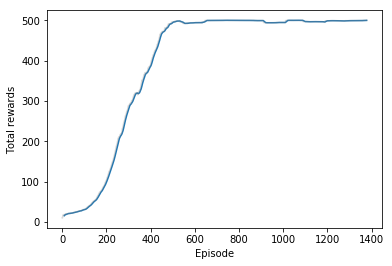

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

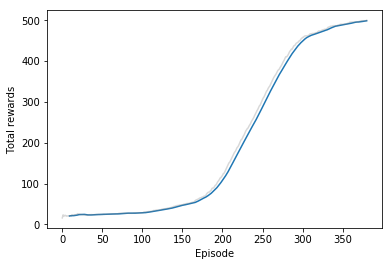

In [59]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

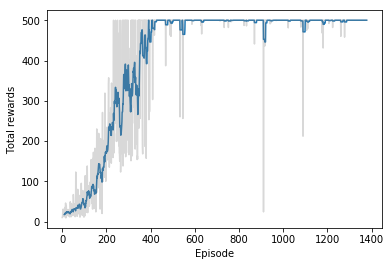

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

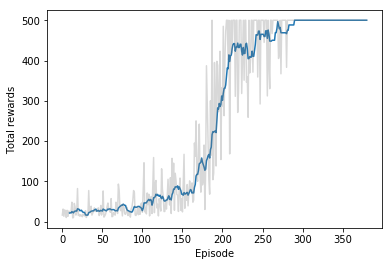

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.